In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gpdc2d import *
from scipy.linalg.blas import sgemm
import numexpr as ne
from scipy import signal
from copy import copy
import matplotlib.colors as colors 
from skimage import color, data, restoration



In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def get_img_indices(img):
    row, col = img.shape
    indices = np.zeros((row*col,2))
    idx = 0
    for i in range(row):
        for j in range(col):
            indices[idx, 0] = i
            indices[idx, 1] = j
            idx += 1
    return indices

In [4]:
def get_filter(dim_w, mode='diag', seed=123):
    if mode == 'diag':
        h = np.ones((dim_w, dim_w)) * 1e-1 + np.eye(dim_w)
        h /= np.sum(h)
    
    elif mode == 'gauss':
        shape = (dim_w, dim_w)
        sigma =1.
        m,n = [(ss-1.)/2. for ss in shape]
        y,x = np.ogrid[-m:m+1,-n:n+1]
        h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
        h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
        sumh = h.sum()
        h /= sumh
    
    elif mode == 'flat':
        h = np.ones((dim_w, dim_w))
        h /= np.sum(h)
    
    elif mode == 'random':
        np.random.seed(seed)
        h = np.random.rand(dim_w**2).reshape(dim_w, dim_w)
        h /= np.sum(h)
        
    elif mode == 'centered':
        h = np.ones((dim_w, dim_w))*1e-3
        h[dim_w//2, dim_w//2] = 1
        h /= np.sum(h)
    
    return h

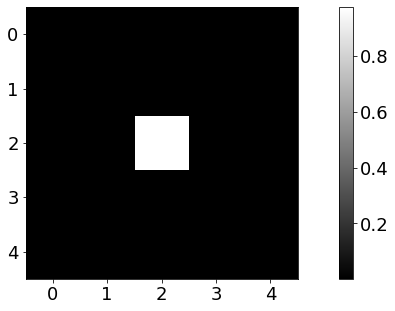

In [5]:
z = get_filter(5, 'centered')
plt.imshow(z, cmap='gray')
plt.colorbar()

In [6]:
def get_image(image_name, dim):
    # load an image
    if image_name == 'grid':
        img = mpimg.imread('/home/ard/data/images/dtd/images/grid/grid_0011.jpg')
        x = img[:dim, :dim, :]
    
    elif image_name == 'swiss_plane':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[1400].reshape(3,32,32), (1, 2, 0))
        dim = 32
        
    elif image_name == 'frog':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[2100].reshape(3,32,32), (1, 2, 0))
        dim = 32
        
    elif image_name == 'plane':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[700].reshape(3,32,32), (1, 2, 0))
        dim = 32 # original image size
    
    elif image_name == 'rider':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[1200].reshape(3,32,32), (1, 2, 0))
        dim = 32
        
    elif image_name == 'bird':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[800].reshape(3,32,32), (1, 2, 0))
        dim = 32
        
    elif image_name == 'chequered':
        #img = mpimg.imread('/home/ard/data/images/dtd/images/chequered/chequered_0066.jpg')
        img = mpimg.imread('/home/ard/data/images/dtd/images/chequered/chequered_0106.jpg')
        x = img[:dim, :dim, :]
        
    elif image_name == 'woven':
        img = mpimg.imread('/home/ard/data/images/dtd/images/woven/woven_0056.jpg')
        x = img[:dim, :dim, :]

    elif image_name == 'horse':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[7].reshape(3,32,32), (1, 2, 0))
        dim = 32 # original image size
    
    elif image_name == 'emu':
        data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
        x = np.transpose(data[2224].reshape(3,32,32), (1, 2, 0))
        dim = 32 # original image size
        
    return x, dim

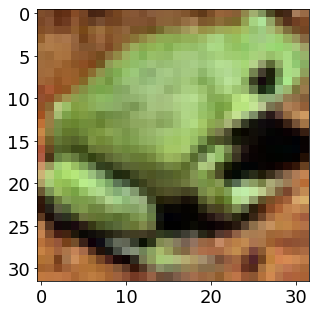

In [7]:
data = unpickle('/home/ard/data/images/cifar-10-batches-py/data_batch_1')[b'data']
x = np.transpose(data[2100].reshape(3,32,32), (1, 2, 0))
plt.imshow(x)

In [9]:
def experiment_image(image_name, filter_type, obs_ratio):
    ### parameters
    dim = 32  # image dimension dim*dim
    dim_w = 5 # filter dimension dim_w*dim_w

    x, dim = get_image(image_name, dim) 
    num_obs = int(dim**2 * obs_ratio)    


    # grey scale
    x = x.reshape(-1, 3)
    # light grey scale : https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm
    x = np.array([0.3, 0.59, 0.11])@x.T
    x -= np.mean(x)
    x /= np.std(x)
    x = x.reshape(dim, dim)
    indices = get_img_indices(x)

    """
    # construct filter
    h = np.ones((dim_w,dim_w)) * 1e-1
    h[0,0] = 1
    h[1,1] = 1
    h[2,2] = 1
    h[3,3] = 1
    h[4,4] = 1

    h /= np.sum(h)
    h = np.flipud(np.fliplr(h))
    """ 
    h = get_filter(dim_w, filter_type)
    # create convolved image and normalize
    f = signal.convolve2d(x, h, mode='same')
    f = f.reshape(-1)

    obs_idx = np.random.choice(len(indices), num_obs, replace=False)
    y = f[obs_idx] + 0.01*np.std(f)*np.random.randn(len(obs_idx))
    indices_y = indices[obs_idx]
    f = f.reshape(dim,dim)

    # show data
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    axes[0].set_title("original image")
    axes[0].imshow(x, cmap='gray')
    axes[1].set_title("convolved image")
    axes[1].imshow(f, cmap='gray')
    axes[2].set_title("filter")
    axes[2].imshow(h)
    plt.show()
    
    
    # learn only Kx
    my_gpc = gpc(indices, indices_y, y.reshape(-1), weights=h)
    my_gpc.train()
    my_gpc.compute_moments()
    
    
    # learn only Kx
    full_gpc = gpc(indices, indices_y, y.reshape(-1), num_weights=25)
    full_gpc.train()
    full_gpc.compute_moments()
    
    
    # save results
    obs_ratio = int(obs_ratio*10)
    np.save("computations/original_image_{}_{}_{}".format(image_name, filter_type, obs_ratio), x)
    np.save("computations/convoved_image_{}_{}_{}".format(image_name, filter_type, obs_ratio), f)
    np.save("computations/input_image_{}_{}_{}".format(image_name, filter_type, obs_ratio), y)
    np.save("computations/observation_indices_{}_{}_{}".format(image_name, filter_type, obs_ratio), obs_idx)
    np.save("computations/filter_{}_{}_{}".format(image_name, filter_type, obs_ratio), h)
    np.save("computations/GPDC_{}_{}_{}".format(image_name, filter_type, obs_ratio), my_gpc.post_mean_x)
    np.save("computations/blind-GPDC_{}_{}_{}".format(image_name, filter_type, obs_ratio), full_gpc.post_mean_x)
    np.save("computations/blind-GPDC_weights_{}_{}_{}".format(image_name, filter_type, obs_ratio), full_gpc.weights)
    

    
    

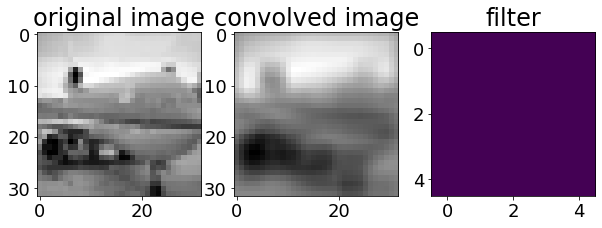

Optimization terminated successfully.
         Current function value: -1027.860613
         Iterations: 5
         Function evaluations: 199
Hyperparameters are:
[0.37047512 0.63362357 0.00777476]
(5, 5)
Optimization terminated successfully.
         Current function value: -1013.463498
         Iterations: 20
         Function evaluations: 6790
Hyperparameters are:
[0.22346691 0.10497748 0.01284805]


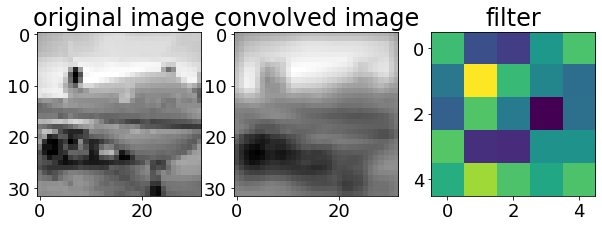

Optimization terminated successfully.
         Current function value: -749.626123
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.26010648 0.64684128 0.02382708]
(5, 5)
Optimization terminated successfully.
         Current function value: -860.825370
         Iterations: 24
         Function evaluations: 8310
Hyperparameters are:
[0.26731517 0.14919246 0.00921386]


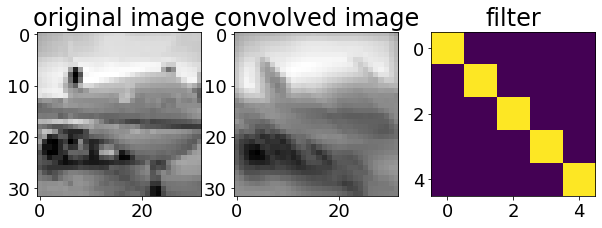

Optimization terminated successfully.
         Current function value: -635.237183
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.30170706 0.60254666 0.02337363]
(5, 5)
Optimization terminated successfully.
         Current function value: -637.053331
         Iterations: 27
         Function evaluations: 8959
Hyperparameters are:
[0.29233211 0.15215367 0.01865954]


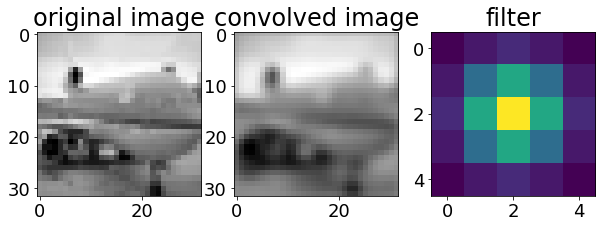

Optimization terminated successfully.
         Current function value: -797.739828
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21371587 0.57598099 0.01160397]
(5, 5)
Optimization terminated successfully.
         Current function value: -827.480663
         Iterations: 14
         Function evaluations: 4744
Hyperparameters are:
[0.1723214  0.38206529 0.00836937]


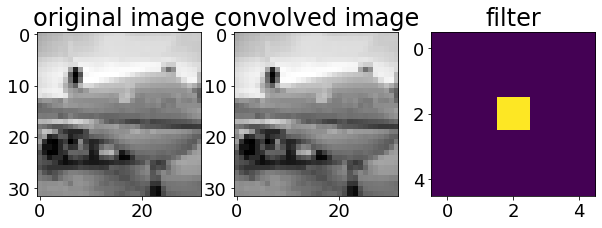

Optimization terminated successfully.
         Current function value: 273.051370
         Iterations: 6
         Function evaluations: 222
Hyperparameters are:
[0.18024337 0.58976029 0.18474653]
(5, 5)
Optimization terminated successfully.
         Current function value: 228.663991
         Iterations: 18
         Function evaluations: 6035
Hyperparameters are:
[0.32676857 0.85233541 0.09090714]


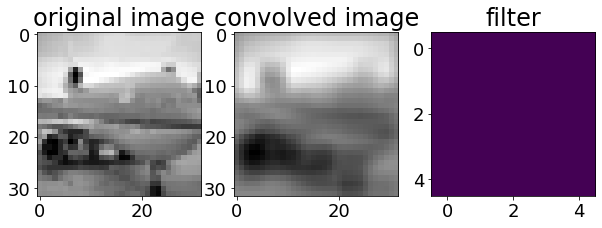

Optimization terminated successfully.
         Current function value: -1284.678527
         Iterations: 5
         Function evaluations: 190
Hyperparameters are:
[0.39570817 0.64077306 0.00747466]
(5, 5)
Optimization terminated successfully.
         Current function value: -1291.693108
         Iterations: 18
         Function evaluations: 6309
Hyperparameters are:
[0.3091651  0.08332934 0.00717857]


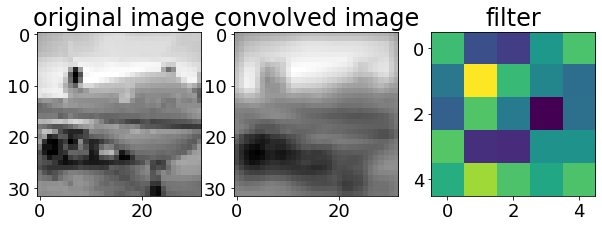

Optimization terminated successfully.
         Current function value: -919.586447
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.27863818 0.61503305 0.02457874]
(5, 5)
Optimization terminated successfully.
         Current function value: -1065.247821
         Iterations: 15
         Function evaluations: 5268
Hyperparameters are:
[0.29031824 0.29844989 0.00902112]


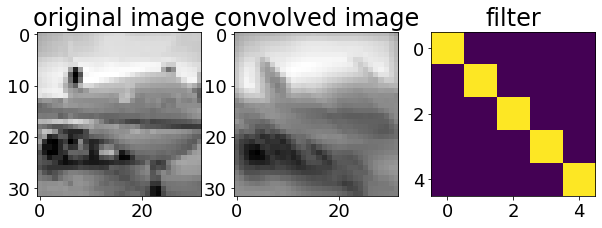

Optimization terminated successfully.
         Current function value: -798.191975
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.31947345 0.5862052  0.02397181]
(5, 5)
Optimization terminated successfully.
         Current function value: -806.198978
         Iterations: 29
         Function evaluations: 10036
Hyperparameters are:
[0.3265468  0.28059886 0.02102411]


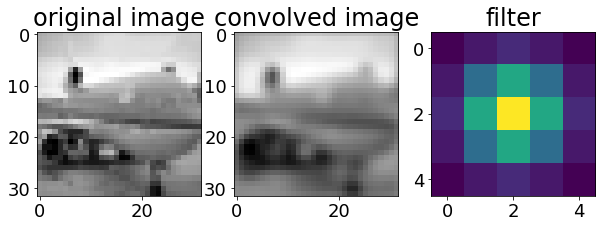

Optimization terminated successfully.
         Current function value: -1083.400456
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.22788545 0.57612408 0.00972436]
(5, 5)
Optimization terminated successfully.
         Current function value: -1105.152749
         Iterations: 16
         Function evaluations: 5352
Hyperparameters are:
[0.18752371 0.16680075 0.00779532]


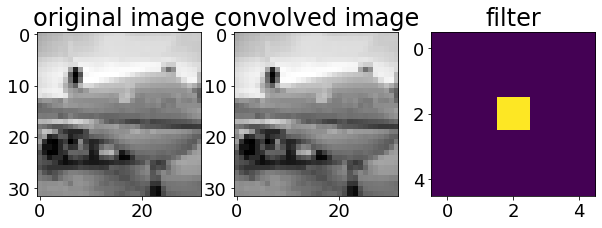

Optimization terminated successfully.
         Current function value: 319.818852
         Iterations: 6
         Function evaluations: 226
Hyperparameters are:
[0.15528452 0.58371667 0.22402377]
(5, 5)
Optimization terminated successfully.
         Current function value: 212.078408
         Iterations: 20
         Function evaluations: 6648
Hyperparameters are:
[1.01787918 0.84492537 0.08707849]


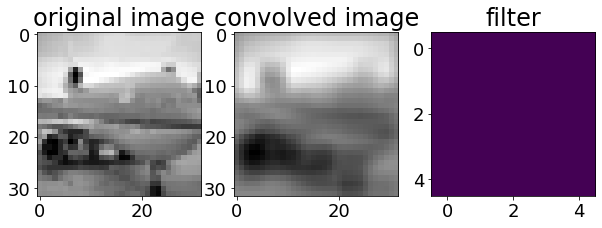

Optimization terminated successfully.
         Current function value: -1580.131674
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.40448356 0.62209286 0.00738449]
(5, 5)
Optimization terminated successfully.
         Current function value: -1603.691203
         Iterations: 18
         Function evaluations: 6314
Hyperparameters are:
[0.31244892 0.09936817 0.00673987]


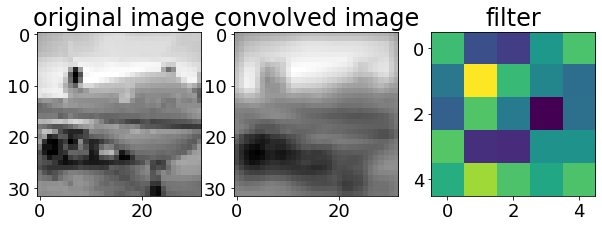

Optimization terminated successfully.
         Current function value: -1111.445186
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.2881998  0.59517599 0.02446236]
(5, 5)
Optimization terminated successfully.
         Current function value: -1318.370637
         Iterations: 16
         Function evaluations: 5659
Hyperparameters are:
[0.30093234 0.27766134 0.00899376]


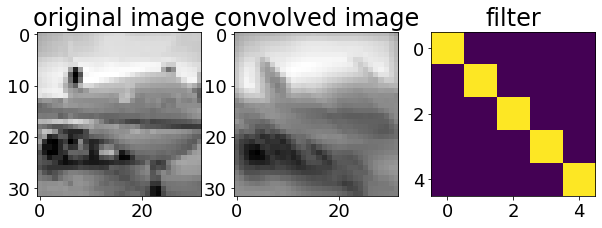

Optimization terminated successfully.
         Current function value: -1025.775652
         Iterations: 7
         Function evaluations: 270
Hyperparameters are:
[0.46647903 0.54035995 0.0061789 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1040.356057
         Iterations: 48
         Function evaluations: 16621
Hyperparameters are:
[0.40587977 0.34576496 0.00930961]


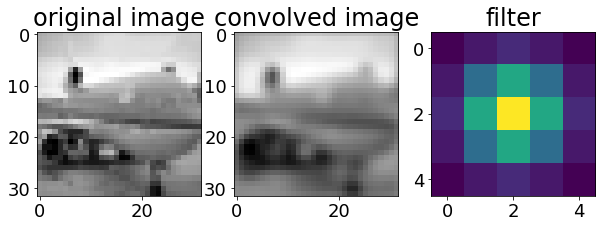

Optimization terminated successfully.
         Current function value: -1312.411208
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.24746487 0.56364065 0.01055744]
(5, 5)
Optimization terminated successfully.
         Current function value: -1380.683406
         Iterations: 14
         Function evaluations: 4689
Hyperparameters are:
[0.19049353 0.1776581  0.00821636]


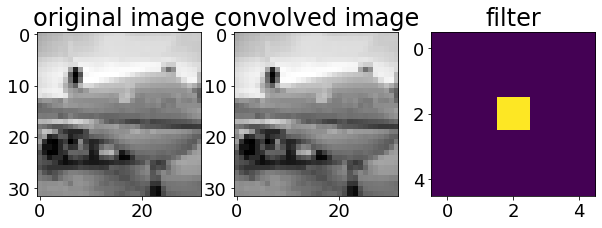

Optimization terminated successfully.
         Current function value: 351.865607
         Iterations: 6
         Function evaluations: 218
Hyperparameters are:
[0.19565976 0.56334032 0.20811167]
(5, 5)
Optimization terminated successfully.
         Current function value: 252.718652
         Iterations: 25
         Function evaluations: 8425
Hyperparameters are:
[0.4392065  0.64374184 0.10491762]


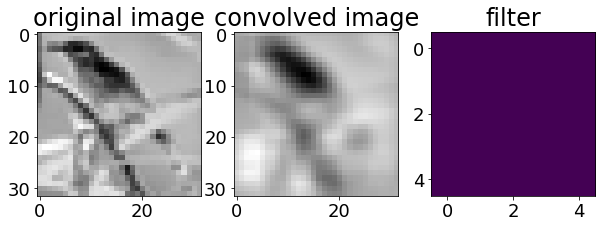

Optimization terminated successfully.
         Current function value: -971.067161
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.38534317 0.79485833 0.00734539]
(5, 5)
Optimization terminated successfully.
         Current function value: -971.409109
         Iterations: 18
         Function evaluations: 6500
Hyperparameters are:
[0.3439121  0.13901705 0.00445467]


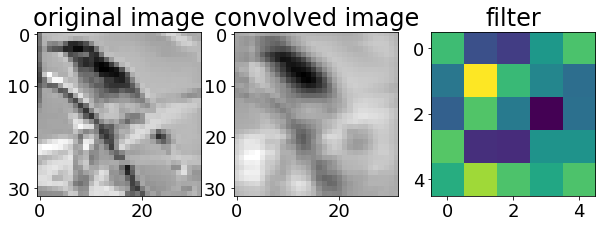

Optimization terminated successfully.
         Current function value: -597.959335
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.34354055 0.77770616 0.02937699]
(5, 5)
Optimization terminated successfully.
         Current function value: -688.704367
         Iterations: 25
         Function evaluations: 8546
Hyperparameters are:
[0.36458896 0.08273358 0.0014076 ]


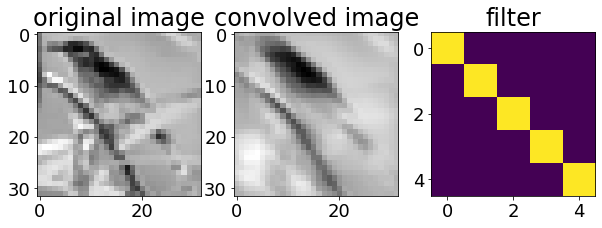

Optimization terminated successfully.
         Current function value: -457.893035
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.50651612 0.81390367 0.00105574]
(5, 5)
Optimization terminated successfully.
         Current function value: -468.919885
         Iterations: 30
         Function evaluations: 10430
Hyperparameters are:
[0.41753269 0.08767033 0.0014903 ]


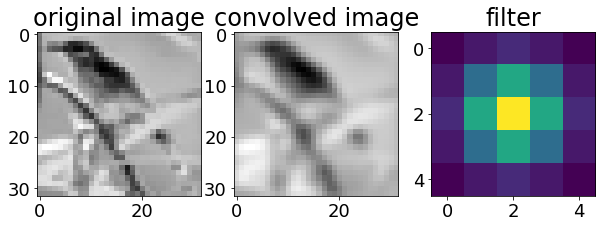

Optimization terminated successfully.
         Current function value: -653.278906
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.34929586 0.78057791 0.00779276]
(5, 5)
Optimization terminated successfully.
         Current function value: -616.068684
         Iterations: 31
         Function evaluations: 11499
Hyperparameters are:
[0.14259397 0.16377712 0.00987192]


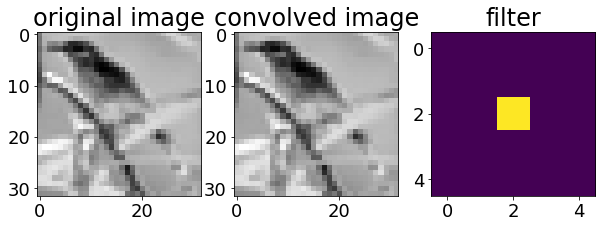

Optimization terminated successfully.
         Current function value: 511.540292
         Iterations: 6
         Function evaluations: 229
Hyperparameters are:
[0.29296532 0.78367061 0.23918146]
(5, 5)
Optimization terminated successfully.
         Current function value: 443.326009
         Iterations: 30
         Function evaluations: 9623
Hyperparameters are:
[0.4043016  0.31056589 0.07720293]


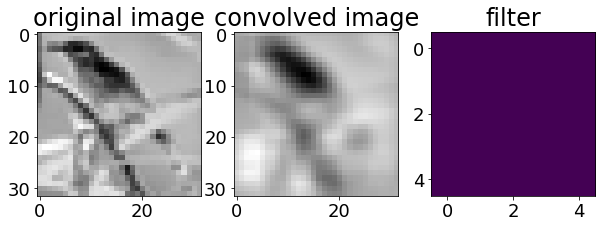

Optimization terminated successfully.
         Current function value: -1250.295627
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.383664   0.76740889 0.00739999]
(5, 5)
Optimization terminated successfully.
         Current function value: -1249.425041
         Iterations: 20
         Function evaluations: 7281
Hyperparameters are:
[0.35648836 0.13440056 0.00525461]


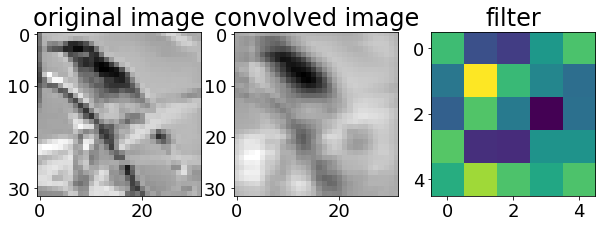

Optimization terminated successfully.
         Current function value: -778.355302
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.36247317 0.76477357 0.02608611]
(5, 5)
Optimization terminated successfully.
         Current function value: -889.629068
         Iterations: 25
         Function evaluations: 8784
Hyperparameters are:
[0.39661237 0.14869956 0.00649908]


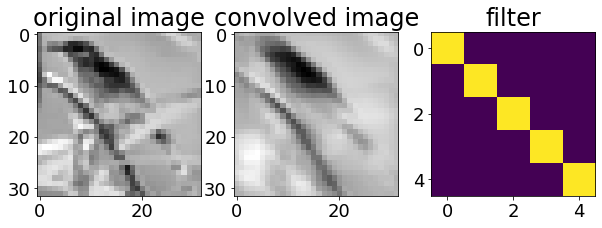

Optimization terminated successfully.
         Current function value: -635.576969
         Iterations: 6
         Function evaluations: 232
Hyperparameters are:
[0.52130487 0.74683353 0.00588121]
(5, 5)
Optimization terminated successfully.
         Current function value: -653.560788
         Iterations: 31
         Function evaluations: 10977
Hyperparameters are:
[0.40402237 0.34412146 0.00302958]


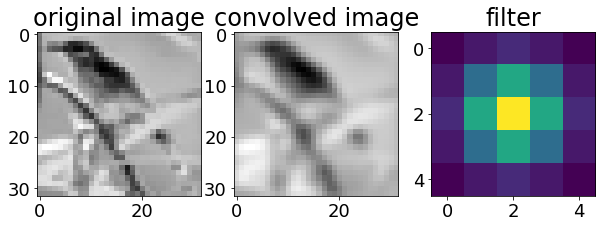

Optimization terminated successfully.
         Current function value: -918.643926
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.33277888 0.77591632 0.00854165]
(5, 5)
Optimization terminated successfully.
         Current function value: -856.720364
         Iterations: 34
         Function evaluations: 12710
Hyperparameters are:
[0.20784722 1.47535689 0.00790445]


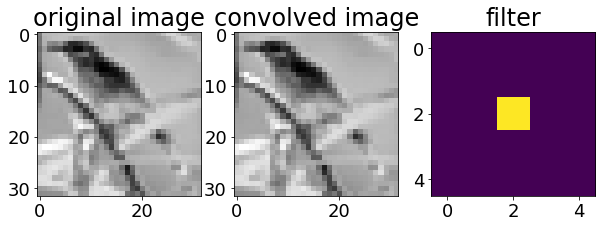

Optimization terminated successfully.
         Current function value: 511.092545
         Iterations: 5
         Function evaluations: 189
Hyperparameters are:
[0.34182996 0.7767958  0.1570288 ]
(5, 5)
Optimization terminated successfully.
         Current function value: 443.764015
         Iterations: 50
         Function evaluations: 16513
Hyperparameters are:
[0.34363094 0.65196931 0.02839582]


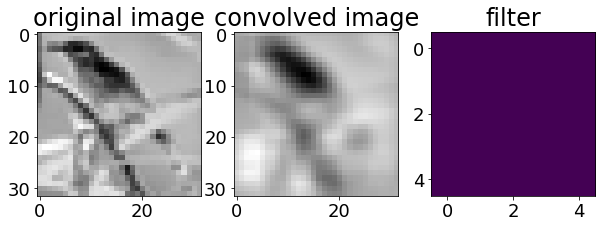

Optimization terminated successfully.
         Current function value: -1551.790496
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.40913898 0.77010617 0.00625662]
(5, 5)
Optimization terminated successfully.
         Current function value: -1550.421822
         Iterations: 22
         Function evaluations: 7887
Hyperparameters are:
[0.38965091 0.10503366 0.00561649]


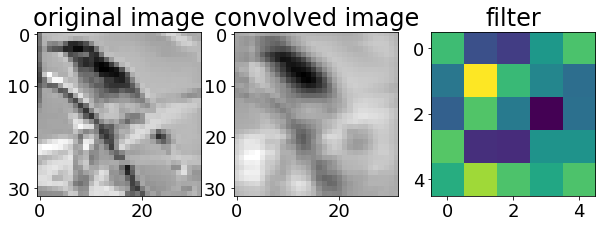

Optimization terminated successfully.
         Current function value: -948.978107
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.37797927 0.76385444 0.0254324 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1127.642451
         Iterations: 23
         Function evaluations: 8349
Hyperparameters are:
[0.40053101 0.17639884 0.00631928]


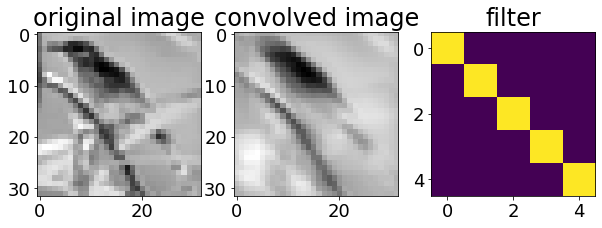

Optimization terminated successfully.
         Current function value: -835.800387
         Iterations: 5
         Function evaluations: 190
Hyperparameters are:
[0.5104267  0.7577366  0.00572026]
(5, 5)
Optimization terminated successfully.
         Current function value: -843.194870
         Iterations: 29
         Function evaluations: 10379
Hyperparameters are:
[0.4329279  0.18682913 0.00389453]


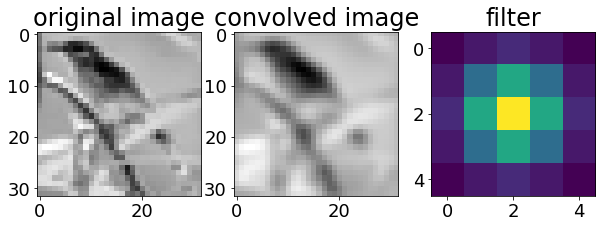

Optimization terminated successfully.
         Current function value: -1183.586122
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.36438706 0.7731579  0.00801445]
(5, 5)
Optimization terminated successfully.
         Current function value: -1110.376783
         Iterations: 42
         Function evaluations: 15557
Hyperparameters are:
[0.20188434 1.11268663 0.00791473]


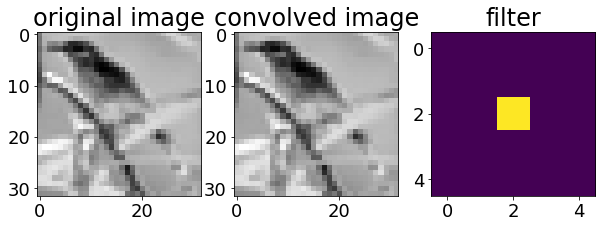

Optimization terminated successfully.
         Current function value: 561.166725
         Iterations: 3
         Function evaluations: 127
Hyperparameters are:
[0.39389306 0.76051204 0.12961063]
(5, 5)
Optimization terminated successfully.
         Current function value: 465.719910
         Iterations: 34
         Function evaluations: 11030
Hyperparameters are:
[0.38870706 0.86886463 0.07409951]


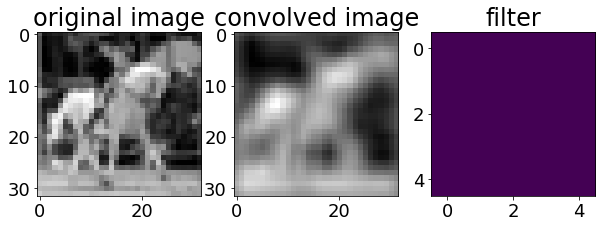

Optimization terminated successfully.
         Current function value: -965.145329
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.42270072 0.74535952 0.00701372]
(5, 5)
Optimization terminated successfully.
         Current function value: -977.549803
         Iterations: 23
         Function evaluations: 8199
Hyperparameters are:
[3.95115202e-01 6.13696787e-02 2.29452382e-50]


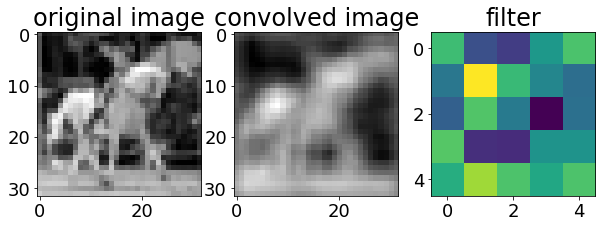

Optimization terminated successfully.
         Current function value: -657.569199
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.27420408 0.77153726 0.02884377]
(5, 5)
Optimization terminated successfully.
         Current function value: -745.376406
         Iterations: 20
         Function evaluations: 6608
Hyperparameters are:
[0.37984932 0.04039863 0.00789765]


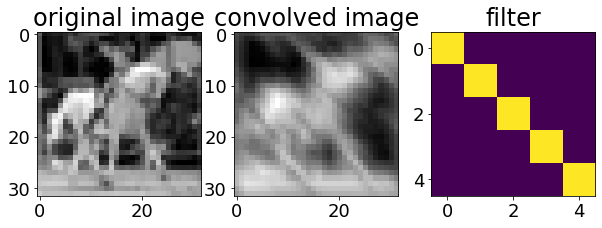

Optimization terminated successfully.
         Current function value: -526.158751
         Iterations: 5
         Function evaluations: 184
Hyperparameters are:
[0.38064563 0.72671245 0.02241228]
(5, 5)
Optimization terminated successfully.
         Current function value: -523.276445
         Iterations: 27
         Function evaluations: 9434
Hyperparameters are:
[0.42246488 0.44207425 0.00346681]


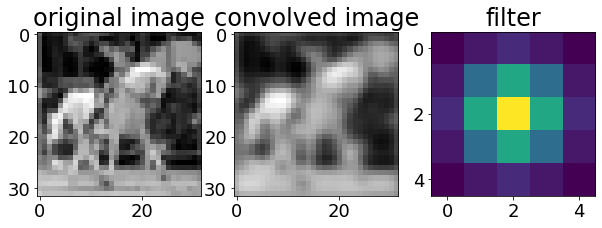

Optimization terminated successfully.
         Current function value: -695.735011
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.2947273  0.74116466 0.00893378]
(5, 5)
Optimization terminated successfully.
         Current function value: -706.121467
         Iterations: 25
         Function evaluations: 8504
Hyperparameters are:
[0.23451187 0.28683958 0.00638517]


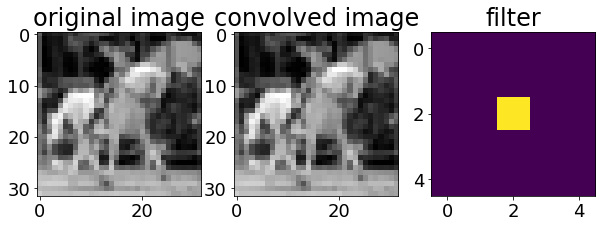

Optimization terminated successfully.
         Current function value: 435.138787
         Iterations: 6
         Function evaluations: 229
Hyperparameters are:
[0.23823877 0.73642752 0.22577863]
(5, 5)
Optimization terminated successfully.
         Current function value: 394.056061
         Iterations: 34
         Function evaluations: 11012
Hyperparameters are:
[0.47422286 0.93343452 0.07000193]


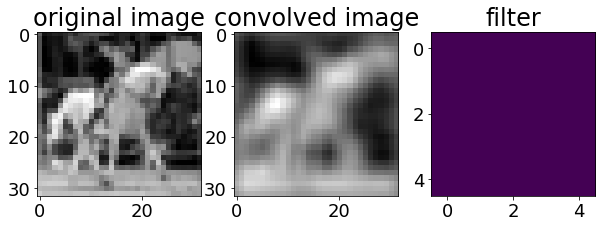

Optimization terminated successfully.
         Current function value: -1244.670509
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.43173594 0.73209634 0.00636647]
(5, 5)
Optimization terminated successfully.
         Current function value: -1239.576525
         Iterations: 28
         Function evaluations: 9808
Hyperparameters are:
[0.39447948 0.06101369 0.0041211 ]


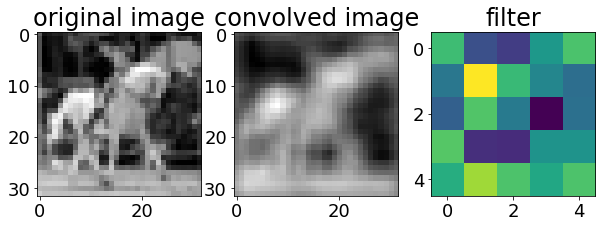

Optimization terminated successfully.
         Current function value: -815.775173
         Iterations: 4
         Function evaluations: 139
Hyperparameters are:
[0.26902346 0.75099864 0.03102235]
(5, 5)
Optimization terminated successfully.
         Current function value: -961.558986
         Iterations: 42
         Function evaluations: 14261
Hyperparameters are:
[0.37869788 0.06531692 0.00295842]


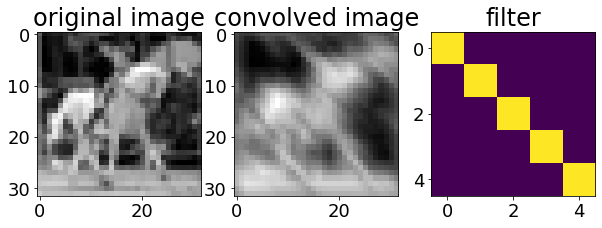

Optimization terminated successfully.
         Current function value: -707.815578
         Iterations: 7
         Function evaluations: 264
Hyperparameters are:
[0.4856709  0.66466971 0.0071175 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -713.518755
         Iterations: 39
         Function evaluations: 13852
Hyperparameters are:
[4.59974183e-01 5.25649979e-01 1.11307235e-14]


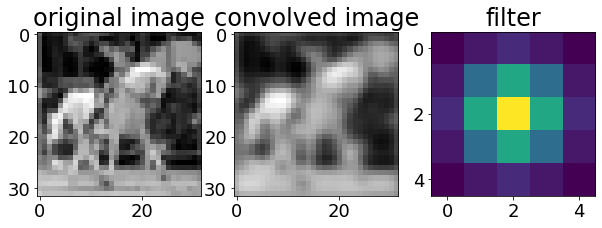

Optimization terminated successfully.
         Current function value: -988.129143
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.29353568 0.73398389 0.00792206]
(5, 5)
Optimization terminated successfully.
         Current function value: -993.988819
         Iterations: 26
         Function evaluations: 8868
Hyperparameters are:
[0.24050096 0.14956835 0.00646143]


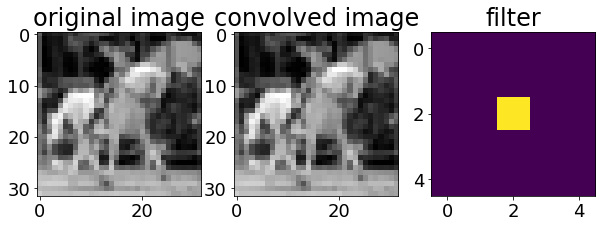

Optimization terminated successfully.
         Current function value: 464.451324
         Iterations: 6
         Function evaluations: 225
Hyperparameters are:
[0.26650762 0.71146758 0.2072328 ]
(5, 5)
Optimization terminated successfully.
         Current function value: 412.324946
         Iterations: 23
         Function evaluations: 7497
Hyperparameters are:
[0.5706431  0.35453415 0.07798377]


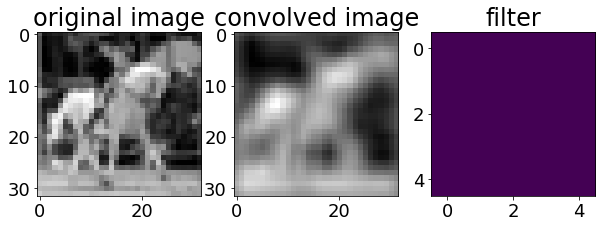

Optimization terminated successfully.
         Current function value: -1554.709836
         Iterations: 6
         Function evaluations: 233
Hyperparameters are:
[0.43231365 0.71311217 0.00617014]
(5, 5)
Optimization terminated successfully.
         Current function value: -1554.855257
         Iterations: 14
         Function evaluations: 5411
Hyperparameters are:
[0.38052372 0.43347029 0.00549064]


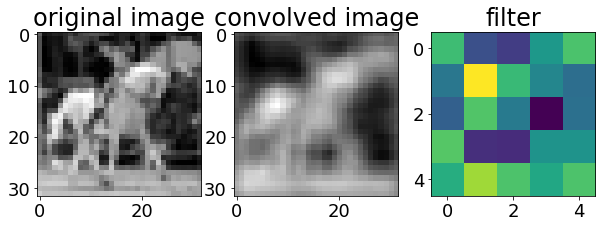

Optimization terminated successfully.
         Current function value: -997.330770
         Iterations: 4
         Function evaluations: 139
Hyperparameters are:
[0.26683743 0.74428613 0.03076673]
(5, 5)
Optimization terminated successfully.
         Current function value: -1161.604784
         Iterations: 29
         Function evaluations: 9743
Hyperparameters are:
[0.36038235 0.08052644 0.01036522]


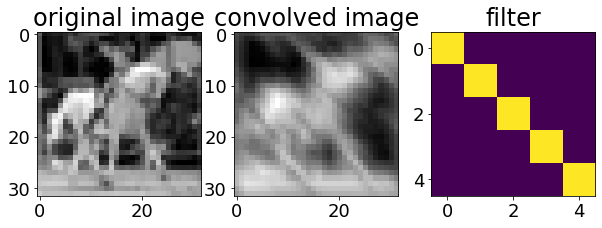

Optimization terminated successfully.
         Current function value: -929.053413
         Iterations: 6
         Function evaluations: 224
Hyperparameters are:
[0.49302352 0.63063759 0.00610706]
(5, 5)
Optimization terminated successfully.
         Current function value: -929.637129
         Iterations: 44
         Function evaluations: 15864
Hyperparameters are:
[4.60249370e-01 2.62989865e-01 1.07730038e-06]


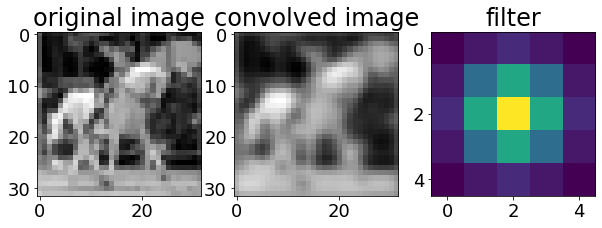

Optimization terminated successfully.
         Current function value: -1248.016103
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.29068584 0.73316207 0.00889805]
(5, 5)
Optimization terminated successfully.
         Current function value: -1213.544935
         Iterations: 19
         Function evaluations: 6984
Hyperparameters are:
[0.18376776 1.83544056 0.00791913]


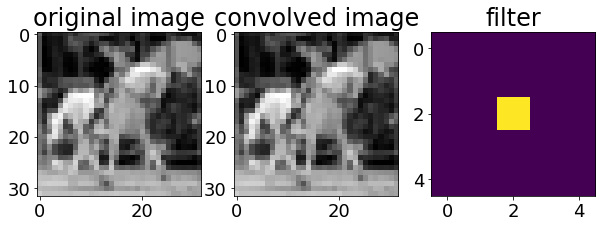

Optimization terminated successfully.
         Current function value: 477.582481
         Iterations: 6
         Function evaluations: 227
Hyperparameters are:
[0.28069352 0.70114639 0.19060635]
(5, 5)
Optimization terminated successfully.
         Current function value: 422.316016
         Iterations: 29
         Function evaluations: 9606
Hyperparameters are:
[0.41199945 1.50256262 0.11847989]


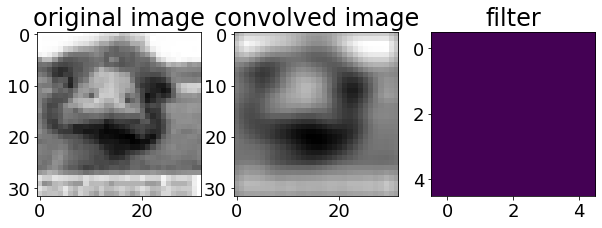

Optimization terminated successfully.
         Current function value: -1072.061620
         Iterations: 5
         Function evaluations: 193
Hyperparameters are:
[0.21866825 0.64224772 0.01219211]
(5, 5)
Optimization terminated successfully.
         Current function value: -1118.314474
         Iterations: 21
         Function evaluations: 7482
Hyperparameters are:
[0.17654246 0.15320678 0.0093026 ]


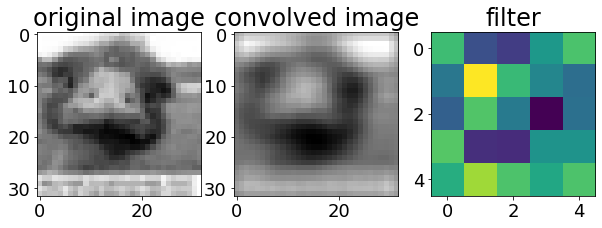

Optimization terminated successfully.
         Current function value: -756.951979
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.19674384 0.78705418 0.02700168]
(5, 5)
Optimization terminated successfully.
         Current function value: -819.189782
         Iterations: 13
         Function evaluations: 4207
Hyperparameters are:
[0.04606802 0.05684659 0.03898077]


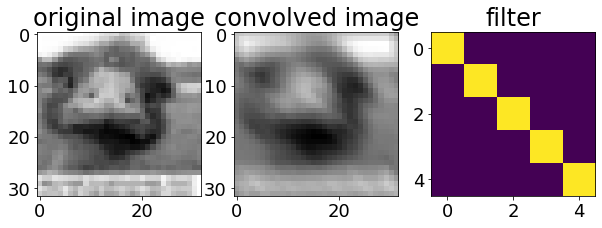

Optimization terminated successfully.
         Current function value: -820.359573
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.21761195 0.596272   0.01654567]
(5, 5)
Optimization terminated successfully.
         Current function value: -844.723611
         Iterations: 27
         Function evaluations: 8930
Hyperparameters are:
[0.19929997 0.09133033 0.0137756 ]


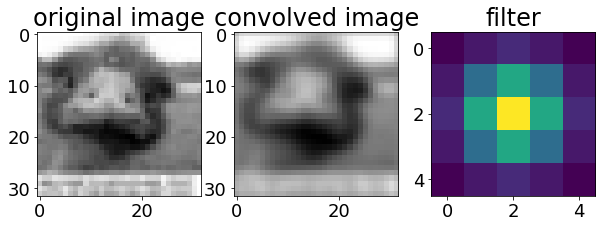

Optimization terminated successfully.
         Current function value: -869.195722
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1802647  0.59606852 0.01048114]
(5, 5)
Optimization terminated successfully.
         Current function value: -899.307390
         Iterations: 15
         Function evaluations: 5063
Hyperparameters are:
[0.14624217 0.2631777  0.00777837]


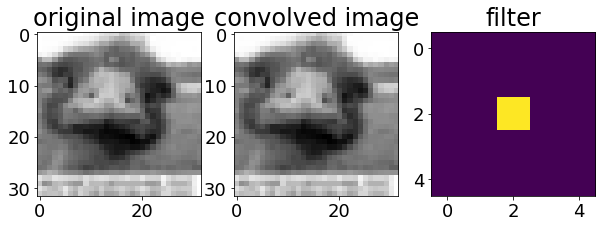

Optimization terminated successfully.
         Current function value: 199.131077
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.12314088 0.60358155 0.18924735]
(5, 5)
Optimization terminated successfully.
         Current function value: 108.708224
         Iterations: 38
         Function evaluations: 12565
Hyperparameters are:
[0.32067145 0.90360088 0.07016462]


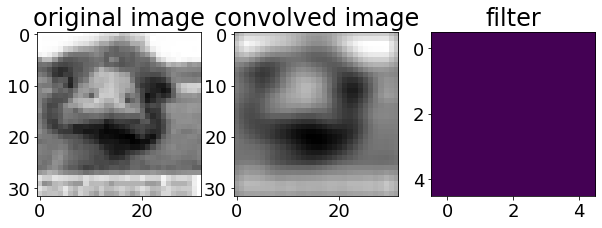

Optimization terminated successfully.
         Current function value: -1366.942361
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.32427751 0.61982091 0.00720285]
(5, 5)
Optimization terminated successfully.
         Current function value: -1395.972922
         Iterations: 22
         Function evaluations: 7898
Hyperparameters are:
[0.18546236 0.22374627 0.0087452 ]


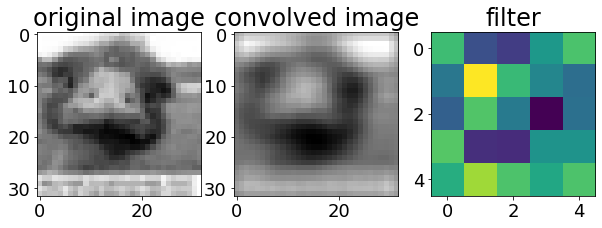

Optimization terminated successfully.
         Current function value: -948.831820
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.19040019 0.73462872 0.02811705]
(5, 5)
Optimization terminated successfully.
         Current function value: -1250.419475
         Iterations: 33
         Function evaluations: 10814
Hyperparameters are:
[0.18749218 0.02809388 0.01129966]


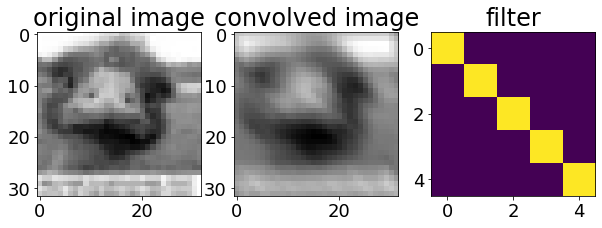

Optimization terminated successfully.
         Current function value: -1039.288083
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.22231437 0.59444056 0.01642621]
(5, 5)
Optimization terminated successfully.
         Current function value: -1055.922479
         Iterations: 20
         Function evaluations: 6793
Hyperparameters are:
[0.21462195 0.08448932 0.0150797 ]


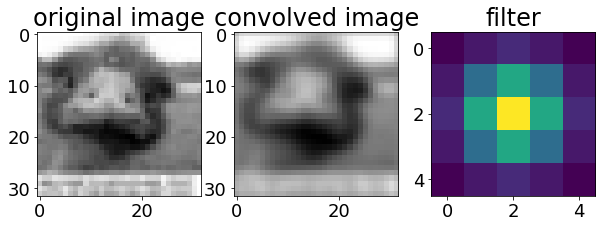

Optimization terminated successfully.
         Current function value: -1156.576674
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.18508443 0.58625    0.00972544]
(5, 5)
Optimization terminated successfully.
         Current function value: -1186.944842
         Iterations: 13
         Function evaluations: 4465
Hyperparameters are:
[0.14604327 0.30637791 0.00778016]


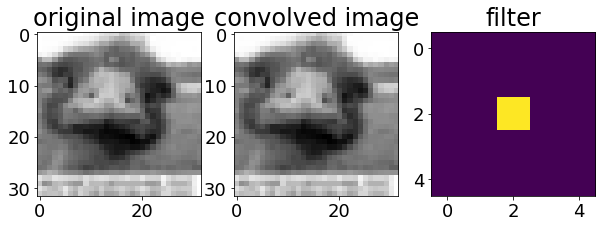

Optimization terminated successfully.
         Current function value: 176.704981
         Iterations: 6
         Function evaluations: 220
Hyperparameters are:
[0.14663663 0.58995727 0.16658198]
(5, 5)
Optimization terminated successfully.
         Current function value: 26.724958
         Iterations: 72
         Function evaluations: 23588
Hyperparameters are:
[0.25700601 1.31346993 0.05434606]


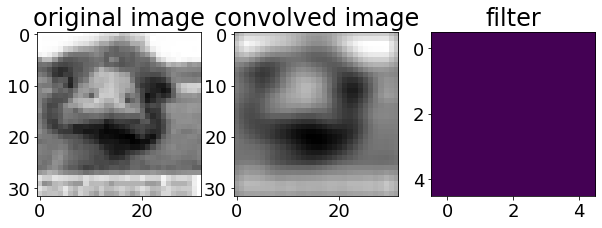

Optimization terminated successfully.
         Current function value: -1660.211387
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.3478242  0.60845432 0.00684957]
(5, 5)
Optimization terminated successfully.
         Current function value: -1685.056975
         Iterations: 19
         Function evaluations: 6695
Hyperparameters are:
[0.19197392 0.11516281 0.00829714]


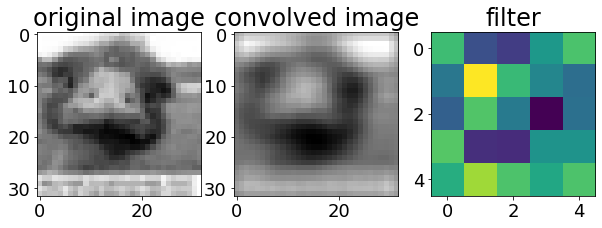

Optimization terminated successfully.
         Current function value: -1136.866892
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.191394   0.70586976 0.02865893]
(5, 5)
Optimization terminated successfully.
         Current function value: -1516.684587
         Iterations: 27
         Function evaluations: 8782
Hyperparameters are:
[0.18845965 0.01363663 0.01162656]


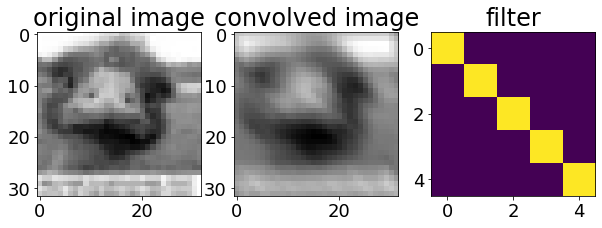

Optimization terminated successfully.
         Current function value: -1262.231480
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.24591547 0.55104398 0.01544998]
(5, 5)
Optimization terminated successfully.
         Current function value: -1272.501939
         Iterations: 29
         Function evaluations: 10075
Hyperparameters are:
[0.28024902 0.0587999  0.0119224 ]


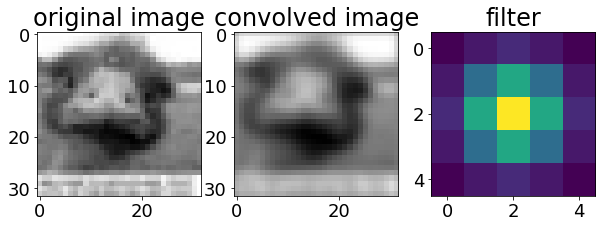

Optimization terminated successfully.
         Current function value: -1421.774043
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.18547815 0.58336798 0.01030758]
(5, 5)
Optimization terminated successfully.
         Current function value: -1458.650063
         Iterations: 11
         Function evaluations: 3791
Hyperparameters are:
[0.14488181 0.37354267 0.00857257]


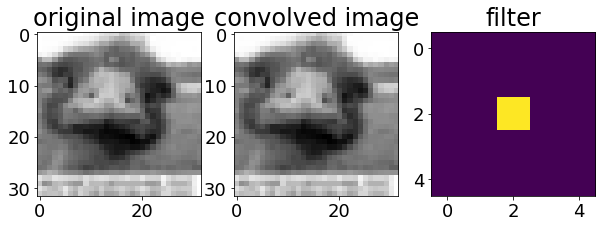

Optimization terminated successfully.
         Current function value: 163.874045
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.23371177 0.57085906 0.11238916]
(5, 5)
Optimization terminated successfully.
         Current function value: 30.683638
         Iterations: 48
         Function evaluations: 15638
Hyperparameters are:
[0.30914119 0.55381284 0.06514193]


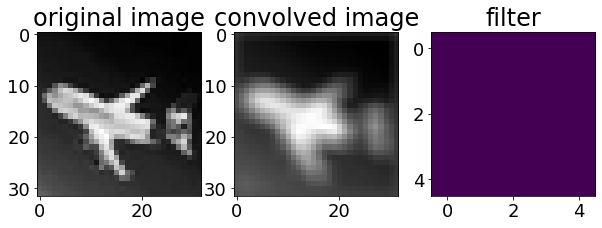

Optimization terminated successfully.
         Current function value: -1110.912030
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.2273295  0.66638054 0.00977143]
(5, 5)
Optimization terminated successfully.
         Current function value: -1113.139060
         Iterations: 13
         Function evaluations: 4854
Hyperparameters are:
[0.18236847 0.54737702 0.00951284]


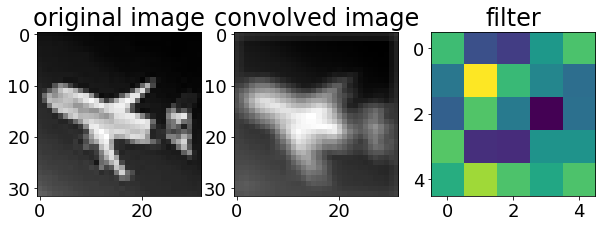

Optimization terminated successfully.
         Current function value: -818.603104
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.22037585 0.6547238  0.02152963]
(5, 5)
Optimization terminated successfully.
         Current function value: -849.285765
         Iterations: 15
         Function evaluations: 5157
Hyperparameters are:
[0.21503749 0.17829962 0.01751495]


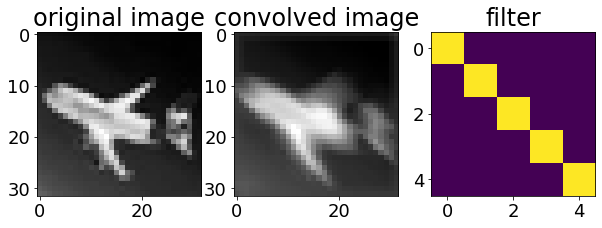

Optimization terminated successfully.
         Current function value: -600.301081
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.31382525 0.64630636 0.02441898]
(5, 5)
Optimization terminated successfully.
         Current function value: -599.154667
         Iterations: 40
         Function evaluations: 13486
Hyperparameters are:
[0.34528619 0.42151692 0.00170417]


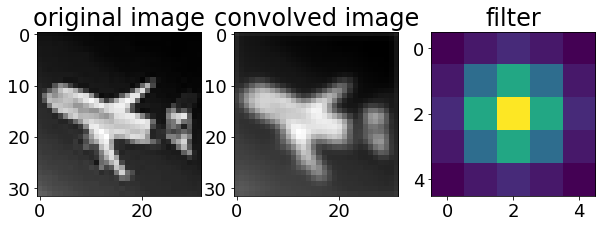

Optimization terminated successfully.
         Current function value: -775.205007
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.24478166 0.65930067 0.00908245]
(5, 5)
Optimization terminated successfully.
         Current function value: -803.810672
         Iterations: 24
         Function evaluations: 8508
Hyperparameters are:
[0.21167436 0.9589738  0.00689762]


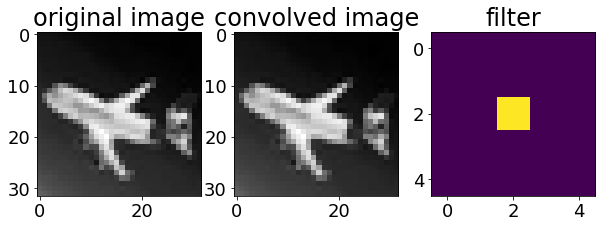

Optimization terminated successfully.
         Current function value: 307.879648
         Iterations: 5
         Function evaluations: 180
Hyperparameters are:
[0.21999324 0.64521235 0.16429073]
(5, 5)
Optimization terminated successfully.
         Current function value: 239.866321
         Iterations: 37
         Function evaluations: 12352
Hyperparameters are:
[0.45601417 0.29171741 0.00836257]


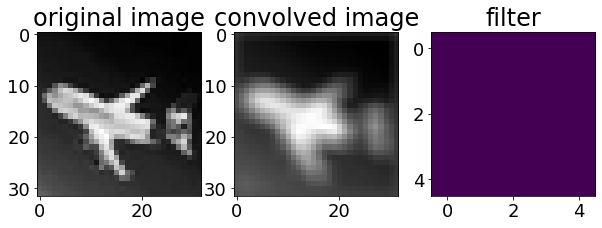

Optimization terminated successfully.
         Current function value: -1342.198394
         Iterations: 3
         Function evaluations: 123
Hyperparameters are:
[0.26752777 0.62399501 0.01015476]
(5, 5)
Optimization terminated successfully.
         Current function value: -1334.945868
         Iterations: 22
         Function evaluations: 8158
Hyperparameters are:
[0.22088704 0.41129445 0.01080233]


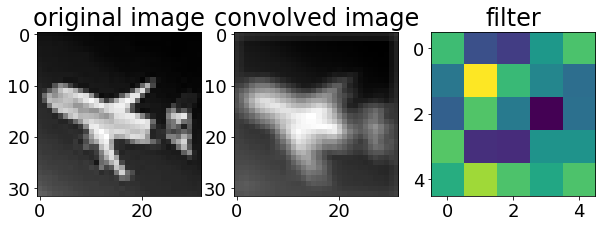

Optimization terminated successfully.
         Current function value: -1014.139849
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.23361528 0.64374969 0.02103811]
(5, 5)
Optimization terminated successfully.
         Current function value: -1074.585336
         Iterations: 31
         Function evaluations: 10698
Hyperparameters are:
[0.30540466 0.09561785 0.00853191]


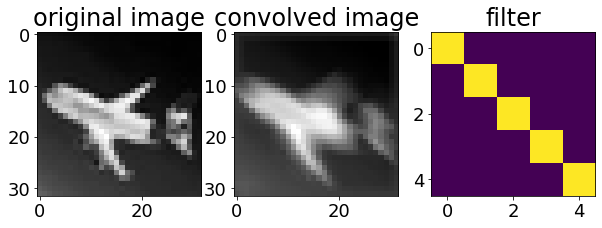

Optimization terminated successfully.
         Current function value: -797.470772
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.35805725 0.61382463 0.01888166]
(5, 5)
Optimization terminated successfully.
         Current function value: -802.521183
         Iterations: 23
         Function evaluations: 7927
Hyperparameters are:
[0.37437634 0.25211734 0.01056525]


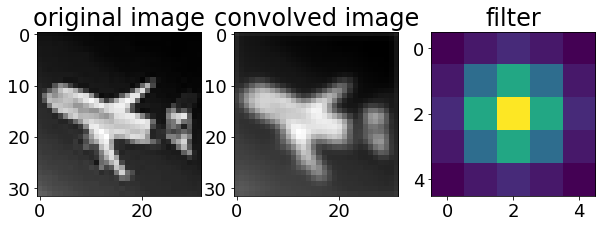

Optimization terminated successfully.
         Current function value: -1051.914777
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.25494538 0.64481183 0.00852909]
(5, 5)
Optimization terminated successfully.
         Current function value: -1081.738773
         Iterations: 20
         Function evaluations: 7282
Hyperparameters are:
[0.22237037 0.6188946  0.00763445]


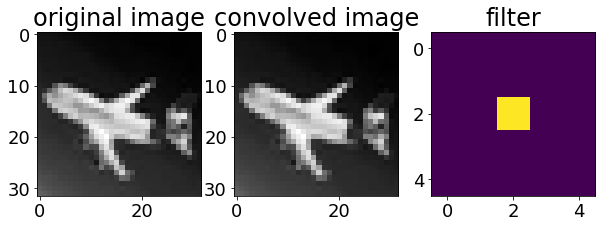

Optimization terminated successfully.
         Current function value: 320.859937
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.22549318 0.6217224  0.16995402]
(5, 5)
Optimization terminated successfully.
         Current function value: 234.571799
         Iterations: 55
         Function evaluations: 17690
Hyperparameters are:
[0.73078125 0.18052061 0.01198783]


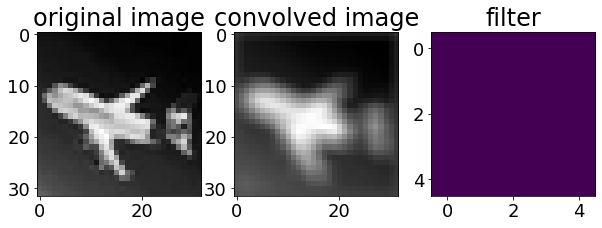

Optimization terminated successfully.
         Current function value: -1618.907525
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.34716646 0.59731468 0.0081662 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1600.117655
         Iterations: 16
         Function evaluations: 5854
Hyperparameters are:
[0.20072932 0.2643224  0.01185114]


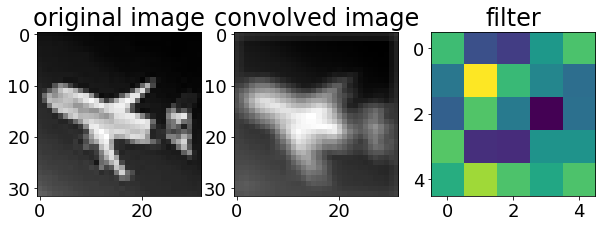

Optimization terminated successfully.
         Current function value: -1223.726497
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25156171 0.6218379  0.02012921]
(5, 5)
Optimization terminated successfully.
         Current function value: -1303.439139
         Iterations: 26
         Function evaluations: 9147
Hyperparameters are:
[0.30617098 0.12240359 0.00929995]


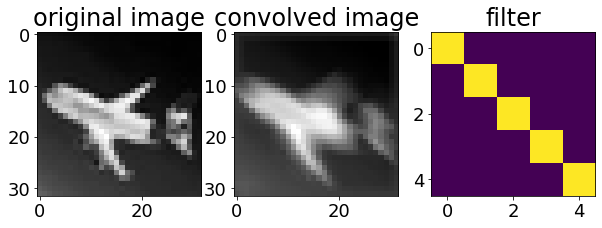

Optimization terminated successfully.
         Current function value: -1016.655107
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.36956155 0.60109201 0.0164318 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1014.138328
         Iterations: 28
         Function evaluations: 9701
Hyperparameters are:
[0.35510867 0.32258623 0.01426107]


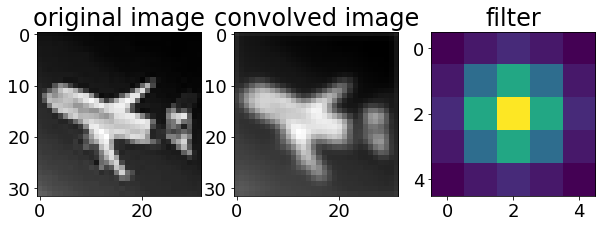

Optimization terminated successfully.
         Current function value: -1345.930498
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.25235034 0.65217924 0.00842612]
(5, 5)
Optimization terminated successfully.
         Current function value: -1383.789410
         Iterations: 22
         Function evaluations: 7830
Hyperparameters are:
[0.24228072 0.32044235 0.00733698]


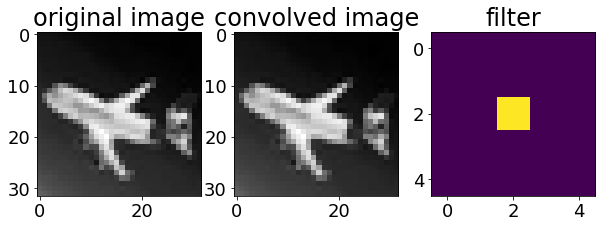

Optimization terminated successfully.
         Current function value: 357.046404
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.23533627 0.63375822 0.17537737]
(5, 5)
Optimization terminated successfully.
         Current function value: 279.132524
         Iterations: 29
         Function evaluations: 9993
Hyperparameters are:
[0.49623463 2.16923205 0.06513124]


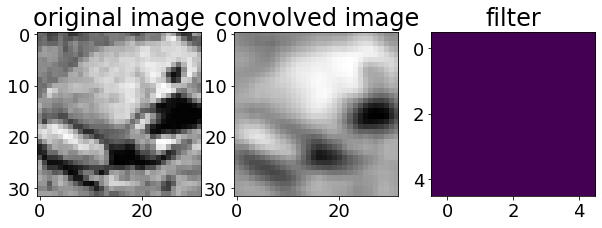

Optimization terminated successfully.
         Current function value: -1075.632349
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.27980198 0.73231351 0.00793977]
(5, 5)
Optimization terminated successfully.
         Current function value: -1067.365726
         Iterations: 28
         Function evaluations: 10247
Hyperparameters are:
[0.28296215 0.13883858 0.00631468]


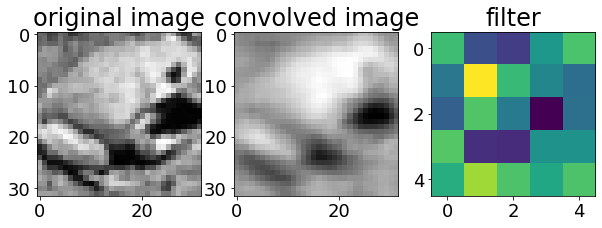

Optimization terminated successfully.
         Current function value: -714.272597
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.25008802 0.76584334 0.02533241]
(5, 5)
Optimization terminated successfully.
         Current function value: -776.538376
         Iterations: 27
         Function evaluations: 9342
Hyperparameters are:
[0.28119941 0.13785126 0.01165885]


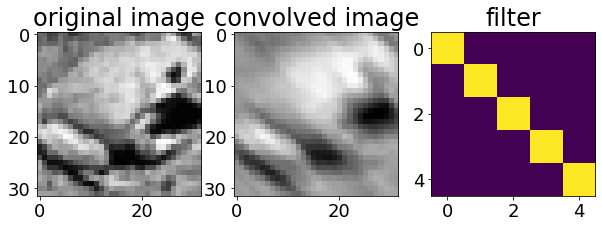

Optimization terminated successfully.
         Current function value: -620.329526
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.33440243 0.72250805 0.01571855]
(5, 5)
Optimization terminated successfully.
         Current function value: -619.705073
         Iterations: 38
         Function evaluations: 13048
Hyperparameters are:
[0.33240558 0.3746338  0.00600942]


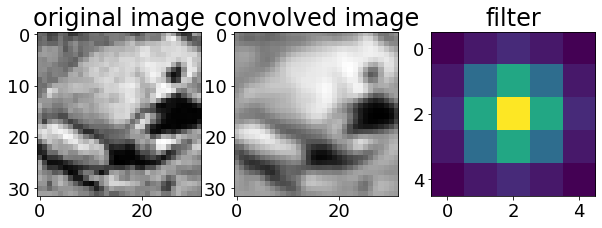

Optimization terminated successfully.
         Current function value: -737.480538
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.26284525 0.75359356 0.00832379]
(5, 5)
Optimization terminated successfully.
         Current function value: -744.092634
         Iterations: 19
         Function evaluations: 6590
Hyperparameters are:
[0.2199583  0.69947172 0.00684924]


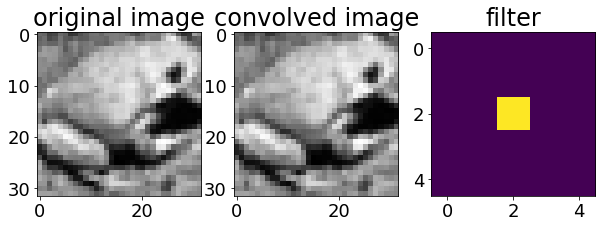

Optimization terminated successfully.
         Current function value: 396.945409
         Iterations: 6
         Function evaluations: 223
Hyperparameters are:
[0.24927586 0.73607712 0.18442034]
(5, 5)
Optimization terminated successfully.
         Current function value: 357.531897
         Iterations: 24
         Function evaluations: 7858
Hyperparameters are:
[0.34008314 1.1065659  0.11237565]


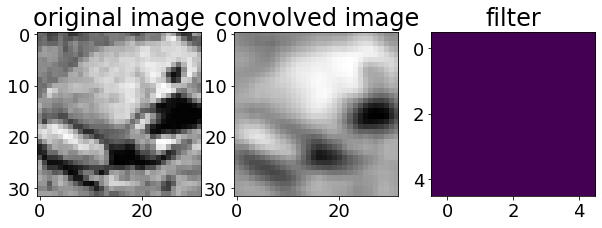

Optimization terminated successfully.
         Current function value: -1339.667863
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.31452627 0.72115843 0.00730465]
(5, 5)
Optimization terminated successfully.
         Current function value: -1327.960782
         Iterations: 17
         Function evaluations: 6518
Hyperparameters are:
[0.29954239 0.38201811 0.00598573]


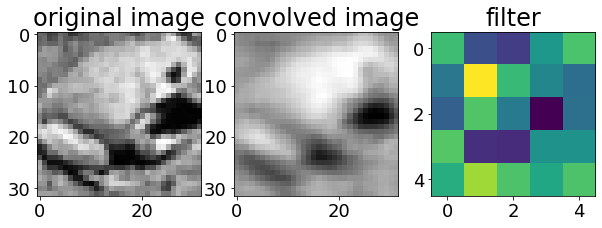

Optimization terminated successfully.
         Current function value: -908.006025
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.25892864 0.78241071 0.02341376]
(5, 5)
Optimization terminated successfully.
         Current function value: -986.168379
         Iterations: 25
         Function evaluations: 8796
Hyperparameters are:
[0.23531992 0.27710582 0.01381485]


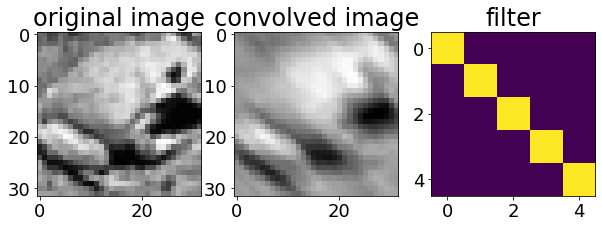

Optimization terminated successfully.
         Current function value: -819.022142
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.34403928 0.68161645 0.01589709]
(5, 5)
Optimization terminated successfully.
         Current function value: -816.820542
         Iterations: 33
         Function evaluations: 11316
Hyperparameters are:
[0.30984138 0.42932573 0.013557  ]


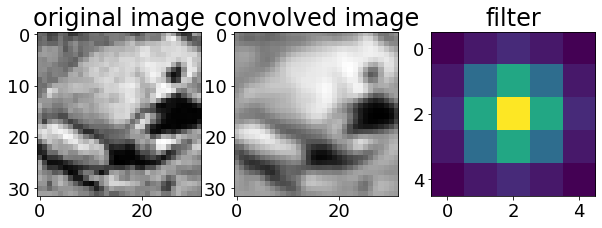

Optimization terminated successfully.
         Current function value: -1006.857405
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.27865066 0.74550789 0.00777588]
(5, 5)
Optimization terminated successfully.
         Current function value: -1017.356720
         Iterations: 20
         Function evaluations: 6951
Hyperparameters are:
[0.22350446 0.97889439 0.00656623]


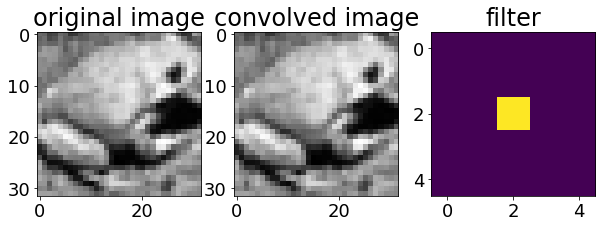

Optimization terminated successfully.
         Current function value: 399.654858
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.25496885 0.7619891  0.16696827]
(5, 5)
Optimization terminated successfully.
         Current function value: 350.052760
         Iterations: 41
         Function evaluations: 13446
Hyperparameters are:
[0.37466769 1.60274584 0.06013008]


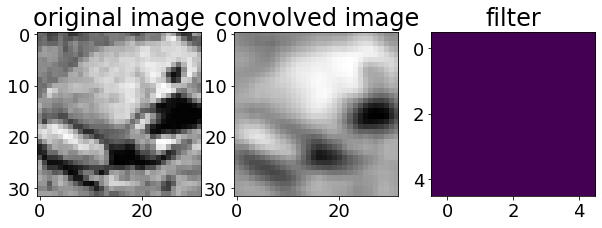

Optimization terminated successfully.
         Current function value: -1651.920270
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.32515589 0.70178593 0.006849  ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1648.296983
         Iterations: 24
         Function evaluations: 9067
Hyperparameters are:
[0.30381295 0.17575463 0.00604619]


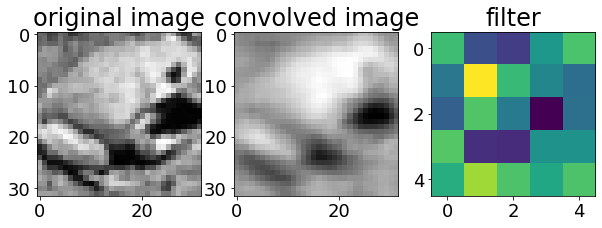

Optimization terminated successfully.
         Current function value: -1108.378868
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.27688356 0.75397403 0.02223217]
(5, 5)
Optimization terminated successfully.
         Current function value: -1192.077704
         Iterations: 21
         Function evaluations: 7465
Hyperparameters are:
[0.25531576 0.17852264 0.01223133]


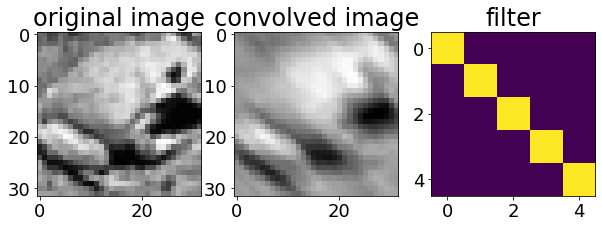

Optimization terminated successfully.
         Current function value: -1020.556855
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.36069577 0.64880811 0.01546838]
(5, 5)
Optimization terminated successfully.
         Current function value: -1018.582871
         Iterations: 34
         Function evaluations: 11601
Hyperparameters are:
[0.34554355 0.11599704 0.00905492]


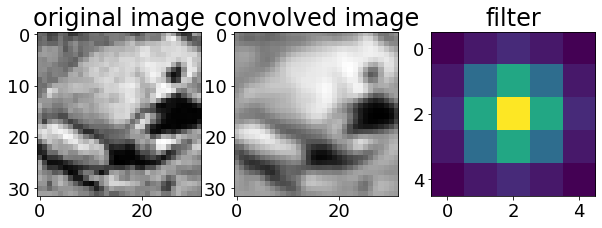

Optimization terminated successfully.
         Current function value: -1274.729340
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.28288969 0.73587519 0.00836938]
(5, 5)
Optimization terminated successfully.
         Current function value: -1280.192010
         Iterations: 23
         Function evaluations: 7880
Hyperparameters are:
[0.22074624 0.44988255 0.00726868]


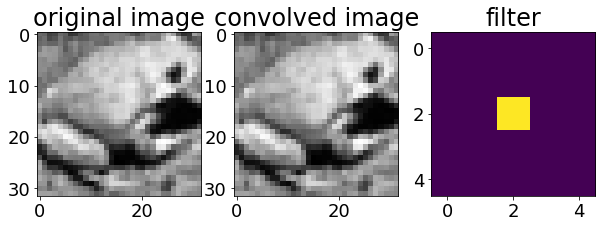

Optimization terminated successfully.
         Current function value: 407.270913
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.3182524  0.69144257 0.12559514]
(5, 5)
Optimization terminated successfully.
         Current function value: 354.855060
         Iterations: 25
         Function evaluations: 8208
Hyperparameters are:
[0.37984944 0.99787257 0.06495752]


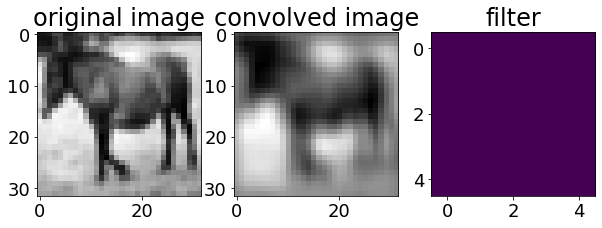

Optimization terminated successfully.
         Current function value: -1085.698812
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.28554056 0.77923874 0.00656736]
(5, 5)
Optimization terminated successfully.
         Current function value: -1087.237591
         Iterations: 18
         Function evaluations: 6747
Hyperparameters are:
[0.23815861 0.18146991 0.0052296 ]


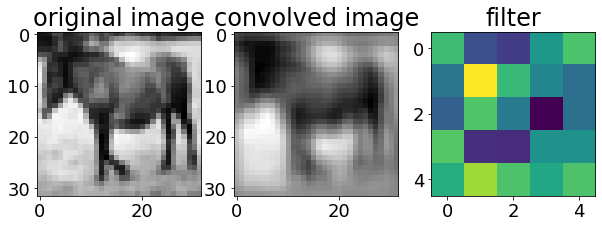

Optimization terminated successfully.
         Current function value: -742.890323
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.22586506 0.86842347 0.02309984]
(5, 5)
Optimization terminated successfully.
         Current function value: -893.070400
         Iterations: 15
         Function evaluations: 5750
Hyperparameters are:
[0.26963888 0.49064888 0.00776294]


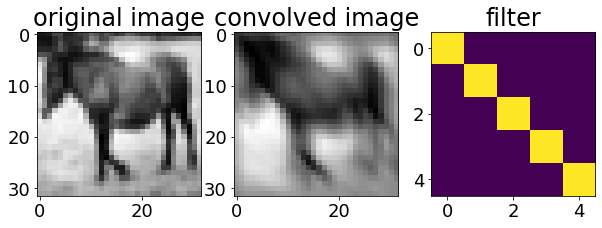

Optimization terminated successfully.
         Current function value: -698.939075
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.30773337 0.72129121 0.01061421]
(5, 5)
Optimization terminated successfully.
         Current function value: -693.523386
         Iterations: 34
         Function evaluations: 12143
Hyperparameters are:
[0.2907441  0.69394002 0.00953433]


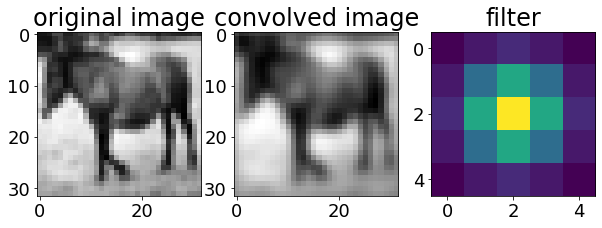

Optimization terminated successfully.
         Current function value: -757.378103
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.24163517 0.81596819 0.00782073]
(5, 5)
Optimization terminated successfully.
         Current function value: -686.446083
         Iterations: 37
         Function evaluations: 14184
Hyperparameters are:
[0.13796993 1.12076851 0.00723796]


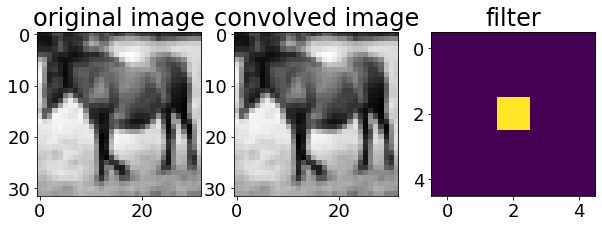

Optimization terminated successfully.
         Current function value: 288.018192
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.26897294 0.75643213 0.07615759]
(5, 5)
Optimization terminated successfully.
         Current function value: 243.091351
         Iterations: 27
         Function evaluations: 8978
Hyperparameters are:
[0.26212084 0.50646121 0.06269967]


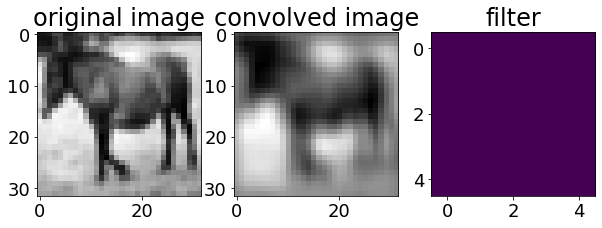

Optimization terminated successfully.
         Current function value: -1363.744696
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.3133358  0.75382952 0.00615857]
(5, 5)
Optimization terminated successfully.
         Current function value: -1358.024438
         Iterations: 13
         Function evaluations: 4979
Hyperparameters are:
[0.25624713 0.28796564 0.00538072]


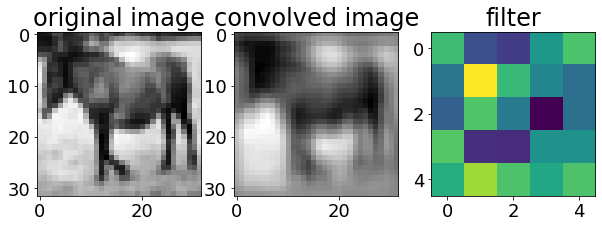

Optimization terminated successfully.
         Current function value: -931.414237
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.22945609 0.83542793 0.02369998]
(5, 5)
Optimization terminated successfully.
         Current function value: -1145.774291
         Iterations: 13
         Function evaluations: 4999
Hyperparameters are:
[0.27312001 0.48564226 0.00699782]


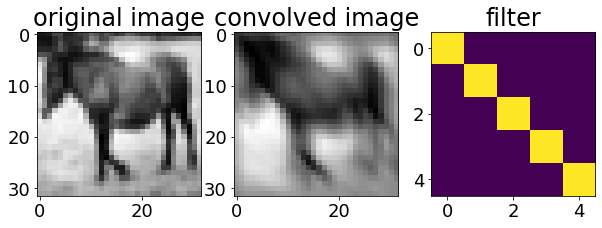

Optimization terminated successfully.
         Current function value: -947.618993
         Iterations: 5
         Function evaluations: 186
Hyperparameters are:
[0.30066781 0.68824108 0.01094459]
(5, 5)
Optimization terminated successfully.
         Current function value: -938.124974
         Iterations: 30
         Function evaluations: 11204
Hyperparameters are:
[0.28160903 1.12853647 0.01088905]


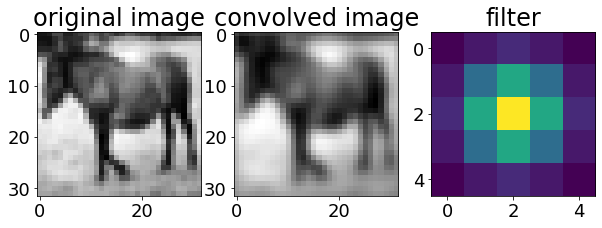

Optimization terminated successfully.
         Current function value: -1054.135332
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.24095556 0.80505889 0.00739165]
(5, 5)
Optimization terminated successfully.
         Current function value: -966.077172
         Iterations: 26
         Function evaluations: 10566
Hyperparameters are:
[0.13902213 2.72284657 0.00700199]


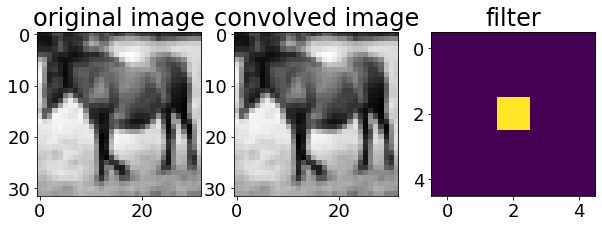

Optimization terminated successfully.
         Current function value: 243.257731
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.27870771 0.71938535 0.06739743]
(5, 5)
Optimization terminated successfully.
         Current function value: 169.317242
         Iterations: 53
         Function evaluations: 17204
Hyperparameters are:
[0.37730846 0.93361022 0.02965065]


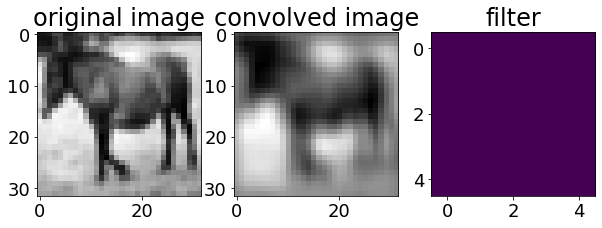

Optimization terminated successfully.
         Current function value: -1679.918373
         Iterations: 6
         Function evaluations: 228
Hyperparameters are:
[0.32643304 0.71757185 0.00592182]
(5, 5)
Optimization terminated successfully.
         Current function value: -1668.562371
         Iterations: 11
         Function evaluations: 4364
Hyperparameters are:
[0.3168966  0.30014606 0.00535597]


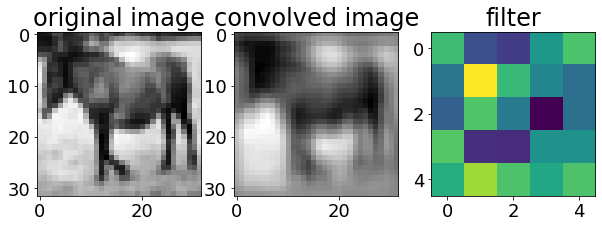

Optimization terminated successfully.
         Current function value: -1134.512717
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.23691297 0.80211991 0.02335386]
(5, 5)
Optimization terminated successfully.
         Current function value: -1420.204428
         Iterations: 18
         Function evaluations: 6816
Hyperparameters are:
[0.27574135 0.43043984 0.00658256]


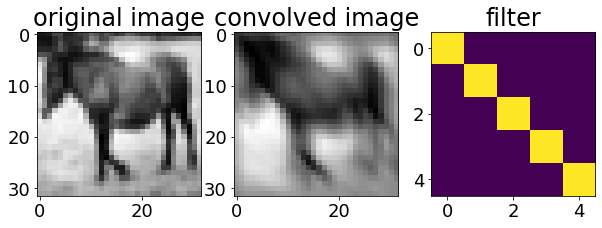

Optimization terminated successfully.
         Current function value: -1219.532814
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.31620495 0.69403146 0.00724707]
(5, 5)
Optimization terminated successfully.
         Current function value: -1210.597859
         Iterations: 28
         Function evaluations: 10603
Hyperparameters are:
[0.30764436 0.4731007  0.00672368]


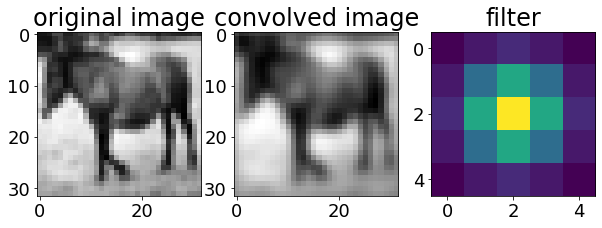

Optimization terminated successfully.
         Current function value: -1313.861630
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.24843535 0.79192174 0.00821632]
(5, 5)
Optimization terminated successfully.
         Current function value: -1241.335615
         Iterations: 40
         Function evaluations: 15740
Hyperparameters are:
[0.14001809 1.77165263 0.00786247]


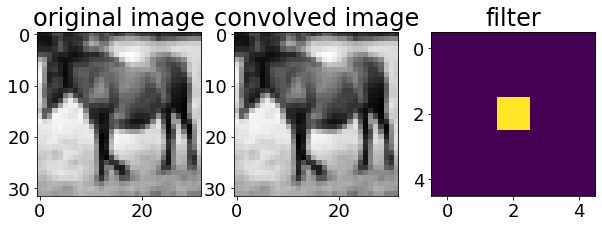

Optimization terminated successfully.
         Current function value: 204.903217
         Iterations: 6
         Function evaluations: 232
Hyperparameters are:
[0.3068669  0.67274678 0.04722685]
(5, 5)
Optimization terminated successfully.
         Current function value: 144.120551
         Iterations: 31
         Function evaluations: 10487
Hyperparameters are:
[0.27035305 0.38622724 0.05955372]


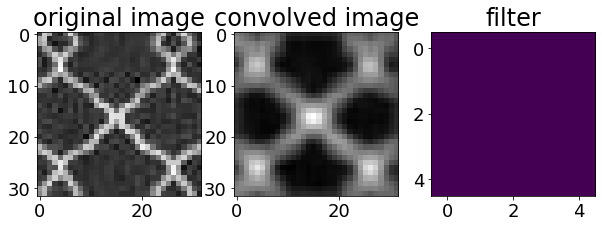

Optimization terminated successfully.
         Current function value: -867.509390
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.52772376 0.77543973 0.009774  ]
(5, 5)
Optimization terminated successfully.
         Current function value: -864.736288
         Iterations: 18
         Function evaluations: 6522
Hyperparameters are:
[0.50162859 0.23928368 0.00547335]


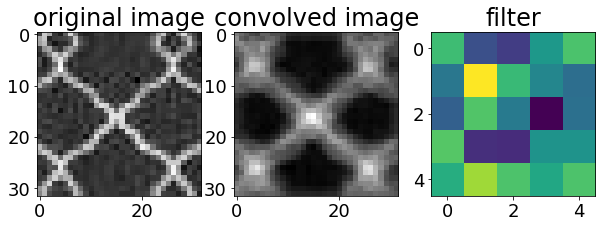

Optimization terminated successfully.
         Current function value: -407.667382
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.40143746 0.76778921 0.058454  ]
(5, 5)
Optimization terminated successfully.
         Current function value: -536.080577
         Iterations: 24
         Function evaluations: 7762
Hyperparameters are:
[0.43858213 0.04696343 0.00703667]


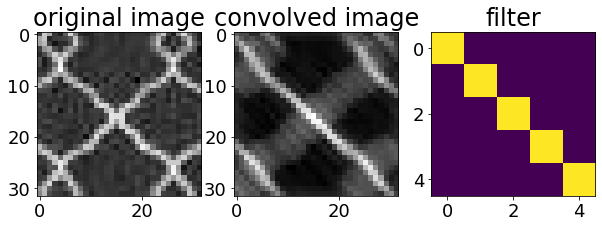

Optimization terminated successfully.
         Current function value: -314.726956
         Iterations: 5
         Function evaluations: 200
Hyperparameters are:
[0.62778417 0.99364543 0.00235661]
(5, 5)
Optimization terminated successfully.
         Current function value: -308.448405
         Iterations: 25
         Function evaluations: 8752
Hyperparameters are:
[0.52382556 0.43284179 0.00078161]


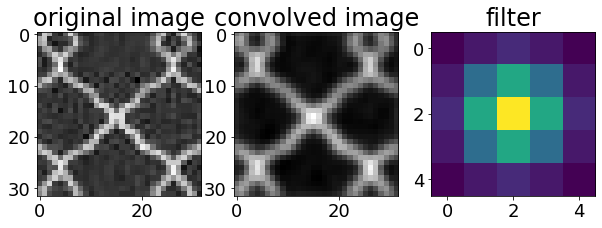

Optimization terminated successfully.
         Current function value: -550.849991
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.54217978 0.92569442 0.0043702 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -595.799222
         Iterations: 25
         Function evaluations: 8747
Hyperparameters are:
[0.23025692 0.91120217 0.00447611]


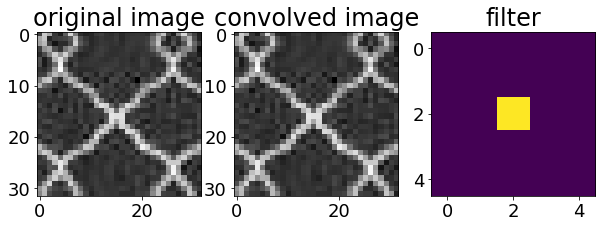

Optimization terminated successfully.
         Current function value: 691.017211
         Iterations: 5
         Function evaluations: 208
Hyperparameters are:
[0.46617527 0.92199497 0.29097133]
(5, 5)
Optimization terminated successfully.
         Current function value: 651.860151
         Iterations: 28
         Function evaluations: 8830
Hyperparameters are:
[0.49301881 0.54904131 0.14248948]


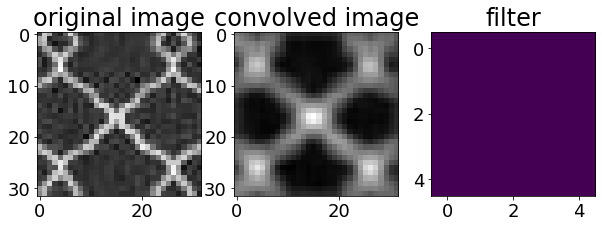

Optimization terminated successfully.
         Current function value: -1128.636377
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.5533312  0.813869   0.00690831]
(5, 5)
Optimization terminated successfully.
         Current function value: -1128.480764
         Iterations: 20
         Function evaluations: 7387
Hyperparameters are:
[0.54922384 0.22866597 0.00105651]


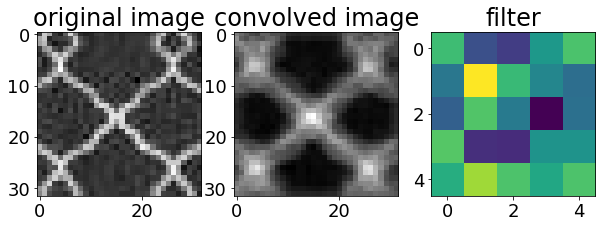

Optimization terminated successfully.
         Current function value: -525.639248
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.44955855 0.82884128 0.05157456]
(5, 5)
Optimization terminated successfully.
         Current function value: -698.618274
         Iterations: 23
         Function evaluations: 7572
Hyperparameters are:
[0.43147838 0.08714161 0.01417977]


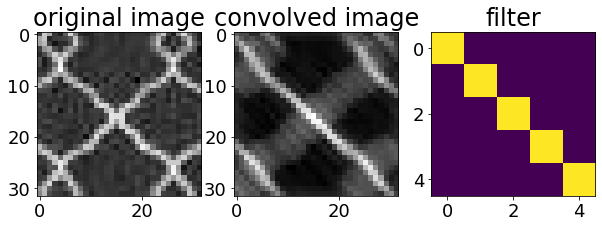

Optimization terminated successfully.
         Current function value: -435.699967
         Iterations: 4
         Function evaluations: 165
Hyperparameters are:
[6.57825365e-01 9.80209409e-01 4.08110010e-04]
(5, 5)
Optimization terminated successfully.
         Current function value: -424.204139
         Iterations: 29
         Function evaluations: 10350
Hyperparameters are:
[0.6202748  0.22438709 0.00204535]


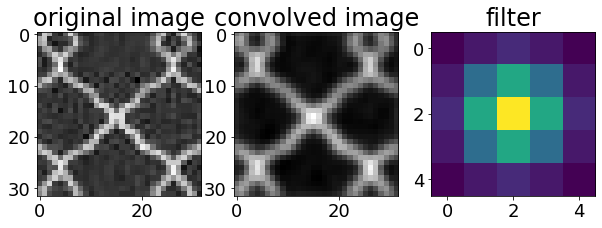

Optimization terminated successfully.
         Current function value: -793.166846
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.56994795 0.92843763 0.00491923]
(5, 5)
Optimization terminated successfully.
         Current function value: -706.099352
         Iterations: 36
         Function evaluations: 12848
Hyperparameters are:
[0.17085294 1.80045123 0.0045148 ]


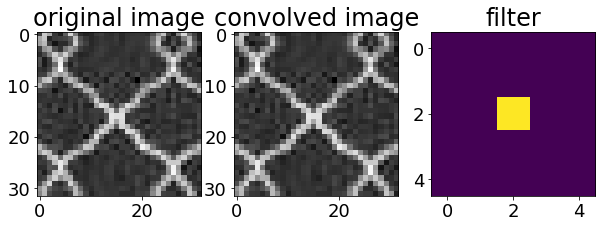

Optimization terminated successfully.
         Current function value: 752.701046
         Iterations: 5
         Function evaluations: 199
Hyperparameters are:
[0.54872809 0.82792468 0.22373617]
(5, 5)
Optimization terminated successfully.
         Current function value: 700.848349
         Iterations: 19
         Function evaluations: 5995
Hyperparameters are:
[0.92601593 0.27398993 0.0599235 ]


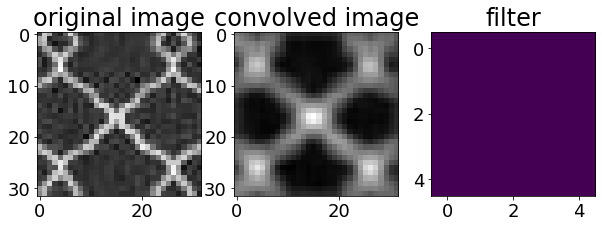

Optimization terminated successfully.
         Current function value: -1417.812383
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.54801806 0.80322608 0.00681636]
(5, 5)
Optimization terminated successfully.
         Current function value: -1424.955098
         Iterations: 19
         Function evaluations: 7054
Hyperparameters are:
[0.54674042 0.2321226  0.00272734]


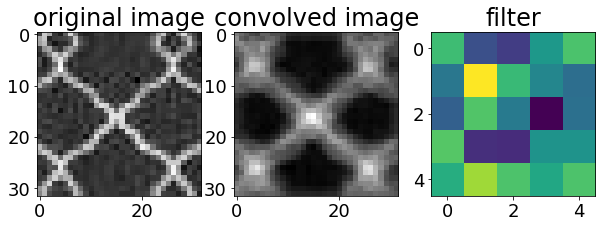

Optimization terminated successfully.
         Current function value: -641.870628
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.44762236 0.82786881 0.0519558 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -880.363314
         Iterations: 27
         Function evaluations: 8919
Hyperparameters are:
[0.55172449 0.08218344 0.00877771]


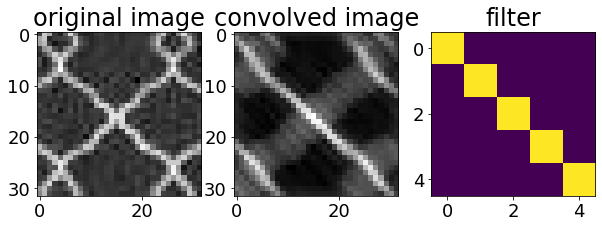

Optimization terminated successfully.
         Current function value: -599.851513
         Iterations: 4
         Function evaluations: 161
Hyperparameters are:
[0.66332643 0.93769384 0.00427831]
(5, 5)
Optimization terminated successfully.
         Current function value: -595.296831
         Iterations: 27
         Function evaluations: 9754
Hyperparameters are:
[0.6470874  0.17535239 0.0009029 ]


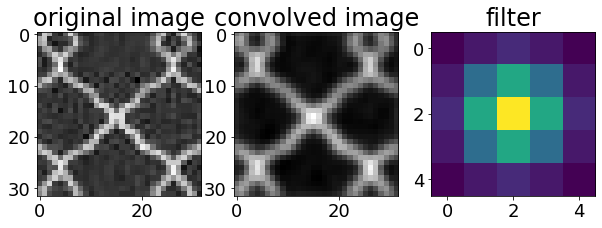

Optimization terminated successfully.
         Current function value: -1062.382527
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.58216878 0.9384477  0.00509016]
(5, 5)
Optimization terminated successfully.
         Current function value: -1102.846765
         Iterations: 24
         Function evaluations: 8535
Hyperparameters are:
[0.24257165 0.89636704 0.00595662]


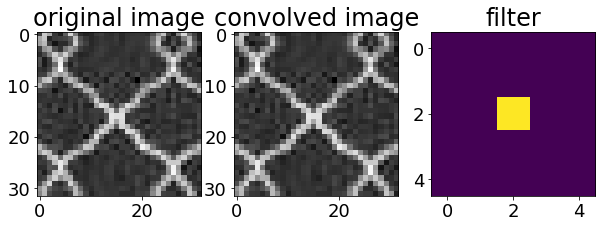

Optimization terminated successfully.
         Current function value: 847.341330
         Iterations: 5
         Function evaluations: 196
Hyperparameters are:
[0.57288603 0.84408729 0.21209779]
(5, 5)
Optimization terminated successfully.
         Current function value: 776.896950
         Iterations: 23
         Function evaluations: 7215
Hyperparameters are:
[0.42468714 0.45215741 0.23724386]


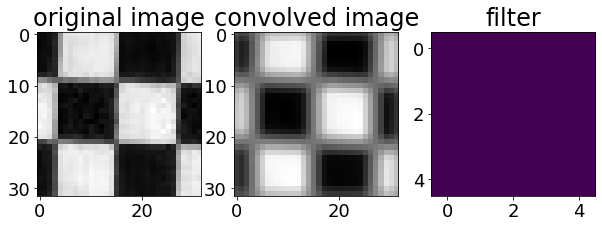

Optimization terminated successfully.
         Current function value: -1026.435900
         Iterations: 9
         Function evaluations: 353
Hyperparameters are:
[0.38053448 0.655409   0.00698578]
(5, 5)
Optimization terminated successfully.
         Current function value: -871.936284
         Iterations: 7
         Function evaluations: 2446
Hyperparameters are:
[0.05686224 0.65753798 0.03221396]


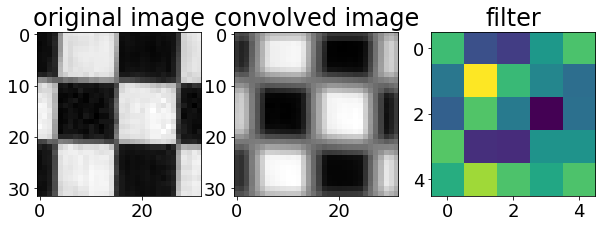

Optimization terminated successfully.
         Current function value: -750.997064
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.18747957 0.78005657 0.02882139]
(5, 5)
Optimization terminated successfully.
         Current function value: -913.415852
         Iterations: 16
         Function evaluations: 5436
Hyperparameters are:
[0.17984325 0.17756102 0.01652673]


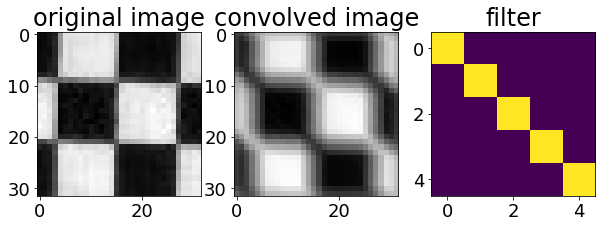

Optimization terminated successfully.
         Current function value: -796.907757
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.18167972 0.70759888 0.02064273]
(5, 5)
Optimization terminated successfully.
         Current function value: -832.076788
         Iterations: 20
         Function evaluations: 6794
Hyperparameters are:
[0.15660569 0.20984008 0.01997834]


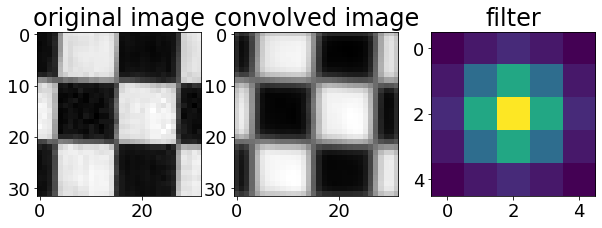

Optimization terminated successfully.
         Current function value: -859.563067
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19031205 0.62850406 0.00959436]
(5, 5)
Optimization terminated successfully.
         Current function value: -936.964611
         Iterations: 37
         Function evaluations: 13631
Hyperparameters are:
[0.16298373 0.42916728 0.00681206]


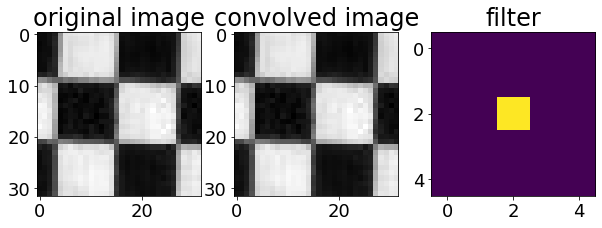

Optimization terminated successfully.
         Current function value: 194.940782
         Iterations: 6
         Function evaluations: 254
Hyperparameters are:
[0.12112573 0.65812916 0.1838446 ]
(5, 5)
Optimization terminated successfully.
         Current function value: 19.936103
         Iterations: 55
         Function evaluations: 19192
Hyperparameters are:
[0.52613795 0.35435138 0.00345518]


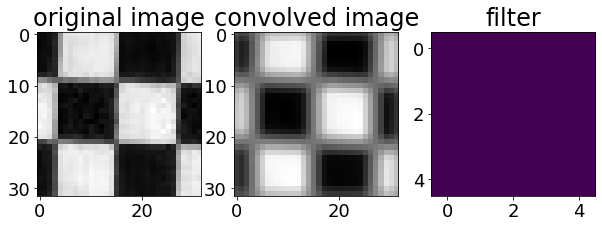

Optimization terminated successfully.
         Current function value: -1309.305743
         Iterations: 8
         Function evaluations: 330
Hyperparameters are:
[0.41922812 0.58435447 0.00578677]
(5, 5)
Optimization terminated successfully.
         Current function value: -1061.409061
         Iterations: 7
         Function evaluations: 2434
Hyperparameters are:
[0.06596423 0.54640785 0.03177995]


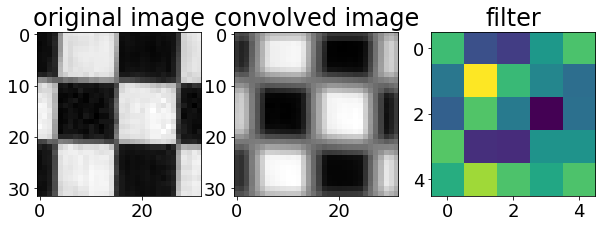

Optimization terminated successfully.
         Current function value: -924.031184
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.18857968 0.75986747 0.02977063]
(5, 5)
Optimization terminated successfully.
         Current function value: -1131.153067
         Iterations: 13
         Function evaluations: 4584
Hyperparameters are:
[0.18697773 0.30698043 0.01700819]


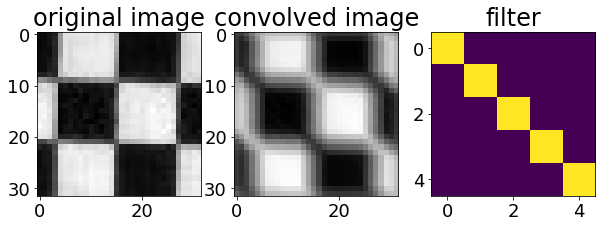

Optimization terminated successfully.
         Current function value: -989.254082
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.19046675 0.67773446 0.0212556 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1013.280916
         Iterations: 23
         Function evaluations: 7999
Hyperparameters are:
[0.1585491  0.47028924 0.02158726]


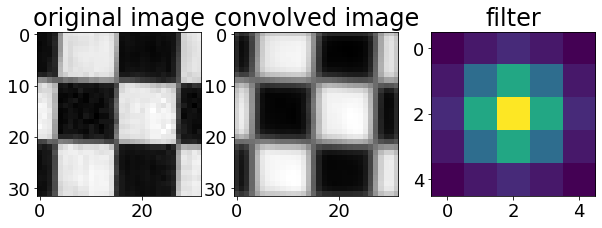

Optimization terminated successfully.
         Current function value: -1160.598816
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.18772868 0.63330177 0.0089233 ]
(5, 5)
Optimization terminated successfully.
         Current function value: -1209.292037
         Iterations: 14
         Function evaluations: 4831
Hyperparameters are:
[0.15894103 0.48914932 0.00756813]


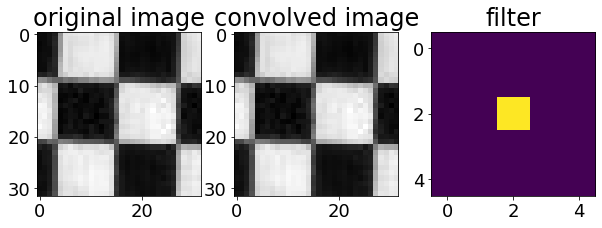

Optimization terminated successfully.
         Current function value: 205.918433
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.15676084 0.62132258 0.16796264]
(5, 5)
Optimization terminated successfully.
         Current function value: -7.548278
         Iterations: 105
         Function evaluations: 34108
Hyperparameters are:
[0.41633281 0.69202057 0.0592333 ]


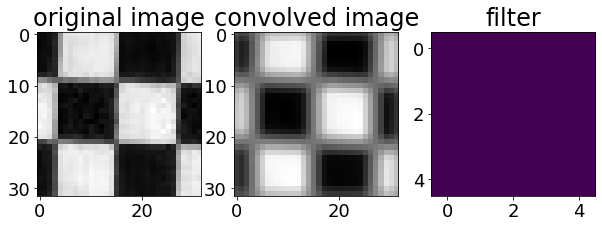

Optimization terminated successfully.
         Current function value: -1628.411647
         Iterations: 7
         Function evaluations: 292
Hyperparameters are:
[0.41393123 0.57912057 0.00567843]
(5, 5)
Optimization terminated successfully.
         Current function value: -1536.624853
         Iterations: 14
         Function evaluations: 5178
Hyperparameters are:
[0.17558196 0.44845358 0.01409024]


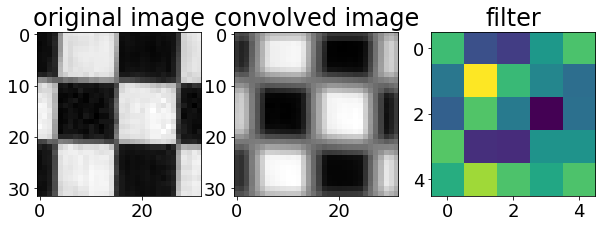

Optimization terminated successfully.
         Current function value: -1121.765570
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.19164907 0.74465608 0.02902875]
(5, 5)
Optimization terminated successfully.
         Current function value: -1371.475391
         Iterations: 13
         Function evaluations: 4673
Hyperparameters are:
[0.19310222 0.315407   0.01655433]


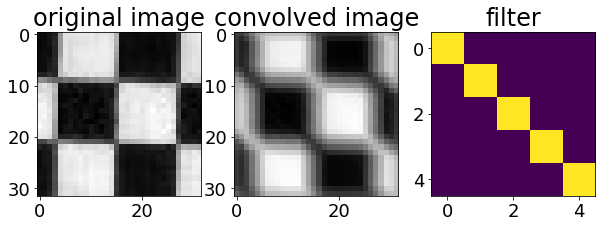

Optimization terminated successfully.
         Current function value: -1203.195708
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.19689805 0.64963802 0.02100416]
(5, 5)
Optimization terminated successfully.
         Current function value: -1219.812036
         Iterations: 21
         Function evaluations: 7294
Hyperparameters are:
[0.17357894 0.40057815 0.02149444]


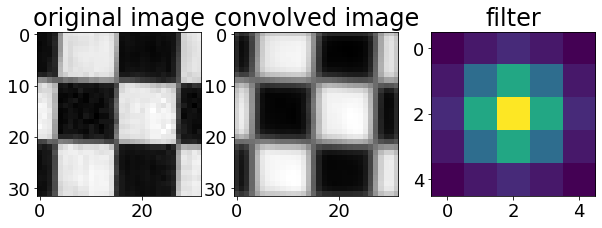

Optimization terminated successfully.
         Current function value: -1425.919461
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.19701516 0.63016246 0.00914958]
(5, 5)
Optimization terminated successfully.
         Current function value: -1471.732706
         Iterations: 31
         Function evaluations: 11526
Hyperparameters are:
[0.16479476 0.70748242 0.00788618]


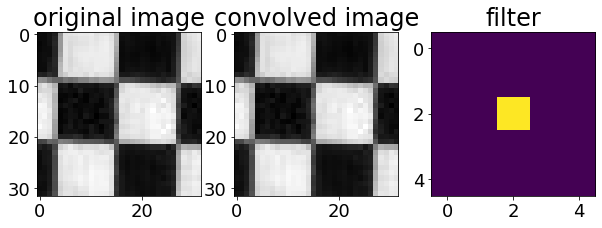

Optimization terminated successfully.
         Current function value: 165.068331
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.17366331 0.60150459 0.14845353]
(5, 5)
Optimization terminated successfully.
         Current function value: -106.857895
         Iterations: 26
         Function evaluations: 9684
Hyperparameters are:
[0.6157517  0.72194066 0.04118358]


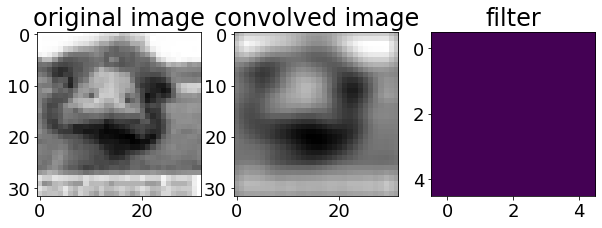

Optimization terminated successfully.
         Current function value: -1072.061620
         Iterations: 5
         Function evaluations: 193
Hyperparameters are:
[0.21866825 0.64224772 0.01219211]
(5, 5)
Optimization terminated successfully.
         Current function value: -1118.314474
         Iterations: 21
         Function evaluations: 7482
Hyperparameters are:
[0.17654246 0.15320678 0.0093026 ]


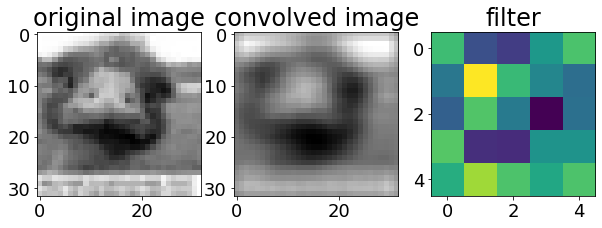

Optimization terminated successfully.
         Current function value: -756.951979
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.19674384 0.78705418 0.02700168]
(5, 5)
Optimization terminated successfully.
         Current function value: -819.189782
         Iterations: 13
         Function evaluations: 4207
Hyperparameters are:
[0.04606802 0.05684659 0.03898077]


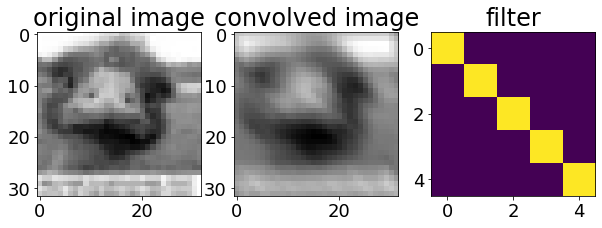

Optimization terminated successfully.
         Current function value: -820.359573
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.21761195 0.596272   0.01654567]
(5, 5)
Optimization terminated successfully.
         Current function value: -844.723611
         Iterations: 27
         Function evaluations: 8930
Hyperparameters are:
[0.19929997 0.09133033 0.0137756 ]


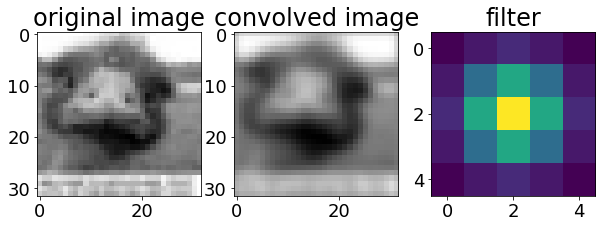

Optimization terminated successfully.
         Current function value: -869.195722
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1802647  0.59606852 0.01048114]
(5, 5)
Optimization terminated successfully.
         Current function value: -899.307390
         Iterations: 15
         Function evaluations: 5063
Hyperparameters are:
[0.14624217 0.2631777  0.00777837]


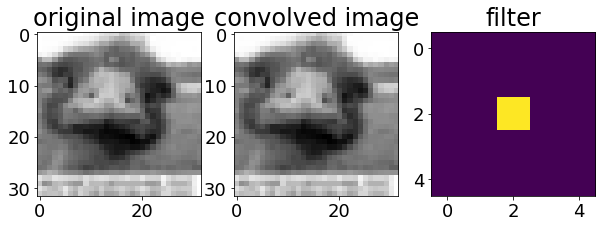

Optimization terminated successfully.
         Current function value: 199.131077
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.12314088 0.60358155 0.18924735]
(5, 5)
Optimization terminated successfully.
         Current function value: 108.708224
         Iterations: 38
         Function evaluations: 12565
Hyperparameters are:
[0.32067145 0.90360088 0.07016462]


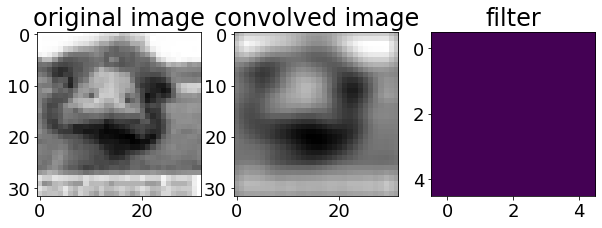

Optimization terminated successfully.
         Current function value: -1366.942361
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.32427751 0.61982091 0.00720285]
(5, 5)
Optimization terminated successfully.
         Current function value: -1395.972922
         Iterations: 22
         Function evaluations: 7898
Hyperparameters are:
[0.18546236 0.22374627 0.0087452 ]


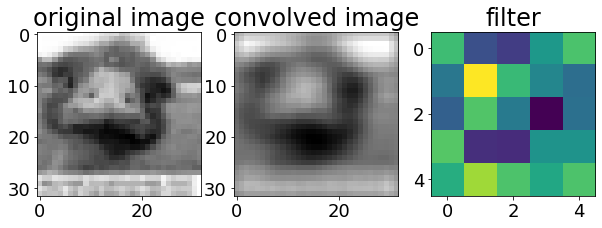

Optimization terminated successfully.
         Current function value: -948.831820
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.19040019 0.73462872 0.02811705]
(5, 5)
Optimization terminated successfully.
         Current function value: -1250.419475
         Iterations: 33
         Function evaluations: 10814
Hyperparameters are:
[0.18749218 0.02809388 0.01129966]


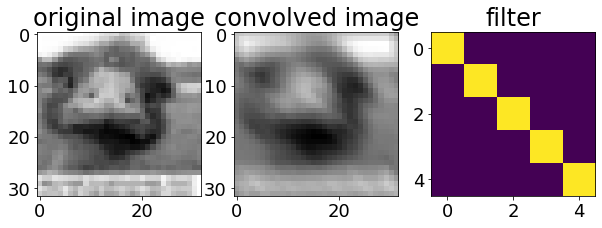

Optimization terminated successfully.
         Current function value: -1039.288083
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.22231437 0.59444056 0.01642621]
(5, 5)
Optimization terminated successfully.
         Current function value: -1055.922479
         Iterations: 20
         Function evaluations: 6793
Hyperparameters are:
[0.21462195 0.08448932 0.0150797 ]


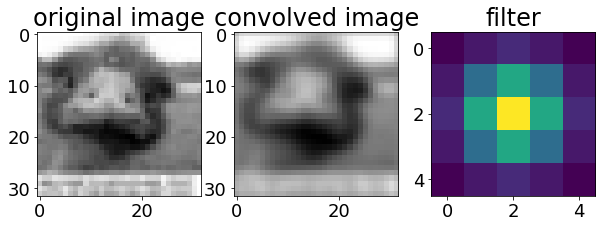

Optimization terminated successfully.
         Current function value: -1156.576674
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.18508443 0.58625    0.00972544]
(5, 5)
Optimization terminated successfully.
         Current function value: -1186.944842
         Iterations: 13
         Function evaluations: 4465
Hyperparameters are:
[0.14604327 0.30637791 0.00778016]


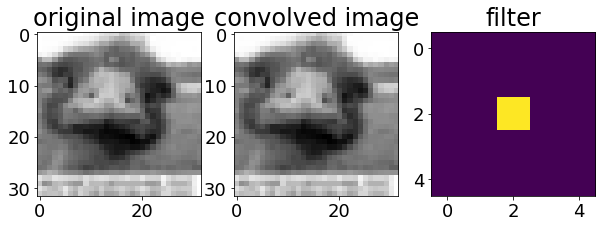

Optimization terminated successfully.
         Current function value: 176.704981
         Iterations: 6
         Function evaluations: 220
Hyperparameters are:
[0.14663663 0.58995727 0.16658198]
(5, 5)
Optimization terminated successfully.
         Current function value: 26.724958
         Iterations: 72
         Function evaluations: 23588
Hyperparameters are:
[0.25700601 1.31346993 0.05434606]


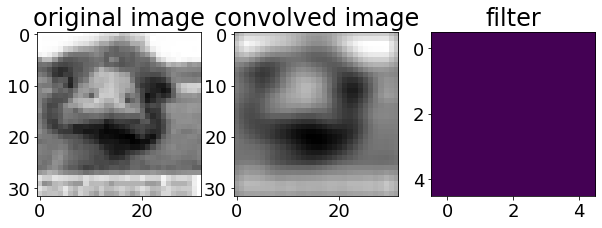

Optimization terminated successfully.
         Current function value: -1660.211387
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.3478242  0.60845432 0.00684957]
(5, 5)
Optimization terminated successfully.
         Current function value: -1685.056975
         Iterations: 19
         Function evaluations: 6695
Hyperparameters are:
[0.19197392 0.11516281 0.00829714]


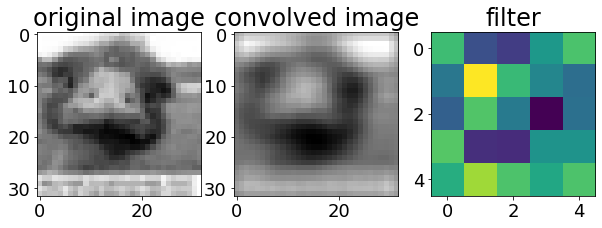

Optimization terminated successfully.
         Current function value: -1136.866892
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.191394   0.70586976 0.02865893]
(5, 5)
Optimization terminated successfully.
         Current function value: -1516.684587
         Iterations: 27
         Function evaluations: 8782
Hyperparameters are:
[0.18845965 0.01363663 0.01162656]


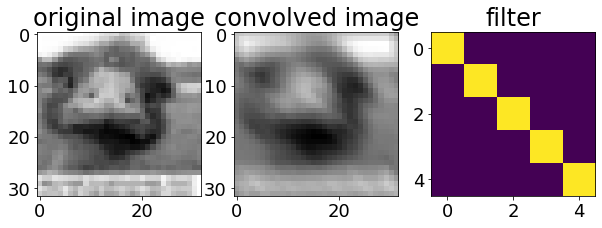

Optimization terminated successfully.
         Current function value: -1262.231480
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.24591547 0.55104398 0.01544998]
(5, 5)
Optimization terminated successfully.
         Current function value: -1272.501939
         Iterations: 29
         Function evaluations: 10075
Hyperparameters are:
[0.28024902 0.0587999  0.0119224 ]


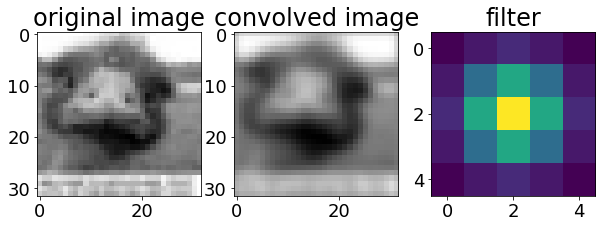

Optimization terminated successfully.
         Current function value: -1421.774043
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.18547815 0.58336798 0.01030758]
(5, 5)
Optimization terminated successfully.
         Current function value: -1458.650063
         Iterations: 11
         Function evaluations: 3791
Hyperparameters are:
[0.14488181 0.37354267 0.00857257]


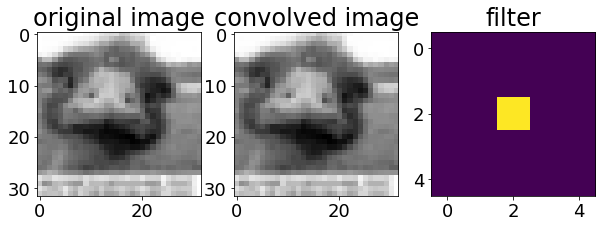

Optimization terminated successfully.
         Current function value: 163.874045
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.23371177 0.57085906 0.11238916]
(5, 5)
Optimization terminated successfully.
         Current function value: 30.683638
         Iterations: 48
         Function evaluations: 15638
Hyperparameters are:
[0.30914119 0.55381284 0.06514193]


In [10]:
names = ['plane', 'bird', 'rider', 'emu', 'swiss_plane', 'frog', 'horse', 'grid', 'chequered', 'emu']
observation_ratios = [0.6, 0.7, 0.8]
filters = ['flat', 'random', 'diag', 'gauss', 'centered']

for n in names:
    for obs in observation_ratios:
        for f in filters:
            experiment_image(n, f, obs)

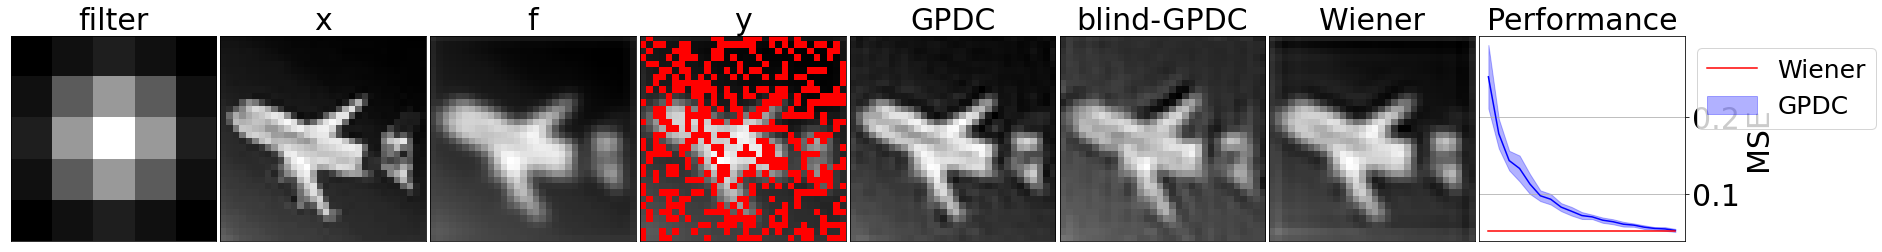

In [11]:
obs_ratio = 6
image_name = 'swiss_plane'; dim = 32; filter_type='gauss'
show_titles = True
# save results
x = np.load("computations/original_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
f = np.load("computations/convoved_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
y =np.load("computations/input_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
obs_idx = np.load("computations/observation_indices_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
h = np.load("computations/filter_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
gpdc = np.load("computations/GPDC_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
blind_gpdc = np.load("computations/blind-GPDC_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))


palette = copy(plt.cm.gray)
palette.set_under('r', 1.)
y_img = -1e3 *np.ones((dim,dim)).reshape(-1)
y_img[obs_idx] = y
y_img = y_img.reshape(dim,dim)


# show data
fig, axes = plt.subplots(1,8, figsize=(30,20))
axes[0].imshow(h, cmap='gray')
axes[1].imshow(x, cmap='gray')
axes[2].imshow(f, cmap='gray')
axes[3].imshow(y_img, cmap=palette,
              norm=colors.Normalize(vmin=np.min(y), vmax=np.max(y)))
axes[4].imshow(gpdc.reshape(dim, dim), cmap='gray')
axes[5].imshow(blind_gpdc.reshape(dim, dim), cmap='gray')


losses = np.load('computations/mse_{}_{}.npy'.format(image_name, filter_type))
mean = losses.mean(axis=0)
error = losses.std(axis=0)
ratios = np.arange(0.1,1.05,0.05)

    
if image_name == 'chequered':
    b = 0.06
elif image_name == 'horse':
    b = 0.008
elif image_name == 'woven':
    b = 0.01
elif image_name == 'emu':
    b = 0.08
elif image_name == 'grid':
    b = 0.002
elif image_name == 'plane':
    b = 0.03
elif image_name == 'bird':
    b = 0.01
elif image_name == 'rider':
    b = 0.02
elif image_name == 'swiss_plane':
    b = 0.01
elif image_name == 'frog':
    b = 0.01
elif image_name == 'horse':
    b = 0.01

wiener_image = restoration.wiener(f, h, balance=b, clip=False )
wiener_error = np.mean(np.abs(wiener_image.reshape(-1) - x.reshape(-1))**2)

axes[6].imshow(wiener_image, cmap='gray')

axes[7].plot(ratios, mean, color='b')
axes[7].plot(ratios, wiener_error * np.ones(len(ratios)), color='r', label='Wiener')
axes[7].fill_between(ratios, mean - error, mean + error, color='b', alpha=0.3, label='GPDC')
axes[7].yaxis.grid()
axes[7].set_yticks([0.1, 0.2])
axes[7].set_yticklabels([0.1, 0.2], fontsize=30)
axes[7].set_xticks([0.25, 0.5, 0.75])
axes[7].set_xticklabels([0.25, 0.5, 0.75], fontsize=30)

axes[7].set_ylabel('MSE', fontsize=30)
axes[7].set_xlabel('observation ratio', fontsize=30)

axes[7].yaxis.tick_right()
axes[7].yaxis.set_label_position("right")

axes[7].legend(bbox_to_anchor=(1.,1.), fontsize=25)

asp = np.diff(axes[7].get_xlim())[0] / np.diff(axes[7].get_ylim())[0]
axes[7].set_aspect(asp)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_xaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[6].get_xaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)

axes[7].get_xaxis().set_visible(False)


if show_titles:
    axes[0].set_title("filter", fontsize=30)
    axes[1].set_title("x", fontsize=30)
    axes[2].set_title("f", fontsize=30)
    axes[3].set_title("y", fontsize=30)
    axes[4].set_title("GPDC", fontsize=30)
    axes[5].set_title("blind-GPDC", fontsize=30)
    axes[6].set_title("Wiener", fontsize=30)
    axes[7].set_title("Performance", fontsize=30)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.02, hspace=.00)
#fig.savefig("figures/{}_{}.pdf".format(image_name, filter_type), bbox_inches='tight')

In [19]:
def experiment_performance(image_name, type_filter):
    seeds = np.arange(20)
    step = 0.05
    ratios = np.arange(0.1,1+step, step)
    losses = np.zeros((len(seeds), len(ratios)))
    dim_w = 5
    dim=32

    for i, r in enumerate(ratios):
        for s in seeds:
            obs_ratio = r
            x, dim = get_image(image_name, dim)

            num_obs = int(dim**2 * obs_ratio)    

            # grey scale
            x = x.reshape(-1, 3)
            # light grey scale : https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm
            x = np.array([0.3, 0.59, 0.11])@x.T
            x -= np.mean(x)
            x /= np.std(x)
            x = x.reshape(dim, dim)
            indices = get_img_indices(x)

            # construct filter
            get_filter(dim_w, type_filter)
            # create convolved image and normalize
            f = signal.convolve2d(x, h, mode='same')
            f = f.reshape(-1)

            obs_idx = np.random.choice(len(indices), num_obs, replace=False)
            y = f[obs_idx] + 0.1*np.std(f)*np.random.randn(len(obs_idx))
            indices_y = indices[obs_idx]
            f = f.reshape(dim,dim)
    
            my_gpc = gpc(indices, indices_y, y.reshape(-1), weights=h)
            my_gpc.train()
            #my_gpc.theta = [0.63583946, 0.90392296, 0.13245443]
            my_gpc.compute_moments()
    
            losses[s,i] = np.mean((x.reshape(-1) - my_gpc.post_mean_x)**2)
        
        
    if image_name == 'chequered':
        b = 0.024
    elif image_name == 'horse':
        b = 0.008
    elif image_name == 'woven':
        b = 0.007
    elif image_name == 'emu':
        b = 0.037
    elif image_name == 'grid':
        b = 0.002
    else:
        b = 0.01

    d = restoration.wiener(f, h, balance=b, clip=False)
    wiener_error = np.mean(np.abs(d.reshape(-1) - x.reshape(-1))**2)


    plt.figure(figsize=(6,4))
    mean = losses.mean(axis=0)
    error = losses.std(axis=0)
    plt.plot(ratios, mean, color='b')
    plt.plot(ratios, wiener_error * np.ones(len(ratios)), color='r', label='Wiener (from f)')
    plt.fill_between(ratios, mean - error, mean + error, color='b', alpha=0.3, label='GPDC (from y)')
    plt.grid('on')
    plt.ylabel('MSE')
    plt.xlabel('observed ratio')
    plt.legend()
    #plt.savefig("figures/MSE_{}.pdf".format(image_name), bbox_inches='tight')
    np.save('computations/mse_{}_{}'.format(image_name, type_filter), losses)

Optimization terminated successfully.
         Current function value: 40.754962
         Iterations: 7
         Function evaluations: 254
Hyperparameters are:
[0.03008912 0.59480758 0.20384731]
Optimization terminated successfully.
         Current function value: 43.406971
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.06531228 0.79684545 0.09815204]
Optimization terminated successfully.
         Current function value: 38.026610
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.0432983  0.61737628 0.15800227]
Optimization terminated successfully.
         Current function value: 40.893868
         Iterations: 7
         Function evaluations: 254
Hyperparameters are:
[0.01651615 0.57117062 0.24235456]
Optimization terminated successfully.
         Current function value: 45.149679
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06805548 0.68264744 0.12366782]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 17.433213
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.10134718 0.70591365 0.08005027]
Optimization terminated successfully.
         Current function value: 14.350417
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.08063843 0.59140238 0.10476876]
Optimization terminated successfully.
         Current function value: 34.337672
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.07837644 0.62192748 0.12762926]
Optimization terminated successfully.
         Current function value: 24.691674
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.06542569 0.56324117 0.13290305]
Optimization terminated successfully.
         Current function value: 18.464608
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.0781902  0.6147949  0.10988973]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -9.620236
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.11458031 0.67026966 0.0977575 ]
Optimization terminated successfully.
         Current function value: -7.633786
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.10158461 0.61611173 0.1100743 ]
Optimization terminated successfully.
         Current function value: -16.715278
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.10141453 0.5948559  0.10677887]
Optimization terminated successfully.
         Current function value: -15.777371
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.09856355 0.6159064  0.10696175]
Optimization terminated successfully.
         Current function value: -6.605450
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.09430253 0.62743559 0.11414571]
Optimization terminated

Optimization terminated successfully.
         Current function value: -77.436110
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.11634953 0.65516956 0.09564641]
Optimization terminated successfully.
         Current function value: -80.712691
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.11346841 0.62314801 0.09688954]
Optimization terminated successfully.
         Current function value: -81.996906
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.11340409 0.61177844 0.09634096]
Optimization terminated successfully.
         Current function value: -69.369871
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09713367 0.6014818  0.10889987]
Optimization terminated successfully.
         Current function value: -71.785007
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.11477414 0.61698767 0.09979997]
Optimization termina

Optimization terminated successfully.
         Current function value: -126.202161
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11854415 0.63584204 0.10166236]
Optimization terminated successfully.
         Current function value: -151.809893
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.12579014 0.59934178 0.09348822]
Optimization terminated successfully.
         Current function value: -130.259493
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.11485735 0.63218742 0.10157476]
Optimization terminated successfully.
         Current function value: -134.872622
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.11922257 0.61499999 0.09996768]
Optimization terminated successfully.
         Current function value: -150.907428
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13206223 0.64578326 0.090779  ]
Optimization te

Optimization terminated successfully.
         Current function value: -199.219792
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13086132 0.62283804 0.09828679]
Optimization terminated successfully.
         Current function value: -209.848256
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13067788 0.63835579 0.09521027]
Optimization terminated successfully.
         Current function value: -192.294907
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14085242 0.6484668  0.09722513]
Optimization terminated successfully.
         Current function value: -204.339903
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1285389  0.61678017 0.09770641]
Optimization terminated successfully.
         Current function value: -204.632966
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12840982 0.63841675 0.09712112]
Optimization te

Optimization terminated successfully.
         Current function value: -286.734557
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.14603079 0.64375429 0.09238815]
Optimization terminated successfully.
         Current function value: -310.144335
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1363113  0.62570834 0.09024612]
Optimization terminated successfully.
         Current function value: -301.427951
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13013372 0.63592876 0.09273016]
Optimization terminated successfully.
         Current function value: -311.887881
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.14886722 0.62128279 0.08803493]
Optimization terminated successfully.
         Current function value: -286.585305
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12766454 0.61601498 0.09651621]
Optimization te

Optimization terminated successfully.
         Current function value: -371.018120
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.1436615  0.63260871 0.09250853]
Optimization terminated successfully.
         Current function value: -383.874773
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14940316 0.63925255 0.08952678]
Optimization terminated successfully.
         Current function value: -357.613308
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13477616 0.61412497 0.09660122]
Optimization terminated successfully.
         Current function value: -369.832652
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.13595947 0.59074123 0.09504661]
Optimization terminated successfully.
         Current function value: -420.505469
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14080179 0.61914137 0.09210489]
Optimization te

Optimization terminated successfully.
         Current function value: -474.279339
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1479236  0.628613   0.08938246]
Optimization terminated successfully.
         Current function value: -470.442178
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14580903 0.63435127 0.08999652]
Optimization terminated successfully.
         Current function value: -537.182083
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15696637 0.61831019 0.08618598]
Optimization terminated successfully.
         Current function value: -492.869912
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15822728 0.61043395 0.09164282]
Optimization terminated successfully.
         Current function value: -500.654444
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14594187 0.61340168 0.09206479]
Optimization te

Optimization terminated successfully.
         Current function value: 42.384320
         Iterations: 4
         Function evaluations: 168
Hyperparameters are:
[0.07217328 0.75750133 0.07747412]
Optimization terminated successfully.
         Current function value: 42.384320
         Iterations: 4
         Function evaluations: 168
Hyperparameters are:
[0.07217328 0.75750133 0.07747412]
Optimization terminated successfully.
         Current function value: 42.384320
         Iterations: 4
         Function evaluations: 168
Hyperparameters are:
[0.07217328 0.75750133 0.07747412]
Optimization terminated successfully.
         Current function value: 42.384320
         Iterations: 4
         Function evaluations: 168
Hyperparameters are:
[0.07217328 0.75750133 0.07747412]
Optimization terminated successfully.
         Current function value: 42.384320
         Iterations: 4
         Function evaluations: 168
Hyperparameters are:
[0.07217328 0.75750133 0.07747412]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 25.582384
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0805859  0.67579241 0.10794461]
Optimization terminated successfully.
         Current function value: 25.582384
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0805859  0.67579241 0.10794461]
Optimization terminated successfully.
         Current function value: 25.582384
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0805859  0.67579241 0.10794461]
Optimization terminated successfully.
         Current function value: 25.582384
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0805859  0.67579241 0.10794461]
Optimization terminated successfully.
         Current function value: 25.582384
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0805859  0.67579241 0.10794461]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -12.220444
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10593825 0.64920532 0.10175121]
Optimization terminated successfully.
         Current function value: -12.220444
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10593825 0.64920532 0.10175121]
Optimization terminated successfully.
         Current function value: -12.220444
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10593825 0.64920532 0.10175121]
Optimization terminated successfully.
         Current function value: -12.220444
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10593825 0.64920532 0.10175121]
Optimization terminated successfully.
         Current function value: -12.220444
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10593825 0.64920532 0.10175121]
Optimization termina

Optimization terminated successfully.
         Current function value: -73.052313
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13279777 0.67175139 0.09122112]
Optimization terminated successfully.
         Current function value: -73.052313
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13279777 0.67175139 0.09122112]
Optimization terminated successfully.
         Current function value: -73.052313
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13279777 0.67175139 0.09122112]
Optimization terminated successfully.
         Current function value: -73.052313
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13279777 0.67175139 0.09122112]
Optimization terminated successfully.
         Current function value: -73.052313
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13279777 0.67175139 0.09122112]
Optimization termina

Optimization terminated successfully.
         Current function value: -157.002142
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12823167 0.64591038 0.09006658]
Optimization terminated successfully.
         Current function value: -157.002142
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12823167 0.64591038 0.09006658]
Optimization terminated successfully.
         Current function value: -157.002142
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12823167 0.64591038 0.09006658]
Optimization terminated successfully.
         Current function value: -157.002142
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12823167 0.64591038 0.09006658]
Optimization terminated successfully.
         Current function value: -157.002142
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12823167 0.64591038 0.09006658]
Optimization te

Optimization terminated successfully.
         Current function value: -227.318240
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13554826 0.63529632 0.09038348]
Optimization terminated successfully.
         Current function value: -227.318240
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13554826 0.63529632 0.09038348]
Optimization terminated successfully.
         Current function value: -227.318240
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13554826 0.63529632 0.09038348]
Optimization terminated successfully.
         Current function value: -227.318240
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13554826 0.63529632 0.09038348]
Optimization terminated successfully.
         Current function value: -227.318240
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13554826 0.63529632 0.09038348]
Optimization te

Optimization terminated successfully.
         Current function value: -305.452744
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14382223 0.63222965 0.08950144]
Optimization terminated successfully.
         Current function value: -305.452744
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14382223 0.63222965 0.08950144]
Optimization terminated successfully.
         Current function value: -305.452744
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14382223 0.63222965 0.08950144]
Optimization terminated successfully.
         Current function value: -305.452744
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14382223 0.63222965 0.08950144]
Optimization terminated successfully.
         Current function value: -305.452744
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14382223 0.63222965 0.08950144]
Optimization te

Optimization terminated successfully.
         Current function value: -385.534872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14106878 0.62967939 0.09073111]
Optimization terminated successfully.
         Current function value: -385.534872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14106878 0.62967939 0.09073111]
Optimization terminated successfully.
         Current function value: -385.534872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14106878 0.62967939 0.09073111]
Optimization terminated successfully.
         Current function value: -385.534872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14106878 0.62967939 0.09073111]
Optimization terminated successfully.
         Current function value: -385.534872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14106878 0.62967939 0.09073111]
Optimization te

Optimization terminated successfully.
         Current function value: -470.552169
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14421685 0.6270527  0.09032117]
Optimization terminated successfully.
         Current function value: -470.552169
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14421685 0.6270527  0.09032117]
Optimization terminated successfully.
         Current function value: -470.552169
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14421685 0.6270527  0.09032117]
Optimization terminated successfully.
         Current function value: -510.099011
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14409044 0.62322983 0.09089244]
Optimization terminated successfully.
         Current function value: -510.099011
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14409044 0.62322983 0.09089244]
Optimization te

Optimization terminated successfully.
         Current function value: -555.754693
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14370951 0.61989358 0.09084596]
Optimization terminated successfully.
         Current function value: 22.576843
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.02450343 0.60215565 0.15305142]
Optimization terminated successfully.
         Current function value: 45.709816
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.06567281 0.80638865 0.11949578]
Optimization terminated successfully.
         Current function value: 51.575969
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06772086 0.6880421  0.14769636]
Optimization terminated successfully.
         Current function value: 38.684402
         Iterations: 7
         Function evaluations: 253
Hyperparameters are:
[0.01839486 0.51440504 0.23220962]
Optimization terminated

Optimization terminated successfully.
         Current function value: 19.979789
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.08592406 0.65744618 0.10029122]
Optimization terminated successfully.
         Current function value: 27.360141
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.08441324 0.69433705 0.1090859 ]
Optimization terminated successfully.
         Current function value: 24.709607
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.07221533 0.61360902 0.12045412]
Optimization terminated successfully.
         Current function value: 18.359066
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.09557653 0.68989961 0.08582985]
Optimization terminated successfully.
         Current function value: 12.081326
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.08109164 0.66401201 0.09962505]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -14.024276
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13665667 0.69632007 0.08466762]
Optimization terminated successfully.
         Current function value: -10.123801
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.13342552 0.68789488 0.08833463]
Optimization terminated successfully.
         Current function value: -9.544225
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.10573509 0.61939953 0.10885322]
Optimization terminated successfully.
         Current function value: -17.327932
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.08833367 0.63084427 0.11006016]
Optimization terminated successfully.
         Current function value: 3.315629
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.10655218 0.66142303 0.11196214]
Optimization terminated

Optimization terminated successfully.
         Current function value: -89.019281
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.09880758 0.61693279 0.0991772 ]
Optimization terminated successfully.
         Current function value: -69.377044
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.11559177 0.6302398  0.09989359]
Optimization terminated successfully.
         Current function value: -101.548847
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1094296  0.61175582 0.09063013]
Optimization terminated successfully.
         Current function value: -67.680939
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10421132 0.59943104 0.10638746]
Optimization terminated successfully.
         Current function value: -58.939218
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.13407509 0.66600994 0.09648062]
Optimization termin

Optimization terminated successfully.
         Current function value: -155.235333
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11026326 0.62538753 0.09604712]
Optimization terminated successfully.
         Current function value: -136.892733
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.13074845 0.63279748 0.09570678]
Optimization terminated successfully.
         Current function value: -156.117393
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1288444  0.65280077 0.08913172]
Optimization terminated successfully.
         Current function value: -152.909409
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.11944235 0.62842637 0.09406124]
Optimization terminated successfully.
         Current function value: -144.229565
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.12473903 0.62382272 0.09499693]
Optimization te

Optimization terminated successfully.
         Current function value: -224.087855
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.12527429 0.63946057 0.09334958]
Optimization terminated successfully.
         Current function value: -222.674726
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12756566 0.62306033 0.09374396]
Optimization terminated successfully.
         Current function value: -208.615907
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13069018 0.63717226 0.09543818]
Optimization terminated successfully.
         Current function value: -229.751402
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15563116 0.65089671 0.08609337]
Optimization terminated successfully.
         Current function value: -221.407278
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11763156 0.62286695 0.09621219]
Optimization te

Optimization terminated successfully.
         Current function value: -306.045043
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13880103 0.63213362 0.09028884]
Optimization terminated successfully.
         Current function value: -321.466094
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.14024382 0.62854493 0.08753893]
Optimization terminated successfully.
         Current function value: -280.513799
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13915464 0.65129655 0.09436108]
Optimization terminated successfully.
         Current function value: -297.988706
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.13318677 0.6230282  0.093418  ]
Optimization terminated successfully.
         Current function value: -269.321334
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.13552239 0.63940284 0.09761096]
Optimization te

Optimization terminated successfully.
         Current function value: -375.769332
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.12685377 0.58668939 0.09571986]
Optimization terminated successfully.
         Current function value: -382.767133
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12263787 0.60613844 0.09489066]
Optimization terminated successfully.
         Current function value: -391.924825
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15496536 0.62429766 0.08805291]
Optimization terminated successfully.
         Current function value: -363.659545
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1522682  0.62085309 0.09281633]
Optimization terminated successfully.
         Current function value: -398.598599
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14929531 0.62287241 0.08774679]
Optimization te

Optimization terminated successfully.
         Current function value: -461.423650
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16296592 0.64259989 0.0888079 ]
Optimization terminated successfully.
         Current function value: -455.884715
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13620266 0.62611145 0.09347219]
Optimization terminated successfully.
         Current function value: -453.994222
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15701693 0.63674183 0.09069622]
Optimization terminated successfully.
         Current function value: -504.208671
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.13930715 0.62252935 0.09230036]
Optimization terminated successfully.
         Current function value: -498.412667
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15477945 0.64027151 0.0906367 ]
Optimization te

Optimization terminated successfully.
         Current function value: -552.895069
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15081745 0.62212434 0.09026245]
Optimization terminated successfully.
         Current function value: 35.651017
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.05464628 0.5405073  0.13253605]
Optimization terminated successfully.
         Current function value: 36.300173
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.05239588 0.65177025 0.12903933]
Optimization terminated successfully.
         Current function value: 27.099410
         Iterations: 5
         Function evaluations: 180
Hyperparameters are:
[0.01264119 0.64035279 0.20957228]
Optimization terminated successfully.
         Current function value: 51.346685
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.06275015 0.66689038 0.14711038]
Optimization terminated

Optimization terminated successfully.
         Current function value: 36.059187
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.08485233 0.62655049 0.12233073]
Optimization terminated successfully.
         Current function value: 12.234337
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.07641764 0.61109199 0.10716255]
Optimization terminated successfully.
         Current function value: 14.888587
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.07514164 0.66129688 0.10724423]
Optimization terminated successfully.
         Current function value: 19.163264
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.0801555  0.60438273 0.10946855]
Optimization terminated successfully.
         Current function value: 36.961519
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.08138444 0.63160008 0.12446896]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -10.368830
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.095593   0.65422986 0.10875878]
Optimization terminated successfully.
         Current function value: -7.833883
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.11817975 0.65093116 0.10008729]
Optimization terminated successfully.
         Current function value: -20.421169
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.10661228 0.62708949 0.0990791 ]
Optimization terminated successfully.
         Current function value: -9.746808
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.09057612 0.60641432 0.11458649]
Optimization terminated successfully.
         Current function value: -10.621483
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1155399  0.65191011 0.0985038 ]
Optimization terminate

Optimization terminated successfully.
         Current function value: -80.370398
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.10513047 0.61933249 0.09982029]
Optimization terminated successfully.
         Current function value: -63.070654
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.11288825 0.62491049 0.10372495]
Optimization terminated successfully.
         Current function value: -99.165316
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.09483918 0.61565095 0.09706183]
Optimization terminated successfully.
         Current function value: -64.171552
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.11985345 0.63988176 0.10018575]
Optimization terminated successfully.
         Current function value: -54.251111
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12014467 0.67236116 0.10285656]
Optimization termina

Optimization terminated successfully.
         Current function value: -157.227017
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.11930771 0.61111087 0.09412007]
Optimization terminated successfully.
         Current function value: -131.381001
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13173509 0.64104609 0.09625844]
Optimization terminated successfully.
         Current function value: -140.189174
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12144485 0.62771099 0.0977348 ]
Optimization terminated successfully.
         Current function value: -153.372978
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.12731303 0.6072542  0.09277924]
Optimization terminated successfully.
         Current function value: -139.841658
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.12815297 0.6552943  0.09407286]
Optimization te

Optimization terminated successfully.
         Current function value: -243.244219
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1246924  0.62688539 0.08970642]
Optimization terminated successfully.
         Current function value: -232.616886
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.12734892 0.64416925 0.09084259]
Optimization terminated successfully.
         Current function value: -215.695325
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12824799 0.61564131 0.09543388]
Optimization terminated successfully.
         Current function value: -215.060247
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.12125296 0.63732494 0.09615022]
Optimization terminated successfully.
         Current function value: -208.210853
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12551823 0.64329039 0.09654733]
Optimization te

Optimization terminated successfully.
         Current function value: -306.729573
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.12515666 0.62045883 0.09311437]
Optimization terminated successfully.
         Current function value: -280.836688
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12986432 0.61124098 0.09728303]
Optimization terminated successfully.
         Current function value: -311.632000
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.13439176 0.63765682 0.08992627]
Optimization terminated successfully.
         Current function value: -281.612651
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.13948093 0.63333631 0.09498221]
Optimization terminated successfully.
         Current function value: -307.280535
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15268795 0.63569015 0.08765674]
Optimization te

Optimization terminated successfully.
         Current function value: -379.129094
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14082368 0.64937822 0.0912863 ]
Optimization terminated successfully.
         Current function value: -376.591587
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1366069  0.62180678 0.09313522]
Optimization terminated successfully.
         Current function value: -359.217385
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.14212214 0.6234099  0.09494206]
Optimization terminated successfully.
         Current function value: -367.619257
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12818902 0.59825545 0.09646026]
Optimization terminated successfully.
         Current function value: -374.684006
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15358088 0.63645114 0.09051285]
Optimization te

Optimization terminated successfully.
         Current function value: -438.751437
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.1354405  0.61690461 0.09613738]
Optimization terminated successfully.
         Current function value: -439.406966
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14706432 0.62839748 0.09411074]
Optimization terminated successfully.
         Current function value: -451.614596
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14628786 0.65282868 0.0920194 ]
Optimization terminated successfully.
         Current function value: -521.327973
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14214223 0.63289439 0.08956627]
Optimization terminated successfully.
         Current function value: -537.416328
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15499239 0.62078467 0.08633752]
Optimization te

Optimization terminated successfully.
         Current function value: -562.431815
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15670385 0.62236974 0.08849546]
Optimization terminated successfully.
         Current function value: 41.076351
         Iterations: 6
         Function evaluations: 218
Hyperparameters are:
[0.01966991 0.59032781 0.22859825]
Optimization terminated successfully.
         Current function value: 39.217109
         Iterations: 3
         Function evaluations: 104
Hyperparameters are:
[0.06056389 0.64591596 0.11511697]
Optimization terminated successfully.
         Current function value: 19.684807
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.02526862 0.61209309 0.14670319]
Optimization terminated successfully.
         Current function value: 42.609021
         Iterations: 7
         Function evaluations: 272
Hyperparameters are:
[0.01595677 0.62592443 0.24430017]
Optimization terminated

Optimization terminated successfully.
         Current function value: 23.542035
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.09092227 0.63179993 0.10780117]
Optimization terminated successfully.
         Current function value: 30.910961
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09798887 0.63515962 0.10818092]
Optimization terminated successfully.
         Current function value: 22.185866
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.07664838 0.64931996 0.11247029]
Optimization terminated successfully.
         Current function value: 18.986270
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.08089359 0.61631458 0.10800239]
Optimization terminated successfully.
         Current function value: 14.818628
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.08528717 0.59828786 0.09946705]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -8.830417
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.08903851 0.61012375 0.11542952]
Optimization terminated successfully.
         Current function value: -21.971189
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.09601855 0.64365173 0.10160885]
Optimization terminated successfully.
         Current function value: -11.722777
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10567231 0.63189801 0.10358575]
Optimization terminated successfully.
         Current function value: -13.941513
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.10881261 0.63548792 0.101938  ]
Optimization terminated successfully.
         Current function value: -40.603009
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.07275442 0.56828406 0.10820836]
Optimization terminat

Optimization terminated successfully.
         Current function value: -76.189986
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.1192628  0.63603838 0.09574698]
Optimization terminated successfully.
         Current function value: -86.254215
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.13026714 0.65242844 0.08830166]
Optimization terminated successfully.
         Current function value: -65.672098
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12258674 0.66033692 0.09787236]
Optimization terminated successfully.
         Current function value: -83.763915
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.12186999 0.62498536 0.09262576]
Optimization terminated successfully.
         Current function value: -91.445459
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.12303128 0.64717668 0.08807803]
Optimization termina

Optimization terminated successfully.
         Current function value: -143.309515
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13439921 0.67625725 0.09039876]
Optimization terminated successfully.
         Current function value: -175.854232
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.14586534 0.68195759 0.07915319]
Optimization terminated successfully.
         Current function value: -146.302109
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.12666998 0.63463917 0.09371912]
Optimization terminated successfully.
         Current function value: -145.188673
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11438522 0.61478815 0.09837659]
Optimization terminated successfully.
         Current function value: -159.463001
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11155015 0.59863906 0.09605125]
Optimization te

Optimization terminated successfully.
         Current function value: -236.745663
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13561542 0.60622053 0.08939648]
Optimization terminated successfully.
         Current function value: -214.494823
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12690261 0.63716238 0.09524406]
Optimization terminated successfully.
         Current function value: -232.036868
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13728979 0.65031498 0.08858812]
Optimization terminated successfully.
         Current function value: -233.243943
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12932681 0.62070451 0.09117515]
Optimization terminated successfully.
         Current function value: -194.100619
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12978718 0.64039138 0.09924464]
Optimization te

Optimization terminated successfully.
         Current function value: -283.999493
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15007345 0.64238243 0.0922578 ]
Optimization terminated successfully.
         Current function value: -291.705995
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12834369 0.62536884 0.0952701 ]
Optimization terminated successfully.
         Current function value: -303.802686
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13750345 0.61456871 0.09141036]
Optimization terminated successfully.
         Current function value: -289.925015
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14155046 0.62672403 0.09304619]
Optimization terminated successfully.
         Current function value: -281.702332
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.14036232 0.66350736 0.09376628]
Optimization te

Optimization terminated successfully.
         Current function value: -378.865441
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14595219 0.63886089 0.09090368]
Optimization terminated successfully.
         Current function value: -374.194910
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14697596 0.62261993 0.09181968]
Optimization terminated successfully.
         Current function value: -390.342562
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13624289 0.61281108 0.09116694]
Optimization terminated successfully.
         Current function value: -404.629472
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13129389 0.60387734 0.09008458]
Optimization terminated successfully.
         Current function value: -390.250470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14961715 0.65593059 0.08808597]
Optimization te

Optimization terminated successfully.
         Current function value: -452.067860
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.13504714 0.62802051 0.09411474]
Optimization terminated successfully.
         Current function value: -479.532198
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13747509 0.60465722 0.09067278]
Optimization terminated successfully.
         Current function value: -472.710135
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14707523 0.61395161 0.09004191]
Optimization terminated successfully.
         Current function value: -494.364652
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.14140962 0.62627603 0.08771693]
Optimization terminated successfully.
         Current function value: -480.970612
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.13735183 0.61734085 0.09562408]
Optimization te

Optimization terminated successfully.
         Current function value: -558.197637
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15225673 0.62275808 0.08947387]
Optimization terminated successfully.
         Current function value: -548.704373
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13436261 0.61336728 0.09301622]
Optimization terminated successfully.
         Current function value: 58.776362
         Iterations: 14
         Function evaluations: 537
Hyperparameters are:
[0.15003052 0.92477661 0.00233809]
Optimization terminated successfully.
         Current function value: 61.372404
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.07995181 0.76045341 0.1525815 ]
Optimization terminated successfully.
         Current function value: 54.472678
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09375221 0.74770439 0.1094348 ]
Optimization termina

Optimization terminated successfully.
         Current function value: 49.259484
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10511181 0.68407253 0.12440608]
Optimization terminated successfully.
         Current function value: 50.037730
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.15630074 0.79285299 0.08162957]
Optimization terminated successfully.
         Current function value: 54.473615
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12576472 0.77603    0.10421209]
Optimization terminated successfully.
         Current function value: 52.532597
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.12382917 0.78107186 0.10256941]
Optimization terminated successfully.
         Current function value: 48.704627
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.14883951 0.74567885 0.08850317]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 23.068736
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.20273665 0.8154682  0.08249518]
Optimization terminated successfully.
         Current function value: 25.249363
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.20049658 0.89099671 0.07827415]
Optimization terminated successfully.
         Current function value: 20.114544
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.19161514 0.81574963 0.08047526]
Optimization terminated successfully.
         Current function value: 35.477209
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20138153 0.84073822 0.08813951]
Optimization terminated successfully.
         Current function value: 8.038959
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.18719169 0.8058712  0.07566807]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -28.502300
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.18343084 0.75716198 0.09119387]
Optimization terminated successfully.
         Current function value: -33.027823
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.19942989 0.77817415 0.08647886]
Optimization terminated successfully.
         Current function value: -32.883011
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.20572371 0.78425862 0.08548105]
Optimization terminated successfully.
         Current function value: -27.058143
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.20739035 0.8009607  0.08529427]
Optimization terminated successfully.
         Current function value: -21.834369
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.15675228 0.76068099 0.1007149 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -102.550386
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.22633649 0.76471147 0.08295939]
Optimization terminated successfully.
         Current function value: -103.139099
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18561315 0.78036421 0.0877772 ]
Optimization terminated successfully.
         Current function value: -103.536928
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.21077114 0.79573924 0.08341904]
Optimization terminated successfully.
         Current function value: -124.767552
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19845376 0.7987485  0.0784054 ]
Optimization terminated successfully.
         Current function value: -91.829023
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.20253585 0.77312706 0.08912418]
Optimization ter

Optimization terminated successfully.
         Current function value: -185.900524
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21688467 0.79073917 0.08148789]
Optimization terminated successfully.
         Current function value: -162.757647
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.23227038 0.81319272 0.08479112]
Optimization terminated successfully.
         Current function value: -182.787519
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2041233  0.75065682 0.08558801]
Optimization terminated successfully.
         Current function value: -174.996490
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1940372  0.78180726 0.08729093]
Optimization terminated successfully.
         Current function value: -183.646140
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.23502558 0.79028831 0.079998  ]
Optimization te

Optimization terminated successfully.
         Current function value: -282.944374
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25231761 0.81271587 0.07530738]
Optimization terminated successfully.
         Current function value: -277.731812
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.24312696 0.79240975 0.07759004]
Optimization terminated successfully.
         Current function value: -279.842689
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20043876 0.76192047 0.08252692]
Optimization terminated successfully.
         Current function value: -270.969334
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22774754 0.77401249 0.0806341 ]
Optimization terminated successfully.
         Current function value: -274.685504
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21774151 0.77291487 0.08089021]
Optimization te

Optimization terminated successfully.
         Current function value: -380.808099
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.22609953 0.7767705  0.0778566 ]
Optimization terminated successfully.
         Current function value: -367.975576
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24575111 0.79756344 0.07754158]
Optimization terminated successfully.
         Current function value: -345.979245
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.25289476 0.80435285 0.08027032]
Optimization terminated successfully.
         Current function value: -396.288157
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.24393903 0.79206181 0.07374767]
Optimization terminated successfully.
         Current function value: -343.392046
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.22161197 0.78211634 0.0835905 ]
Optimization te

Optimization terminated successfully.
         Current function value: -451.466872
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22631185 0.78445656 0.08068484]
Optimization terminated successfully.
         Current function value: -465.188189
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25802664 0.77706556 0.07692179]
Optimization terminated successfully.
         Current function value: -444.466864
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.25053472 0.7897816  0.07974687]
Optimization terminated successfully.
         Current function value: -426.839767
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24315851 0.78501499 0.08259887]
Optimization terminated successfully.
         Current function value: -464.364496
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24460971 0.79615326 0.07739773]
Optimization te

Optimization terminated successfully.
         Current function value: -583.120294
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25159157 0.77771774 0.07514445]
Optimization terminated successfully.
         Current function value: -561.151879
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25185337 0.80163134 0.07697569]
Optimization terminated successfully.
         Current function value: -524.136713
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24572799 0.7941675  0.08161487]
Optimization terminated successfully.
         Current function value: 60.585982
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.12968899 0.85061392 0.05573969]
Optimization terminated successfully.
         Current function value: 60.585982
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.12968899 0.85061392 0.05573969]
Optimization termin

Optimization terminated successfully.
         Current function value: 63.665925
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.13097994 0.78709545 0.09783491]
Optimization terminated successfully.
         Current function value: 58.502385
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.17420968 0.80079202 0.08034628]
Optimization terminated successfully.
         Current function value: 58.502385
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.17420968 0.80079202 0.08034628]
Optimization terminated successfully.
         Current function value: 58.502385
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.17420968 0.80079202 0.08034628]
Optimization terminated successfully.
         Current function value: 58.502385
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.17420968 0.80079202 0.08034628]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 4.916806
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.16606784 0.77765908 0.07942172]
Optimization terminated successfully.
         Current function value: 4.916806
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.16606784 0.77765908 0.07942172]
Optimization terminated successfully.
         Current function value: 4.916806
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.16606784 0.77765908 0.07942172]
Optimization terminated successfully.
         Current function value: 4.916806
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.16606784 0.77765908 0.07942172]
Optimization terminated successfully.
         Current function value: 4.916806
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.16606784 0.77765908 0.07942172]
Optimization terminated succes

Optimization terminated successfully.
         Current function value: -76.546000
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18140544 0.75275314 0.07316238]
Optimization terminated successfully.
         Current function value: -76.546000
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18140544 0.75275314 0.07316238]
Optimization terminated successfully.
         Current function value: -76.546000
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18140544 0.75275314 0.07316238]
Optimization terminated successfully.
         Current function value: -76.546000
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18140544 0.75275314 0.07316238]
Optimization terminated successfully.
         Current function value: -76.546000
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18140544 0.75275314 0.07316238]
Optimization termina

Optimization terminated successfully.
         Current function value: -140.677040
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21076066 0.76912089 0.07370744]
Optimization terminated successfully.
         Current function value: -140.677040
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21076066 0.76912089 0.07370744]
Optimization terminated successfully.
         Current function value: -140.677040
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21076066 0.76912089 0.07370744]
Optimization terminated successfully.
         Current function value: -140.677040
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21076066 0.76912089 0.07370744]
Optimization terminated successfully.
         Current function value: -140.677040
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21076066 0.76912089 0.07370744]
Optimization te

Optimization terminated successfully.
         Current function value: -214.307709
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22070201 0.76192567 0.07563594]
Optimization terminated successfully.
         Current function value: -214.307709
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22070201 0.76192567 0.07563594]
Optimization terminated successfully.
         Current function value: -214.307709
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22070201 0.76192567 0.07563594]
Optimization terminated successfully.
         Current function value: -214.307709
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22070201 0.76192567 0.07563594]
Optimization terminated successfully.
         Current function value: -214.307709
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22070201 0.76192567 0.07563594]
Optimization te

Optimization terminated successfully.
         Current function value: -305.942179
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.24336268 0.77676744 0.07298187]
Optimization terminated successfully.
         Current function value: -305.942179
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.24336268 0.77676744 0.07298187]
Optimization terminated successfully.
         Current function value: -305.942179
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.24336268 0.77676744 0.07298187]
Optimization terminated successfully.
         Current function value: -305.942179
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.24336268 0.77676744 0.07298187]
Optimization terminated successfully.
         Current function value: -305.942179
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.24336268 0.77676744 0.07298187]
Optimization te

Optimization terminated successfully.
         Current function value: -372.939763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25737715 0.77986065 0.07644138]
Optimization terminated successfully.
         Current function value: -372.939763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25737715 0.77986065 0.07644138]
Optimization terminated successfully.
         Current function value: -372.939763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25737715 0.77986065 0.07644138]
Optimization terminated successfully.
         Current function value: -372.939763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25737715 0.77986065 0.07644138]
Optimization terminated successfully.
         Current function value: -372.939763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25737715 0.77986065 0.07644138]
Optimization te

Optimization terminated successfully.
         Current function value: -465.477554
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25730365 0.77923709 0.07678846]
Optimization terminated successfully.
         Current function value: -465.477554
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25730365 0.77923709 0.07678846]
Optimization terminated successfully.
         Current function value: -465.477554
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25730365 0.77923709 0.07678846]
Optimization terminated successfully.
         Current function value: -465.477554
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25730365 0.77923709 0.07678846]
Optimization terminated successfully.
         Current function value: -465.477554
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25730365 0.77923709 0.07678846]
Optimization te

Optimization terminated successfully.
         Current function value: -562.772226
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26671144 0.77587195 0.07652935]
Optimization terminated successfully.
         Current function value: -562.772226
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26671144 0.77587195 0.07652935]
Optimization terminated successfully.
         Current function value: -562.772226
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26671144 0.77587195 0.07652935]
Optimization terminated successfully.
         Current function value: -562.772226
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26671144 0.77587195 0.07652935]
Optimization terminated successfully.
         Current function value: 65.243969
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12232767 0.85826524 0.1043475 ]
Optimization term

Optimization terminated successfully.
         Current function value: 68.436588
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.12487099 0.75415833 0.12285029]
Optimization terminated successfully.
         Current function value: 52.867574
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.10000027 0.64672075 0.12377305]
Optimization terminated successfully.
         Current function value: 60.703630
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.15328053 0.7702539  0.10237783]
Optimization terminated successfully.
         Current function value: 49.886057
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16545768 0.78244593 0.07542437]
Optimization terminated successfully.
         Current function value: 73.203817
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.18509336 0.89905185 0.09044439]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 32.524303
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.18770823 0.8308286  0.09120429]
Optimization terminated successfully.
         Current function value: 19.436834
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.18782557 0.81903094 0.08357119]
Optimization terminated successfully.
         Current function value: 33.602003
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.18320792 0.79634332 0.09552761]
Optimization terminated successfully.
         Current function value: 29.304835
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.1644822  0.75713078 0.10114365]
Optimization terminated successfully.
         Current function value: 0.985064
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.19252051 0.76193761 0.07173632]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -37.860575
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.17344726 0.72748444 0.09279022]
Optimization terminated successfully.
         Current function value: -36.126195
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.1930745  0.78561063 0.08469526]
Optimization terminated successfully.
         Current function value: -37.755656
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.18679878 0.75027358 0.0884408 ]
Optimization terminated successfully.
         Current function value: -48.204669
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20775027 0.78255579 0.07715889]
Optimization terminated successfully.
         Current function value: -25.292063
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18445856 0.813181   0.09002134]
Optimization termina

Optimization terminated successfully.
         Current function value: -116.321624
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.22850435 0.81404552 0.07540262]
Optimization terminated successfully.
         Current function value: -123.680709
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.19462897 0.74631946 0.08195118]
Optimization terminated successfully.
         Current function value: -121.755482
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20992585 0.7615159  0.07876661]
Optimization terminated successfully.
         Current function value: -115.254346
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20482181 0.80298283 0.07999223]
Optimization terminated successfully.
         Current function value: -95.805482
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.21730117 0.77910877 0.08508072]
Optimization ter

Optimization terminated successfully.
         Current function value: -197.022282
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.2057406  0.79796524 0.08034774]
Optimization terminated successfully.
         Current function value: -194.623969
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.22109877 0.78849445 0.078658  ]
Optimization terminated successfully.
         Current function value: -171.182556
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2185306  0.80033401 0.08406784]
Optimization terminated successfully.
         Current function value: -204.702681
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.22594035 0.80243    0.07573308]
Optimization terminated successfully.
         Current function value: -197.405144
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24124244 0.78261502 0.07679604]
Optimization te

Optimization terminated successfully.
         Current function value: -267.849006
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25185639 0.79918188 0.07844132]
Optimization terminated successfully.
         Current function value: -264.069984
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24285094 0.77764334 0.08056742]
Optimization terminated successfully.
         Current function value: -237.525517
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24687026 0.82879768 0.0833985 ]
Optimization terminated successfully.
         Current function value: -297.022071
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22290823 0.77540254 0.07644038]
Optimization terminated successfully.
         Current function value: -251.457623
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.25161947 0.81857493 0.08081274]
Optimization te

Optimization terminated successfully.
         Current function value: -336.469896
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.22494873 0.76793157 0.08484353]
Optimization terminated successfully.
         Current function value: -340.071793
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25408443 0.77134614 0.08192262]
Optimization terminated successfully.
         Current function value: -388.496070
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.24241496 0.78449527 0.07509231]
Optimization terminated successfully.
         Current function value: -358.819639
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22730573 0.77950957 0.08094609]
Optimization terminated successfully.
         Current function value: -336.353538
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.24140612 0.79662563 0.08267503]
Optimization te

Optimization terminated successfully.
         Current function value: -439.544359
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.23272015 0.78300937 0.08169949]
Optimization terminated successfully.
         Current function value: -451.862965
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.25342754 0.77019225 0.07904928]
Optimization terminated successfully.
         Current function value: -465.963528
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25405236 0.79283307 0.07670422]
Optimization terminated successfully.
         Current function value: -434.052911
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.25534439 0.78837862 0.08088708]
Optimization terminated successfully.
         Current function value: -476.007530
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23982761 0.78656773 0.07649086]
Optimization te

Optimization terminated successfully.
         Current function value: -546.066249
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25184276 0.79128204 0.07885102]
Optimization terminated successfully.
         Current function value: -592.831520
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.26571607 0.80357247 0.07279313]
Optimization terminated successfully.
         Current function value: -559.708113
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24399334 0.78492492 0.07795687]
Optimization terminated successfully.
         Current function value: -537.348080
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.29185193 0.80459741 0.077477  ]
Optimization terminated successfully.
         Current function value: -549.896309
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2550724  0.78435631 0.07838956]
Optimization te

Optimization terminated successfully.
         Current function value: 63.068374
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.14747406 0.79591274 0.09850635]
Optimization terminated successfully.
         Current function value: 51.381691
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13336938 0.66652049 0.0991061 ]
Optimization terminated successfully.
         Current function value: 67.293243
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.13933975 0.78701308 0.09726978]
Optimization terminated successfully.
         Current function value: 45.124745
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.13446128 0.71137421 0.0878757 ]
Optimization terminated successfully.
         Current function value: 46.279090
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.13403339 0.7043361  0.09609119]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 22.638733
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.18591608 0.75753824 0.09097093]
Optimization terminated successfully.
         Current function value: -3.179012
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.16438179 0.81674638 0.07465676]
Optimization terminated successfully.
         Current function value: 14.322477
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.19410902 0.81144148 0.07952766]
Optimization terminated successfully.
         Current function value: 23.263564
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.20032542 0.7889692  0.08308599]
Optimization terminated successfully.
         Current function value: 10.530192
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.19965083 0.77350224 0.07622315]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -44.181755
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.21341292 0.76173291 0.0795531 ]
Optimization terminated successfully.
         Current function value: -32.692472
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.20704741 0.78368703 0.08431584]
Optimization terminated successfully.
         Current function value: -49.685617
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19728288 0.79526782 0.07762158]
Optimization terminated successfully.
         Current function value: -41.148528
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.20279776 0.78242794 0.08245179]
Optimization terminated successfully.
         Current function value: -34.170655
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.19267342 0.78601369 0.08630087]
Optimization termina

Optimization terminated successfully.
         Current function value: -104.147498
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.24265867 0.80736852 0.07770448]
Optimization terminated successfully.
         Current function value: -127.676883
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.22039281 0.77158328 0.0755137 ]
Optimization terminated successfully.
         Current function value: -104.565416
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.20878067 0.79158841 0.08327087]
Optimization terminated successfully.
         Current function value: -107.120004
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20227618 0.80714371 0.08246952]
Optimization terminated successfully.
         Current function value: -111.582494
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.21281648 0.76816878 0.08134443]
Optimization te

Optimization terminated successfully.
         Current function value: -175.106644
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20951806 0.75938214 0.08592267]
Optimization terminated successfully.
         Current function value: -175.593809
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.22957601 0.80075672 0.08207398]
Optimization terminated successfully.
         Current function value: -172.493010
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.23999085 0.81186926 0.08153185]
Optimization terminated successfully.
         Current function value: -177.676080
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.23387012 0.80460048 0.08126765]
Optimization terminated successfully.
         Current function value: -162.844876
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.2139128  0.79418122 0.0871636 ]
Optimization te

Optimization terminated successfully.
         Current function value: -287.267870
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24015296 0.77011794 0.07682403]
Optimization terminated successfully.
         Current function value: -287.802531
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.22060379 0.77874653 0.07843484]
Optimization terminated successfully.
         Current function value: -267.077412
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.2309358  0.79016059 0.08075077]
Optimization terminated successfully.
         Current function value: -269.811360
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.22679022 0.77859119 0.08084228]
Optimization terminated successfully.
         Current function value: -278.069156
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24106931 0.7851412  0.07809536]
Optimization te

Optimization terminated successfully.
         Current function value: -358.777447
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25960548 0.79442494 0.07822576]
Optimization terminated successfully.
         Current function value: -376.925678
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.25210342 0.78236148 0.07620726]
Optimization terminated successfully.
         Current function value: -357.968561
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.2460319  0.77245316 0.07978954]
Optimization terminated successfully.
         Current function value: -353.195523
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.22289448 0.79080759 0.08183138]
Optimization terminated successfully.
         Current function value: -371.041582
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.23281323 0.78052029 0.07847857]
Optimization te

Optimization terminated successfully.
         Current function value: -458.389153
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23066354 0.74895687 0.08031847]
Optimization terminated successfully.
         Current function value: -441.845348
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.23821752 0.77802512 0.08114883]
Optimization terminated successfully.
         Current function value: -477.109172
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.21992696 0.76732706 0.07832587]
Optimization terminated successfully.
         Current function value: -447.046384
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.24679155 0.77919297 0.07992928]
Optimization terminated successfully.
         Current function value: -441.384839
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.24451381 0.7905176  0.08049254]
Optimization te

Optimization terminated successfully.
         Current function value: -547.322762
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25647554 0.77175707 0.07887492]
Optimization terminated successfully.
         Current function value: -600.302395
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23204662 0.76966145 0.07472103]
Optimization terminated successfully.
         Current function value: -539.452340
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.27223955 0.78689605 0.07857058]
Optimization terminated successfully.
         Current function value: -531.614207
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.23539559 0.78345371 0.08166153]
Optimization terminated successfully.
         Current function value: -570.044681
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26448057 0.78049172 0.07576251]
Optimization te

Optimization terminated successfully.
         Current function value: 75.899989
         Iterations: 5
         Function evaluations: 191
Hyperparameters are:
[0.1400625  0.71789793 0.15457255]
Optimization terminated successfully.
         Current function value: 57.594352
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.11290548 0.84587261 0.09191246]
Optimization terminated successfully.
         Current function value: 69.369162
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.12384281 0.87242169 0.09490285]
Optimization terminated successfully.
         Current function value: 71.483740
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.14867819 0.74875557 0.11731464]
Optimization terminated successfully.
         Current function value: 74.747315
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16301153 0.82543701 0.10965032]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 39.632581
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.17725401 0.76902297 0.08390518]
Optimization terminated successfully.
         Current function value: 26.949907
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.17769625 0.79876615 0.09229298]
Optimization terminated successfully.
         Current function value: 13.322301
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.17886703 0.79178532 0.08495883]
Optimization terminated successfully.
         Current function value: 25.435964
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.22417338 0.88032566 0.0735816 ]
Optimization terminated successfully.
         Current function value: 5.548543
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.1805743  0.81615028 0.0723942 ]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -36.702592
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.16841447 0.79123222 0.0906112 ]
Optimization terminated successfully.
         Current function value: -29.342939
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.20401231 0.78815639 0.08570253]
Optimization terminated successfully.
         Current function value: -32.199554
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.19185068 0.81249045 0.08594421]
Optimization terminated successfully.
         Current function value: -42.211448
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.15930089 0.7506883  0.09193869]
Optimization terminated successfully.
         Current function value: -43.104726
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19751662 0.79868717 0.08052925]
Optimization termina

Optimization terminated successfully.
         Current function value: -127.115125
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.22290557 0.78197207 0.07494593]
Optimization terminated successfully.
         Current function value: -96.126263
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.23840405 0.79633773 0.08150446]
Optimization terminated successfully.
         Current function value: -119.148586
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16936655 0.74639347 0.08778702]
Optimization terminated successfully.
         Current function value: -111.321219
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.23544417 0.80564391 0.07768605]
Optimization terminated successfully.
         Current function value: -101.871896
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20604142 0.79179873 0.08402215]
Optimization ter

Optimization terminated successfully.
         Current function value: -199.545320
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19352098 0.7809747  0.08143544]
Optimization terminated successfully.
         Current function value: -207.374410
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22951861 0.7814676  0.07575255]
Optimization terminated successfully.
         Current function value: -150.382578
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.20466505 0.75403609 0.0930339 ]
Optimization terminated successfully.
         Current function value: -181.745901
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.23607367 0.79447825 0.0807373 ]
Optimization terminated successfully.
         Current function value: -214.039984
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18509924 0.75401946 0.0804263 ]
Optimization te

Optimization terminated successfully.
         Current function value: -288.199573
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21002915 0.75345353 0.08012546]
Optimization terminated successfully.
         Current function value: -237.380397
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.23826261 0.81045753 0.08492042]
Optimization terminated successfully.
         Current function value: -274.945890
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22817328 0.76931058 0.08010738]
Optimization terminated successfully.
         Current function value: -286.291441
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.23712916 0.77546613 0.07730267]
Optimization terminated successfully.
         Current function value: -258.725647
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21259129 0.77015915 0.08473485]
Optimization te

Optimization terminated successfully.
         Current function value: -350.262782
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23715798 0.78697059 0.08114432]
Optimization terminated successfully.
         Current function value: -352.076105
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.25264436 0.81295458 0.07901852]
Optimization terminated successfully.
         Current function value: -366.477354
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24523298 0.77043413 0.07857992]
Optimization terminated successfully.
         Current function value: -347.193252
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21266108 0.7777433  0.08398323]
Optimization terminated successfully.
         Current function value: -362.060619
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23896692 0.76844939 0.07984823]
Optimization te

Optimization terminated successfully.
         Current function value: -454.886162
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24891892 0.78199567 0.07868246]
Optimization terminated successfully.
         Current function value: -465.662307
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22536548 0.78007193 0.07904031]
Optimization terminated successfully.
         Current function value: -455.503841
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.24645502 0.78190793 0.0787528 ]
Optimization terminated successfully.
         Current function value: -457.465506
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.24316458 0.77539446 0.07894365]
Optimization terminated successfully.
         Current function value: -479.363308
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.25996189 0.7917131  0.07465322]
Optimization te

Optimization terminated successfully.
         Current function value: -535.401353
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.23976121 0.78269986 0.08096644]
Optimization terminated successfully.
         Current function value: -560.294442
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24335572 0.78805824 0.07786395]
Optimization terminated successfully.
         Current function value: -562.535195
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.24246489 0.78152984 0.07781785]
Optimization terminated successfully.
         Current function value: -576.044074
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.26916549 0.81244473 0.07419036]
Optimization terminated successfully.
         Current function value: -539.818923
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.2635211  0.78621241 0.07899474]
Optimization te

Optimization terminated successfully.
         Current function value: 55.424593
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08814383 0.75945679 0.1212107 ]
Optimization terminated successfully.
         Current function value: 59.121255
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.0663977  0.73298371 0.15819897]
Optimization terminated successfully.
         Current function value: 55.648343
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10070438 0.78220408 0.11509768]
Optimization terminated successfully.
         Current function value: 58.326187
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.08905954 0.76029872 0.12470741]
Optimization terminated successfully.
         Current function value: 50.853093
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07573573 0.76200207 0.12594481]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 30.119585
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.09604392 0.70199011 0.11897404]
Optimization terminated successfully.
         Current function value: 26.553786
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.11233889 0.73661897 0.10383689]
Optimization terminated successfully.
         Current function value: -5.809856
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12608803 0.70616869 0.09436384]
Optimization terminated successfully.
         Current function value: -13.817120
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.1404451  0.73322898 0.08046314]
Optimization terminated successfully.
         Current function value: 5.618625
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.105043   0.73851073 0.10740889]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -51.686743
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14336273 0.69780228 0.09475433]
Optimization terminated successfully.
         Current function value: -40.303229
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.17005322 0.75686857 0.09069311]
Optimization terminated successfully.
         Current function value: -33.047826
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.16188538 0.71421461 0.09662672]
Optimization terminated successfully.
         Current function value: -53.558986
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.14205368 0.71113784 0.09381042]
Optimization terminated successfully.
         Current function value: -37.161270
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.16113806 0.73602406 0.09321064]
Optimization termina

Optimization terminated successfully.
         Current function value: -139.780532
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.165832   0.70500288 0.08450675]
Optimization terminated successfully.
         Current function value: -116.914062
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.16346179 0.72128609 0.09040835]
Optimization terminated successfully.
         Current function value: -127.969598
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18094277 0.74875473 0.08279681]
Optimization terminated successfully.
         Current function value: -122.196401
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18800775 0.79034398 0.08101527]
Optimization terminated successfully.
         Current function value: -126.649609
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.17567551 0.73168956 0.08513963]
Optimization te

Optimization terminated successfully.
         Current function value: -201.926064
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17188136 0.74969452 0.08572175]
Optimization terminated successfully.
         Current function value: -182.405641
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.20958818 0.73852757 0.0850923 ]
Optimization terminated successfully.
         Current function value: -195.625073
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18076899 0.72171487 0.08674256]
Optimization terminated successfully.
         Current function value: -207.456322
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1816608 0.7133644 0.0839363]
Optimization terminated successfully.
         Current function value: -197.351433
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.2004553  0.75351233 0.08309468]
Optimization termi

Optimization terminated successfully.
         Current function value: -300.202217
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18358922 0.71187137 0.08242884]
Optimization terminated successfully.
         Current function value: -269.814388
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18523066 0.73525606 0.08683486]
Optimization terminated successfully.
         Current function value: -273.364571
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19629547 0.73428608 0.08483938]
Optimization terminated successfully.
         Current function value: -282.776122
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19916201 0.74369566 0.08270022]
Optimization terminated successfully.
         Current function value: -260.523299
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20098767 0.73446779 0.08678612]
Optimization te

Optimization terminated successfully.
         Current function value: -345.305953
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18592062 0.71063663 0.08900959]
Optimization terminated successfully.
         Current function value: -339.077645
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19244332 0.7216065  0.08894197]
Optimization terminated successfully.
         Current function value: -373.864575
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19911762 0.71954957 0.08293815]
Optimization terminated successfully.
         Current function value: -365.223145
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20038511 0.72517109 0.08386036]
Optimization terminated successfully.
         Current function value: -390.364568
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19919668 0.71129225 0.08062489]
Optimization te

Optimization terminated successfully.
         Current function value: -421.231470
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20507443 0.74465639 0.0873515 ]
Optimization terminated successfully.
         Current function value: -457.430175
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21682287 0.75834423 0.08131164]
Optimization terminated successfully.
         Current function value: -440.873925
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18886579 0.71097901 0.08708377]
Optimization terminated successfully.
         Current function value: -464.772925
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20213695 0.71911599 0.08252322]
Optimization terminated successfully.
         Current function value: -441.060655
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21917454 0.75144944 0.08334898]
Optimization te

Optimization terminated successfully.
         Current function value: -547.305701
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19617343 0.72031321 0.08421364]
Optimization terminated successfully.
         Current function value: -567.039727
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20756624 0.73437792 0.08078616]
Optimization terminated successfully.
         Current function value: -505.036807
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21255895 0.74590316 0.08718578]
Optimization terminated successfully.
         Current function value: -556.730903
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21924031 0.73079    0.08111681]
Optimization terminated successfully.
         Current function value: -568.163409
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20710509 0.69707781 0.08150543]
Optimization te

Optimization terminated successfully.
         Current function value: 52.603152
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07762753 0.65288206 0.13752965]
Optimization terminated successfully.
         Current function value: 52.603152
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07762753 0.65288206 0.13752965]
Optimization terminated successfully.
         Current function value: 52.603152
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07762753 0.65288206 0.13752965]
Optimization terminated successfully.
         Current function value: 52.603152
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07762753 0.65288206 0.13752965]
Optimization terminated successfully.
         Current function value: 52.603152
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07762753 0.65288206 0.13752965]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 26.908593
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.1143116  0.69348762 0.10654751]
Optimization terminated successfully.
         Current function value: 26.908593
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.1143116  0.69348762 0.10654751]
Optimization terminated successfully.
         Current function value: 26.908593
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.1143116  0.69348762 0.10654751]
Optimization terminated successfully.
         Current function value: -3.408326
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.13584795 0.70774844 0.09005416]
Optimization terminated successfully.
         Current function value: -3.408326
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.13584795 0.70774844 0.09005416]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -36.368727
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.17160982 0.74685602 0.07653033]
Optimization terminated successfully.
         Current function value: -67.705823
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.16927947 0.74312126 0.07987247]
Optimization terminated successfully.
         Current function value: -67.705823
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.16927947 0.74312126 0.07987247]
Optimization terminated successfully.
         Current function value: -67.705823
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.16927947 0.74312126 0.07987247]
Optimization terminated successfully.
         Current function value: -67.705823
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.16927947 0.74312126 0.07987247]
Optimization termina

Optimization terminated successfully.
         Current function value: -140.045127
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17300337 0.7113762  0.0824484 ]
Optimization terminated successfully.
         Current function value: -140.045127
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17300337 0.7113762  0.0824484 ]
Optimization terminated successfully.
         Current function value: -140.045127
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17300337 0.7113762  0.0824484 ]
Optimization terminated successfully.
         Current function value: -140.045127
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17300337 0.7113762  0.0824484 ]
Optimization terminated successfully.
         Current function value: -140.045127
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17300337 0.7113762  0.0824484 ]
Optimization te

Optimization terminated successfully.
         Current function value: -211.921476
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18419501 0.70426658 0.08298578]
Optimization terminated successfully.
         Current function value: -211.921476
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18419501 0.70426658 0.08298578]
Optimization terminated successfully.
         Current function value: -211.921476
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18419501 0.70426658 0.08298578]
Optimization terminated successfully.
         Current function value: -211.921476
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18419501 0.70426658 0.08298578]
Optimization terminated successfully.
         Current function value: -211.921476
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18419501 0.70426658 0.08298578]
Optimization te

Optimization terminated successfully.
         Current function value: -297.619603
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20238334 0.70742209 0.08059943]
Optimization terminated successfully.
         Current function value: -297.619603
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20238334 0.70742209 0.08059943]
Optimization terminated successfully.
         Current function value: -297.619603
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20238334 0.70742209 0.08059943]
Optimization terminated successfully.
         Current function value: -297.619603
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20238334 0.70742209 0.08059943]
Optimization terminated successfully.
         Current function value: -297.619603
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20238334 0.70742209 0.08059943]
Optimization te

Optimization terminated successfully.
         Current function value: -374.744919
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20601195 0.70861796 0.08230822]
Optimization terminated successfully.
         Current function value: -374.744919
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20601195 0.70861796 0.08230822]
Optimization terminated successfully.
         Current function value: -374.744919
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20601195 0.70861796 0.08230822]
Optimization terminated successfully.
         Current function value: -374.744919
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20601195 0.70861796 0.08230822]
Optimization terminated successfully.
         Current function value: -374.744919
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20601195 0.70861796 0.08230822]
Optimization te

Optimization terminated successfully.
         Current function value: -465.319562
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20570579 0.71140435 0.08225406]
Optimization terminated successfully.
         Current function value: -465.319562
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20570579 0.71140435 0.08225406]
Optimization terminated successfully.
         Current function value: -465.319562
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20570579 0.71140435 0.08225406]
Optimization terminated successfully.
         Current function value: -465.319562
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20570579 0.71140435 0.08225406]
Optimization terminated successfully.
         Current function value: -465.319562
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20570579 0.71140435 0.08225406]
Optimization te

Optimization terminated successfully.
         Current function value: -546.411136
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21857863 0.71640502 0.08263716]
Optimization terminated successfully.
         Current function value: -546.411136
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21857863 0.71640502 0.08263716]
Optimization terminated successfully.
         Current function value: -546.411136
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21857863 0.71640502 0.08263716]
Optimization terminated successfully.
         Current function value: -546.411136
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21857863 0.71640502 0.08263716]
Optimization terminated successfully.
         Current function value: -546.411136
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21857863 0.71640502 0.08263716]
Optimization te

Optimization terminated successfully.
         Current function value: 57.742296
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.12453225 0.80475018 0.09621599]
Optimization terminated successfully.
         Current function value: 66.042692
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.1419739  0.8296477  0.09372714]
Optimization terminated successfully.
         Current function value: 35.334644
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.04739507 0.78908886 0.13318511]
Optimization terminated successfully.
         Current function value: 43.190298
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.07285579 0.76896102 0.1131224 ]
Optimization terminated successfully.
         Current function value: 51.549074
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.08046833 0.71023185 0.12010481]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 17.209585
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.1332908  0.70710277 0.08972005]
Optimization terminated successfully.
         Current function value: 35.060778
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.11618404 0.69242737 0.11314439]
Optimization terminated successfully.
         Current function value: 28.740687
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.08999893 0.6924595  0.12359026]
Optimization terminated successfully.
         Current function value: 23.917107
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.0915227  0.70384264 0.11757084]
Optimization terminated successfully.
         Current function value: 19.340371
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.16654764 0.75015804 0.09128814]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -18.448777
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.13359668 0.71505586 0.09923594]
Optimization terminated successfully.
         Current function value: -28.009984
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12843721 0.6782075  0.09750733]
Optimization terminated successfully.
         Current function value: -51.427113
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.15814691 0.69315294 0.09230293]
Optimization terminated successfully.
         Current function value: -57.820636
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1280698  0.71164294 0.09670866]
Optimization terminated successfully.
         Current function value: -47.690062
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.17500701 0.73400846 0.08671581]
Optimization termina

Optimization terminated successfully.
         Current function value: -114.129271
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.16254245 0.72858663 0.09085036]
Optimization terminated successfully.
         Current function value: -112.870279
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.16497196 0.71163546 0.09194239]
Optimization terminated successfully.
         Current function value: -108.584571
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.18115412 0.7206974  0.08959203]
Optimization terminated successfully.
         Current function value: -126.468809
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.17181617 0.70115773 0.08638644]
Optimization terminated successfully.
         Current function value: -123.423235
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.17489102 0.70902999 0.08666119]
Optimization te

Optimization terminated successfully.
         Current function value: -204.795559
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.19360482 0.74034518 0.08197614]
Optimization terminated successfully.
         Current function value: -170.549812
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.21796009 0.76752494 0.08560885]
Optimization terminated successfully.
         Current function value: -198.149009
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.21393654 0.74324509 0.08096937]
Optimization terminated successfully.
         Current function value: -206.205280
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19100655 0.73956803 0.08172036]
Optimization terminated successfully.
         Current function value: -182.139196
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.21331422 0.75558209 0.08412584]
Optimization te

Optimization terminated successfully.
         Current function value: -290.096037
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.183461   0.70991505 0.08412989]
Optimization terminated successfully.
         Current function value: -250.528406
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19253126 0.73738064 0.08951776]
Optimization terminated successfully.
         Current function value: -282.091518
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18633507 0.72401859 0.08477102]
Optimization terminated successfully.
         Current function value: -302.335805
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19882874 0.73430442 0.07949332]
Optimization terminated successfully.
         Current function value: -296.465668
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19453239 0.7223429  0.08136958]
Optimization te

Optimization terminated successfully.
         Current function value: -336.235028
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19666025 0.72815602 0.08869735]
Optimization terminated successfully.
         Current function value: -361.587275
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19610275 0.73014559 0.08478786]
Optimization terminated successfully.
         Current function value: -327.647883
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20405003 0.73769573 0.08918821]
Optimization terminated successfully.
         Current function value: -350.242725
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18110423 0.72015994 0.08843564]
Optimization terminated successfully.
         Current function value: -339.534435
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19366707 0.73081496 0.08847416]
Optimization te

Optimization terminated successfully.
         Current function value: -453.776781
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19804397 0.73579606 0.083931  ]
Optimization terminated successfully.
         Current function value: -436.345679
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.22181378 0.73435801 0.08416631]
Optimization terminated successfully.
         Current function value: -413.141693
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18794852 0.72118784 0.0906386 ]
Optimization terminated successfully.
         Current function value: -448.085203
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19389262 0.70623794 0.08573811]
Optimization terminated successfully.
         Current function value: -432.187347
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22598506 0.73889401 0.0843061 ]
Optimization te

Optimization terminated successfully.
         Current function value: -560.699199
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21856834 0.75774824 0.08014925]
Optimization terminated successfully.
         Current function value: -571.506018
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19910366 0.73578861 0.0809557 ]
Optimization terminated successfully.
         Current function value: -537.083938
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.225467   0.72893959 0.08291921]
Optimization terminated successfully.
         Current function value: -524.508759
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.21324597 0.73151243 0.08518407]
Optimization terminated successfully.
         Current function value: -548.664249
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20322729 0.72714742 0.08332343]
Optimization te

Optimization terminated successfully.
         Current function value: 53.907929
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.09012536 0.75186142 0.11448566]
Optimization terminated successfully.
         Current function value: 57.144643
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.08359462 0.76003311 0.119145  ]
Optimization terminated successfully.
         Current function value: 60.800791
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06895738 0.87539643 0.14681814]
Optimization terminated successfully.
         Current function value: 41.069932
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06599694 0.74074099 0.11938944]
Optimization terminated successfully.
         Current function value: 40.821153
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.05083014 0.68938426 0.14482402]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 36.389985
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.13884241 0.7659049  0.10136461]
Optimization terminated successfully.
         Current function value: 33.265548
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.10823523 0.74669394 0.11219681]
Optimization terminated successfully.
         Current function value: 32.343285
         Iterations: 3
         Function evaluations: 121
Hyperparameters are:
[0.10561209 0.73093878 0.1125045 ]
Optimization terminated successfully.
         Current function value: 22.514069
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.09872296 0.7157996  0.10968014]
Optimization terminated successfully.
         Current function value: 18.617374
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11780915 0.75119024 0.0936199 ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -32.365107
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.10480179 0.70360598 0.10422688]
Optimization terminated successfully.
         Current function value: -27.610662
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.14803145 0.74658537 0.08562134]
Optimization terminated successfully.
         Current function value: -20.562107
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.16343928 0.75664641 0.08664491]
Optimization terminated successfully.
         Current function value: -38.647263
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.17016081 0.72961658 0.09266766]
Optimization terminated successfully.
         Current function value: -37.422388
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.15627448 0.71783133 0.09679537]
Optimization termina

Optimization terminated successfully.
         Current function value: -87.099363
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.16653089 0.72406003 0.08789493]
Optimization terminated successfully.
         Current function value: -105.036434
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.17683746 0.72937224 0.09072541]
Optimization terminated successfully.
         Current function value: -105.151444
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.20405343 0.75974938 0.08440476]
Optimization terminated successfully.
         Current function value: -144.261001
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.17142236 0.71317894 0.08080552]
Optimization terminated successfully.
         Current function value: -103.434099
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.14832599 0.67423327 0.0990985 ]
Optimization ter

Optimization terminated successfully.
         Current function value: -223.128385
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17024347 0.69031918 0.08313469]
Optimization terminated successfully.
         Current function value: -168.958811
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.20170997 0.74335652 0.08899401]
Optimization terminated successfully.
         Current function value: -199.886439
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.20308522 0.73988298 0.08181147]
Optimization terminated successfully.
         Current function value: -185.094271
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.2043983 0.7430979 0.0846057]
Optimization terminated successfully.
         Current function value: -198.041553
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17838626 0.70588134 0.08702298]
Optimization termi

Optimization terminated successfully.
         Current function value: -297.826562
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19561465 0.73128689 0.08053044]
Optimization terminated successfully.
         Current function value: -277.566828
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19365885 0.72042859 0.08500156]
Optimization terminated successfully.
         Current function value: -280.356989
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19471181 0.74987551 0.08363421]
Optimization terminated successfully.
         Current function value: -246.648277
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20603318 0.73838535 0.08856046]
Optimization terminated successfully.
         Current function value: -259.133992
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19262309 0.72658031 0.08861026]
Optimization te

Optimization terminated successfully.
         Current function value: -372.464677
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17776859 0.72147448 0.08534133]
Optimization terminated successfully.
         Current function value: -348.162681
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20161749 0.73635183 0.08616463]
Optimization terminated successfully.
         Current function value: -333.951266
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19923567 0.73730807 0.08852636]
Optimization terminated successfully.
         Current function value: -356.553863
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2090077  0.75067728 0.08367321]
Optimization terminated successfully.
         Current function value: -367.019188
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21663091 0.72156201 0.08221235]
Optimization te

Optimization terminated successfully.
         Current function value: -456.573182
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21578263 0.71574406 0.08253718]
Optimization terminated successfully.
         Current function value: -441.528728
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21126972 0.7279976  0.0845378 ]
Optimization terminated successfully.
         Current function value: -488.435892
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.2125915  0.7476649  0.07800809]
Optimization terminated successfully.
         Current function value: -437.689713
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20938866 0.73243356 0.08507039]
Optimization terminated successfully.
         Current function value: -470.473826
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21528596 0.74397972 0.08013336]
Optimization te

Optimization terminated successfully.
         Current function value: -518.969253
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20548736 0.73641783 0.08632814]
Optimization terminated successfully.
         Current function value: -522.447297
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.23907768 0.74715014 0.08328121]
Optimization terminated successfully.
         Current function value: -567.673538
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.2022261  0.73221688 0.08119253]
Optimization terminated successfully.
         Current function value: -553.612414
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20805827 0.73930307 0.08212461]
Optimization terminated successfully.
         Current function value: -550.729635
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.23500259 0.75229515 0.08023259]
Optimization te

Optimization terminated successfully.
         Current function value: 54.031901
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.08343568 0.76044378 0.12580443]
Optimization terminated successfully.
         Current function value: 41.954192
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.06030991 0.74886453 0.13104673]
Optimization terminated successfully.
         Current function value: 63.855902
         Iterations: 5
         Function evaluations: 184
Hyperparameters are:
[0.0774541  0.74112641 0.15015302]
Optimization terminated successfully.
         Current function value: 50.624561
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.10759932 0.81811106 0.09043379]
Optimization terminated successfully.
         Current function value: 44.866027
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.11901405 0.79731677 0.067736  ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 22.687554
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12282772 0.74100392 0.09362133]
Optimization terminated successfully.
         Current function value: 24.823664
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.11238416 0.69785512 0.10909345]
Optimization terminated successfully.
         Current function value: 51.195002
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.11035326 0.77462823 0.12509758]
Optimization terminated successfully.
         Current function value: 32.613310
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.08330797 0.74900195 0.12700302]
Optimization terminated successfully.
         Current function value: 14.916658
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.11478011 0.70073972 0.09105789]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -35.762244
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.1276664  0.68754899 0.09493026]
Optimization terminated successfully.
         Current function value: -29.306106
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.14385346 0.7204889  0.08958813]
Optimization terminated successfully.
         Current function value: -12.919607
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.15173706 0.73672077 0.09622143]
Optimization terminated successfully.
         Current function value: -12.102913
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.15647492 0.72863923 0.09457391]
Optimization terminated successfully.
         Current function value: -52.940916
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.12785359 0.68754139 0.09960021]
Optimization termina

Optimization terminated successfully.
         Current function value: -74.997089
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.16977733 0.7325438  0.09064316]
Optimization terminated successfully.
         Current function value: -72.259313
         Iterations: 4
         Function evaluations: 166
Hyperparameters are:
[0.21158769 0.752794   0.08342072]
Optimization terminated successfully.
         Current function value: -127.728709
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.17852823 0.71065612 0.08449198]
Optimization terminated successfully.
         Current function value: -110.160998
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.17263553 0.71168941 0.09107458]
Optimization terminated successfully.
         Current function value: -115.566815
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.20501238 0.73906893 0.08271519]
Optimization term

Optimization terminated successfully.
         Current function value: -188.395617
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.20549722 0.76488774 0.08327653]
Optimization terminated successfully.
         Current function value: -202.258104
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17964011 0.73239891 0.08443927]
Optimization terminated successfully.
         Current function value: -176.968518
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18060969 0.73202813 0.09049791]
Optimization terminated successfully.
         Current function value: -188.192484
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.15717108 0.68256142 0.09365093]
Optimization terminated successfully.
         Current function value: -204.134774
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.21648493 0.74543637 0.0792379 ]
Optimization te

Optimization terminated successfully.
         Current function value: -292.227221
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20877839 0.72449585 0.08070429]
Optimization terminated successfully.
         Current function value: -256.326653
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18128291 0.72019801 0.09054975]
Optimization terminated successfully.
         Current function value: -285.617761
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18312195 0.7161399  0.08463237]
Optimization terminated successfully.
         Current function value: -266.005507
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.21113531 0.7347282  0.08459694]
Optimization terminated successfully.
         Current function value: -261.660317
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20010763 0.74280185 0.08635437]
Optimization te

Optimization terminated successfully.
         Current function value: -376.522074
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21202003 0.74797235 0.08045664]
Optimization terminated successfully.
         Current function value: -400.471994
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19996419 0.73139908 0.07856978]
Optimization terminated successfully.
         Current function value: -359.114763
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20592457 0.71245188 0.08457148]
Optimization terminated successfully.
         Current function value: -358.374675
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18054411 0.70284483 0.0876248 ]
Optimization terminated successfully.
         Current function value: -347.692401
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22178254 0.74249593 0.08417675]
Optimization te

Optimization terminated successfully.
         Current function value: -463.459908
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.21593575 0.72048695 0.0814958 ]
Optimization terminated successfully.
         Current function value: -437.692405
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20768117 0.73899731 0.08512884]
Optimization terminated successfully.
         Current function value: -448.526108
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19829301 0.72119614 0.08490486]
Optimization terminated successfully.
         Current function value: -442.392764
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20798979 0.7501599  0.08415647]
Optimization terminated successfully.
         Current function value: -436.090262
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21276859 0.74688436 0.08464671]
Optimization te

Optimization terminated successfully.
         Current function value: -535.333273
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.22787885 0.75922212 0.08228033]
Optimization terminated successfully.
         Current function value: -555.598598
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.22164059 0.72194006 0.08126902]
Optimization terminated successfully.
         Current function value: -575.461474
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20315539 0.7386414  0.08013421]
Optimization terminated successfully.
         Current function value: -528.476903
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20729479 0.72487297 0.08533965]
Optimization terminated successfully.
         Current function value: -557.411545
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1968475  0.70852515 0.08327631]
Optimization te

Optimization terminated successfully.
         Current function value: 28.633221
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.05725024 0.79346315 0.10733801]
Optimization terminated successfully.
         Current function value: 32.826266
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.05087537 0.80799461 0.12105402]
Optimization terminated successfully.
         Current function value: 25.401248
         Iterations: 4
         Function evaluations: 138
Hyperparameters are:
[0.05534814 0.80832989 0.10397582]
Optimization terminated successfully.
         Current function value: 29.043844
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.04350245 0.81496512 0.12636774]
Optimization terminated successfully.
         Current function value: 17.980498
         Iterations: 3
         Function evaluations: 121
Hyperparameters are:
[0.04764878 0.84651558 0.10814562]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -6.454900
         Iterations: 5
         Function evaluations: 186
Hyperparameters are:
[0.05246855 0.73923935 0.12381309]
Optimization terminated successfully.
         Current function value: -29.240120
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.05866283 0.76795765 0.09796551]
Optimization terminated successfully.
         Current function value: -23.291644
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.05932394 0.79821477 0.10070375]
Optimization terminated successfully.
         Current function value: -15.446929
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.0531665  0.7792351  0.11286861]
Optimization terminated successfully.
         Current function value: -13.845106
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.05006811 0.81923892 0.11750385]
Optimization terminat

Optimization terminated successfully.
         Current function value: -89.175483
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07109502 0.75653223 0.09340174]
Optimization terminated successfully.
         Current function value: -101.413355
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.07255534 0.72914963 0.0878996 ]
Optimization terminated successfully.
         Current function value: -77.072455
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06121781 0.7584231  0.10472975]
Optimization terminated successfully.
         Current function value: -90.302053
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.07491197 0.7199585  0.0921316 ]
Optimization terminated successfully.
         Current function value: -76.775894
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.06317486 0.77144444 0.10329135]
Optimization termin

Optimization terminated successfully.
         Current function value: -185.131764
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.07121361 0.73864792 0.0874812 ]
Optimization terminated successfully.
         Current function value: -172.086321
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06735972 0.72450386 0.09385147]
Optimization terminated successfully.
         Current function value: -119.495717
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.07654704 0.74375731 0.10490251]
Optimization terminated successfully.
         Current function value: -204.439121
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.07055714 0.71203081 0.09476979]
Optimization terminated successfully.
         Current function value: -215.356156
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08068005 0.69443862 0.08821036]
Optimization te

Optimization terminated successfully.
         Current function value: -212.684516
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07084234 0.7035643  0.10237517]
Optimization terminated successfully.
         Current function value: -265.501860
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07808733 0.68690113 0.09633698]
Optimization terminated successfully.
         Current function value: -272.934805
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.08210184 0.65347725 0.09418114]
Optimization terminated successfully.
         Current function value: -259.501951
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08747828 0.69675848 0.094474  ]
Optimization terminated successfully.
         Current function value: -278.080559
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08170354 0.72073872 0.0918691 ]
Optimization te

Optimization terminated successfully.
         Current function value: -331.324226
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09167668 0.68167125 0.09500976]
Optimization terminated successfully.
         Current function value: -327.713093
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08944107 0.68668345 0.09611337]
Optimization terminated successfully.
         Current function value: -340.179424
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09893987 0.6484497  0.09240016]
Optimization terminated successfully.
         Current function value: -327.821941
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08240203 0.66905393 0.09860925]
Optimization terminated successfully.
         Current function value: -357.511353
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09233258 0.64837318 0.09111642]
Optimization te

Optimization terminated successfully.
         Current function value: -410.186185
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.07523613 0.70989005 0.09952592]
Optimization terminated successfully.
         Current function value: -415.444242
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08614847 0.68692573 0.0960691 ]
Optimization terminated successfully.
         Current function value: -452.200736
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08924108 0.65587033 0.09048454]
Optimization terminated successfully.
         Current function value: -469.151205
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09697872 0.65587258 0.0863149 ]
Optimization terminated successfully.
         Current function value: -444.271351
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09857744 0.65505675 0.08941592]
Optimization te

Optimization terminated successfully.
         Current function value: -531.154680
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09489189 0.65180017 0.09056185]
Optimization terminated successfully.
         Current function value: -479.503611
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09368914 0.69029573 0.09672813]
Optimization terminated successfully.
         Current function value: -512.199824
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09936326 0.65986447 0.09183867]
Optimization terminated successfully.
         Current function value: -533.463971
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09887845 0.66034934 0.08927041]
Optimization terminated successfully.
         Current function value: -526.689618
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.0961053  0.6483337  0.09090896]
Optimization te

Optimization terminated successfully.
         Current function value: -638.807992
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09791728 0.65956328 0.08794058]
Optimization terminated successfully.
         Current function value: -622.811046
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10244689 0.65970316 0.08882103]
Optimization terminated successfully.
         Current function value: -628.883788
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0998847  0.66314025 0.0885815 ]
Optimization terminated successfully.
         Current function value: -627.527836
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09372134 0.67262194 0.08975731]
Optimization terminated successfully.
         Current function value: -620.624759
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09765793 0.66671529 0.08983611]
Optimization te

Optimization terminated successfully.
         Current function value: 22.695478
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04145983 0.91028471 0.11467244]
Optimization terminated successfully.
         Current function value: 22.695478
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04145983 0.91028471 0.11467244]
Optimization terminated successfully.
         Current function value: 22.695478
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04145983 0.91028471 0.11467244]
Optimization terminated successfully.
         Current function value: 22.695478
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04145983 0.91028471 0.11467244]
Optimization terminated successfully.
         Current function value: 22.695478
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04145983 0.91028471 0.11467244]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -14.755986
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.05745732 0.79706317 0.1080735 ]
Optimization terminated successfully.
         Current function value: -14.755986
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.05745732 0.79706317 0.1080735 ]
Optimization terminated successfully.
         Current function value: -14.755986
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.05745732 0.79706317 0.1080735 ]
Optimization terminated successfully.
         Current function value: -14.755986
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.05745732 0.79706317 0.1080735 ]
Optimization terminated successfully.
         Current function value: -14.755986
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.05745732 0.79706317 0.1080735 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -92.462919
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07289055 0.7378892  0.09142087]
Optimization terminated successfully.
         Current function value: -92.462919
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07289055 0.7378892  0.09142087]
Optimization terminated successfully.
         Current function value: -92.462919
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07289055 0.7378892  0.09142087]
Optimization terminated successfully.
         Current function value: -92.462919
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07289055 0.7378892  0.09142087]
Optimization terminated successfully.
         Current function value: -92.462919
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07289055 0.7378892  0.09142087]
Optimization termina

Optimization terminated successfully.
         Current function value: -166.512296
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08562987 0.70301333 0.08771222]
Optimization terminated successfully.
         Current function value: -166.512296
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08562987 0.70301333 0.08771222]
Optimization terminated successfully.
         Current function value: -166.512296
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08562987 0.70301333 0.08771222]
Optimization terminated successfully.
         Current function value: -166.512296
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08562987 0.70301333 0.08771222]
Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization te

Optimization terminated successfully.
         Current function value: -245.077325
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.09250852 0.68017453 0.08713439]
Optimization terminated successfully.
         Current function value: -245.077325
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.09250852 0.68017453 0.08713439]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization te

Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization te

Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization te

Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization te

Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]
Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]
Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]
Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]
Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]
Optimization te

Optimization terminated successfully.
         Current function value: -1.775359
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.04573963 0.82822371 0.08459253]
Optimization terminated successfully.
         Current function value: 28.647698
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.04316465 0.80714467 0.12951969]
Optimization terminated successfully.
         Current function value: 34.949050
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.04509496 0.82305866 0.13624631]
Optimization terminated successfully.
         Current function value: 25.078740
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.05207771 0.91424557 0.09563105]
Optimization terminated successfully.
         Current function value: 22.857724
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.04765892 0.79961712 0.10952914]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -18.567508
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.05412884 0.78865432 0.11006483]
Optimization terminated successfully.
         Current function value: -35.452166
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.05673185 0.75403043 0.09652897]
Optimization terminated successfully.
         Current function value: -12.178933
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.05980263 0.77021627 0.1082268 ]
Optimization terminated successfully.
         Current function value: -6.718064
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.06460012 0.77710243 0.10715585]
Optimization terminated successfully.
         Current function value: -38.748803
         Iterations: 5
         Function evaluations: 189
Hyperparameters are:
[0.05743416 0.75965738 0.09483286]
Optimization terminat

Optimization terminated successfully.
         Current function value: -79.028881
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.06692214 0.74982255 0.10096871]
Optimization terminated successfully.
         Current function value: -92.483075
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.05627056 0.75702465 0.10249677]
Optimization terminated successfully.
         Current function value: -97.729112
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.07115218 0.73739463 0.09124057]
Optimization terminated successfully.
         Current function value: -74.568811
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06882676 0.72968218 0.101093  ]
Optimization terminated successfully.
         Current function value: -73.176434
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06634845 0.77876228 0.10202556]
Optimization termina

Optimization terminated successfully.
         Current function value: -153.062479
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.07607563 0.69939536 0.09572439]
Optimization terminated successfully.
         Current function value: -157.668969
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.06724427 0.75805175 0.09731688]
Optimization terminated successfully.
         Current function value: -145.087638
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.07783493 0.7470727  0.09643359]
Optimization terminated successfully.
         Current function value: -159.512087
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06200247 0.7360814  0.10009583]
Optimization terminated successfully.
         Current function value: -161.869492
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07435944 0.68883021 0.09422119]
Optimization te

Optimization terminated successfully.
         Current function value: -235.600809
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.07221058 0.73597746 0.09556372]
Optimization terminated successfully.
         Current function value: -236.082223
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.07807387 0.68332823 0.09413084]
Optimization terminated successfully.
         Current function value: -230.208710
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.08100637 0.68816827 0.09451115]
Optimization terminated successfully.
         Current function value: -236.700204
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08752545 0.68554333 0.0906093 ]
Optimization terminated successfully.
         Current function value: -294.809340
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.07816544 0.67626522 0.09044263]
Optimization te

Optimization terminated successfully.
         Current function value: -321.466135
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08345363 0.72534584 0.09073226]
Optimization terminated successfully.
         Current function value: -291.309778
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.0946263  0.67770735 0.09406337]
Optimization terminated successfully.
         Current function value: -297.638760
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.07809655 0.67031775 0.10551816]
Optimization terminated successfully.
         Current function value: -332.372099
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08720185 0.67837517 0.09611744]
Optimization terminated successfully.
         Current function value: -372.417693
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0762517  0.71877661 0.09187685]
Optimization te

Optimization terminated successfully.
         Current function value: -410.368249
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08691639 0.67488764 0.0968691 ]
Optimization terminated successfully.
         Current function value: -437.387992
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08780012 0.68261046 0.09249887]
Optimization terminated successfully.
         Current function value: -450.658267
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08077774 0.69307082 0.09222858]
Optimization terminated successfully.
         Current function value: -411.963018
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10738061 0.64704379 0.09256417]
Optimization terminated successfully.
         Current function value: -467.215879
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09604573 0.63546904 0.08722411]
Optimization te

Optimization terminated successfully.
         Current function value: -518.613087
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09037828 0.65749268 0.09302486]
Optimization terminated successfully.
         Current function value: -518.968254
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09519543 0.68286804 0.09146005]
Optimization terminated successfully.
         Current function value: -533.125168
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10535641 0.67734868 0.08770651]
Optimization terminated successfully.
         Current function value: -536.351264
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09481252 0.67744032 0.0894688 ]
Optimization terminated successfully.
         Current function value: -516.695421
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.10122618 0.65127187 0.09103982]
Optimization te

Optimization terminated successfully.
         Current function value: -594.296776
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10109396 0.66583042 0.09210367]
Optimization terminated successfully.
         Current function value: -623.084379
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10677532 0.66516991 0.08794007]
Optimization terminated successfully.
         Current function value: -580.153145
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09470154 0.67091505 0.0948553 ]
Optimization terminated successfully.
         Current function value: -599.580646
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.09981689 0.67375513 0.09162836]
Optimization terminated successfully.
         Current function value: -657.736533
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.08783023 0.66578709 0.08782816]
Optimization te

Optimization terminated successfully.
         Current function value: 23.288846
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.05300829 0.81896775 0.10254398]
Optimization terminated successfully.
         Current function value: 15.721060
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.05055789 0.79652051 0.09702671]
Optimization terminated successfully.
         Current function value: 22.285630
         Iterations: 6
         Function evaluations: 224
Hyperparameters are:
[0.02866824 0.98618353 0.14324177]
Optimization terminated successfully.
         Current function value: 30.520102
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.04538608 0.90734755 0.12062136]
Optimization terminated successfully.
         Current function value: 18.359285
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.04900556 0.82189997 0.10264631]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -10.369166
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.06017624 0.73675024 0.11249806]
Optimization terminated successfully.
         Current function value: 2.244991
         Iterations: 6
         Function evaluations: 280
Hyperparameters are:
[0.05288907 0.75923214 0.127106  ]
Optimization terminated successfully.
         Current function value: -9.151034
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.05526348 0.74113633 0.11822283]
Optimization terminated successfully.
         Current function value: -21.078095
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.05668616 0.76243064 0.10704714]
Optimization terminated successfully.
         Current function value: -19.211211
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.0520688  0.83120883 0.11138255]
Optimization terminated

Optimization terminated successfully.
         Current function value: -90.889319
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06244434 0.77460836 0.09818883]
Optimization terminated successfully.
         Current function value: -93.198412
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06972157 0.75273073 0.09266808]
Optimization terminated successfully.
         Current function value: -76.400601
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.05678696 0.7832679  0.10843619]
Optimization terminated successfully.
         Current function value: -102.442877
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06024086 0.80172756 0.09335188]
Optimization terminated successfully.
         Current function value: -94.481800
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.06554878 0.71864656 0.09644604]
Optimization termin

Optimization terminated successfully.
         Current function value: -133.207846
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07242232 0.78428188 0.10176662]
Optimization terminated successfully.
         Current function value: -144.216786
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06423202 0.73883658 0.10369655]
Optimization terminated successfully.
         Current function value: -161.947691
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.07843696 0.68262803 0.09275908]
Optimization terminated successfully.
         Current function value: -162.614754
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.0808781  0.69794064 0.09090715]
Optimization terminated successfully.
         Current function value: -179.778595
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.07339402 0.67903929 0.09009337]
Optimization te

Optimization terminated successfully.
         Current function value: -228.696344
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.07195682 0.71228611 0.09767564]
Optimization terminated successfully.
         Current function value: -214.932854
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.07882167 0.7202605  0.09810193]
Optimization terminated successfully.
         Current function value: -221.219844
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.08769323 0.68417434 0.09426852]
Optimization terminated successfully.
         Current function value: -222.496021
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08497777 0.6965371  0.09475531]
Optimization terminated successfully.
         Current function value: -228.114656
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09369545 0.67737033 0.09103016]
Optimization te

Optimization terminated successfully.
         Current function value: -336.898147
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08573498 0.6871473  0.08822662]
Optimization terminated successfully.
         Current function value: -297.198324
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.08863588 0.66467706 0.09501579]
Optimization terminated successfully.
         Current function value: -305.573518
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09600797 0.67722817 0.09117403]
Optimization terminated successfully.
         Current function value: -345.983188
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.07699922 0.66855902 0.09707324]
Optimization terminated successfully.
         Current function value: -332.167646
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.08281021 0.68960918 0.09723938]
Optimization te

Optimization terminated successfully.
         Current function value: -395.954133
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09338823 0.6529879  0.09152227]
Optimization terminated successfully.
         Current function value: -375.012282
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09326033 0.67274199 0.10078291]
Optimization terminated successfully.
         Current function value: -449.131189
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09697259 0.68581179 0.08854555]
Optimization terminated successfully.
         Current function value: -409.266677
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08814222 0.68427525 0.09667501]
Optimization terminated successfully.
         Current function value: -459.157885
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0914994  0.69350535 0.08829771]
Optimization te

Optimization terminated successfully.
         Current function value: -548.677836
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09461848 0.67632335 0.08802073]
Optimization terminated successfully.
         Current function value: -509.887223
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09115103 0.67148224 0.0937083 ]
Optimization terminated successfully.
         Current function value: -500.109558
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09142977 0.68438773 0.09464041]
Optimization terminated successfully.
         Current function value: -541.770410
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09092945 0.66325871 0.08992203]
Optimization terminated successfully.
         Current function value: -536.261583
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09669074 0.69299222 0.08883323]
Optimization te

Optimization terminated successfully.
         Current function value: -625.368059
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09928592 0.66340265 0.08906328]
Optimization terminated successfully.
         Current function value: -606.211283
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10229007 0.63134286 0.09114282]
Optimization terminated successfully.
         Current function value: -629.978616
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0959977  0.68397607 0.08887443]
Optimization terminated successfully.
         Current function value: -624.218536
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1038248  0.64582191 0.08865421]
Optimization terminated successfully.
         Current function value: -597.275650
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09326184 0.65252152 0.09349662]
Optimization te

Optimization terminated successfully.
         Current function value: 32.410777
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.05274925 0.81613616 0.11711021]
Optimization terminated successfully.
         Current function value: 26.677443
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.05108081 0.83029512 0.10930174]
Optimization terminated successfully.
         Current function value: 26.766194
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.04664661 0.86979353 0.11973154]
Optimization terminated successfully.
         Current function value: 18.924771
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.03777494 0.87728691 0.12068164]
Optimization terminated successfully.
         Current function value: 38.896678
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.06425696 0.81067991 0.11251692]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -12.537374
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.06025327 0.823945   0.10737803]
Optimization terminated successfully.
         Current function value: -16.649200
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.0639255  0.76307674 0.10321279]
Optimization terminated successfully.
         Current function value: 1.409983
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.07015665 0.78498251 0.10838069]
Optimization terminated successfully.
         Current function value: -27.266616
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.05349424 0.82466748 0.10279632]
Optimization terminated successfully.
         Current function value: -20.405333
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.05420707 0.80552932 0.10742733]
Optimization terminate

Optimization terminated successfully.
         Current function value: -85.828550
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06693214 0.7592294  0.0970521 ]
Optimization terminated successfully.
         Current function value: -80.580247
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.05978805 0.79053082 0.10305281]
Optimization terminated successfully.
         Current function value: -95.402254
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.07761661 0.708532   0.08872881]
Optimization terminated successfully.
         Current function value: -82.170066
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.05917172 0.74832843 0.10496577]
Optimization terminated successfully.
         Current function value: -92.941532
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.08156781 0.69607289 0.08859612]
Optimization termina

Optimization terminated successfully.
         Current function value: -161.328524
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.07757762 0.71552698 0.09255798]
Optimization terminated successfully.
         Current function value: -149.445147
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06452682 0.71309996 0.10289744]
Optimization terminated successfully.
         Current function value: -138.411082
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.07814383 0.70728403 0.09998148]
Optimization terminated successfully.
         Current function value: -159.981429
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.06802687 0.75402361 0.09659318]
Optimization terminated successfully.
         Current function value: -153.123681
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.07346762 0.72523095 0.09602133]
Optimization te

Optimization terminated successfully.
         Current function value: -244.295036
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09399806 0.66898501 0.08713825]
Optimization terminated successfully.
         Current function value: -229.478645
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.07439809 0.70676643 0.09668611]
Optimization terminated successfully.
         Current function value: -240.136477
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.07628265 0.71744369 0.09353118]
Optimization terminated successfully.
         Current function value: -234.903894
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09779173 0.66023613 0.08820237]
Optimization terminated successfully.
         Current function value: -225.176488
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08098284 0.72023321 0.09473358]
Optimization te

Optimization terminated successfully.
         Current function value: -337.525348
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09154214 0.67659471 0.08653736]
Optimization terminated successfully.
         Current function value: -319.003685
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07996031 0.68866033 0.09326817]
Optimization terminated successfully.
         Current function value: -312.384501
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.09276525 0.67888025 0.09057288]
Optimization terminated successfully.
         Current function value: -306.013760
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.08757903 0.65346742 0.09416142]
Optimization terminated successfully.
         Current function value: -347.510425
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.07247394 0.69917267 0.09776471]
Optimization te

Optimization terminated successfully.
         Current function value: -387.608995
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.0848465  0.65470448 0.0949982 ]
Optimization terminated successfully.
         Current function value: -391.793149
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09226393 0.6549268  0.09248656]
Optimization terminated successfully.
         Current function value: -447.649317
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09708028 0.67901436 0.0889279 ]
Optimization terminated successfully.
         Current function value: -430.591906
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09289916 0.67341072 0.09237818]
Optimization terminated successfully.
         Current function value: -422.520573
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09751602 0.66777225 0.09260774]
Optimization te

Optimization terminated successfully.
         Current function value: -525.401966
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.087277   0.66631785 0.09269909]
Optimization terminated successfully.
         Current function value: -490.808003
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10418592 0.67057769 0.09337643]
Optimization terminated successfully.
         Current function value: -528.437709
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08855306 0.66051385 0.09212634]
Optimization terminated successfully.
         Current function value: -535.122154
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09125004 0.67773372 0.09041215]
Optimization terminated successfully.
         Current function value: -508.628400
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08681848 0.67071119 0.0948587 ]
Optimization te

Optimization terminated successfully.
         Current function value: -609.793098
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08875717 0.68191626 0.09257171]
Optimization terminated successfully.
         Current function value: -594.924219
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08754617 0.68028918 0.09451279]
Optimization terminated successfully.
         Current function value: -608.569314
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1022529  0.64277842 0.0906939 ]
Optimization terminated successfully.
         Current function value: -644.932312
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10000188 0.64977233 0.08706167]
Optimization terminated successfully.
         Current function value: -608.226238
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09668727 0.65622043 0.09154535]
Optimization te

Optimization terminated successfully.
         Current function value: 57.303619
         Iterations: 5
         Function evaluations: 185
Hyperparameters are:
[0.06998226 0.71767092 0.15600821]
Optimization terminated successfully.
         Current function value: 48.883895
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.09678276 0.71054627 0.11365676]
Optimization terminated successfully.
         Current function value: 53.220703
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.09827442 0.78510034 0.10970845]
Optimization terminated successfully.
         Current function value: 58.509693
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.11161902 0.75258736 0.1091338 ]
Optimization terminated successfully.
         Current function value: 47.616848
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08730835 0.73881037 0.10709511]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 21.864684
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.08798906 0.71479088 0.11767019]
Optimization terminated successfully.
         Current function value: 11.963953
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.11465308 0.65153488 0.09709593]
Optimization terminated successfully.
         Current function value: 10.753643
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09029328 0.62427645 0.11288649]
Optimization terminated successfully.
         Current function value: 34.645482
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12892286 0.69415038 0.10987448]
Optimization terminated successfully.
         Current function value: 23.625482
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.11927425 0.7038654  0.09867076]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -32.824770
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.15166759 0.6744677  0.08781761]
Optimization terminated successfully.
         Current function value: -32.528067
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12449358 0.65243929 0.09781168]
Optimization terminated successfully.
         Current function value: -20.634993
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13309022 0.66501884 0.10062115]
Optimization terminated successfully.
         Current function value: -11.544572
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.14097209 0.66690115 0.10320053]
Optimization terminated successfully.
         Current function value: -23.286490
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.12816391 0.67441722 0.09936612]
Optimization termina

Optimization terminated successfully.
         Current function value: -89.704762
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.14246289 0.69882328 0.09342509]
Optimization terminated successfully.
         Current function value: -100.171099
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14307474 0.66901255 0.09098099]
Optimization terminated successfully.
         Current function value: -79.562869
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.15731938 0.69415392 0.09415885]
Optimization terminated successfully.
         Current function value: -93.217643
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.11637537 0.60861708 0.10389969]
Optimization terminated successfully.
         Current function value: -87.450327
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.170614   0.70550191 0.08740188]
Optimization termin

Optimization terminated successfully.
         Current function value: -172.633167
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.1703968  0.67021556 0.08623449]
Optimization terminated successfully.
         Current function value: -167.259635
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15421536 0.67199781 0.09027851]
Optimization terminated successfully.
         Current function value: -193.272722
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16507936 0.66763871 0.08239692]
Optimization terminated successfully.
         Current function value: -168.519118
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.14830854 0.65599081 0.09208082]
Optimization terminated successfully.
         Current function value: -133.995854
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1585966  0.68768441 0.09841857]
Optimization te

Optimization terminated successfully.
         Current function value: -235.179759
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16918781 0.66766832 0.09034299]
Optimization terminated successfully.
         Current function value: -229.124805
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.1567351  0.66776325 0.0936106 ]
Optimization terminated successfully.
         Current function value: -239.762789
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.18177128 0.67304235 0.08738691]
Optimization terminated successfully.
         Current function value: -221.850888
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.16023092 0.66136602 0.09480379]
Optimization terminated successfully.
         Current function value: -243.923005
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.16149319 0.68533227 0.08917659]
Optimization te

Optimization terminated successfully.
         Current function value: -350.145392
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19026242 0.68734153 0.08152048]
Optimization terminated successfully.
         Current function value: -311.638662
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17923316 0.67580985 0.08944349]
Optimization terminated successfully.
         Current function value: -312.913838
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18467303 0.69636282 0.0879922 ]
Optimization terminated successfully.
         Current function value: -339.363125
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18455888 0.68933303 0.09068423]
Optimization terminated successfully.
         Current function value: -370.289523
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17578426 0.66433201 0.08754554]
Optimization te

Optimization terminated successfully.
         Current function value: -388.008342
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18598671 0.69632876 0.08923686]
Optimization terminated successfully.
         Current function value: -466.889269
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18397465 0.67431048 0.08506669]
Optimization terminated successfully.
         Current function value: -454.604941
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17280796 0.66963201 0.08796076]
Optimization terminated successfully.
         Current function value: -416.066837
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17417881 0.67424947 0.09286608]
Optimization terminated successfully.
         Current function value: -469.860470
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18428047 0.67575748 0.0846083 ]
Optimization te

Optimization terminated successfully.
         Current function value: -521.931264
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19497562 0.70070882 0.08765459]
Optimization terminated successfully.
         Current function value: -516.230445
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19965633 0.69416929 0.08807406]
Optimization terminated successfully.
         Current function value: -562.906239
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17970286 0.68592923 0.08469436]
Optimization terminated successfully.
         Current function value: -526.333532
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18095909 0.67080623 0.08907915]
Optimization terminated successfully.
         Current function value: -540.394286
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19010482 0.67927907 0.08642755]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 57.347701
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13460724 0.81093529 0.04053938]
Optimization terminated successfully.
         Current function value: 57.347701
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13460724 0.81093529 0.04053938]
Optimization terminated successfully.
         Current function value: 57.347701
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13460724 0.81093529 0.04053938]
Optimization terminated successfully.
         Current function value: 57.347701
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13460724 0.81093529 0.04053938]
Optimization terminated successfully.
         Current function value: 57.347701
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.13460724 0.81093529 0.04053938]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 38.475708
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12496316 0.66418264 0.09377437]
Optimization terminated successfully.
         Current function value: 38.475708
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12496316 0.66418264 0.09377437]
Optimization terminated successfully.
         Current function value: 38.475708
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12496316 0.66418264 0.09377437]
Optimization terminated successfully.
         Current function value: 38.475708
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12496316 0.66418264 0.09377437]
Optimization terminated successfully.
         Current function value: 38.475708
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12496316 0.66418264 0.09377437]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -10.719737
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11365286 0.65746524 0.09850253]
Optimization terminated successfully.
         Current function value: -10.719737
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11365286 0.65746524 0.09850253]
Optimization terminated successfully.
         Current function value: -10.719737
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11365286 0.65746524 0.09850253]
Optimization terminated successfully.
         Current function value: -10.719737
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11365286 0.65746524 0.09850253]
Optimization terminated successfully.
         Current function value: -10.719737
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11365286 0.65746524 0.09850253]
Optimization termina

Optimization terminated successfully.
         Current function value: -82.388439
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12986313 0.65560417 0.0893198 ]
Optimization terminated successfully.
         Current function value: -82.388439
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12986313 0.65560417 0.0893198 ]
Optimization terminated successfully.
         Current function value: -82.388439
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12986313 0.65560417 0.0893198 ]
Optimization terminated successfully.
         Current function value: -82.388439
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12986313 0.65560417 0.0893198 ]
Optimization terminated successfully.
         Current function value: -82.388439
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12986313 0.65560417 0.0893198 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -155.387296
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14542024 0.65479212 0.08607799]
Optimization terminated successfully.
         Current function value: -155.387296
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14542024 0.65479212 0.08607799]
Optimization terminated successfully.
         Current function value: -155.387296
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14542024 0.65479212 0.08607799]
Optimization terminated successfully.
         Current function value: -155.387296
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14542024 0.65479212 0.08607799]
Optimization terminated successfully.
         Current function value: -155.387296
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14542024 0.65479212 0.08607799]
Optimization te

Optimization terminated successfully.
         Current function value: -222.539563
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15156181 0.64391848 0.08813358]
Optimization terminated successfully.
         Current function value: -222.539563
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15156181 0.64391848 0.08813358]
Optimization terminated successfully.
         Current function value: -222.539563
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15156181 0.64391848 0.08813358]
Optimization terminated successfully.
         Current function value: -222.539563
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15156181 0.64391848 0.08813358]
Optimization terminated successfully.
         Current function value: -222.539563
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15156181 0.64391848 0.08813358]
Optimization te

Optimization terminated successfully.
         Current function value: -302.825858
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.168831   0.65624746 0.08544573]
Optimization terminated successfully.
         Current function value: -302.825858
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.168831   0.65624746 0.08544573]
Optimization terminated successfully.
         Current function value: -302.825858
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.168831   0.65624746 0.08544573]
Optimization terminated successfully.
         Current function value: -302.825858
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.168831   0.65624746 0.08544573]
Optimization terminated successfully.
         Current function value: -302.825858
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.168831   0.65624746 0.08544573]
Optimization te

Optimization terminated successfully.
         Current function value: -380.646470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1699533  0.6551854  0.08681177]
Optimization terminated successfully.
         Current function value: -380.646470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1699533  0.6551854  0.08681177]
Optimization terminated successfully.
         Current function value: -380.646470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1699533  0.6551854  0.08681177]
Optimization terminated successfully.
         Current function value: -380.646470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1699533  0.6551854  0.08681177]
Optimization terminated successfully.
         Current function value: -380.646470
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1699533  0.6551854  0.08681177]
Optimization te

Optimization terminated successfully.
         Current function value: -463.939434
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.18036437 0.66672648 0.08593622]
Optimization terminated successfully.
         Current function value: -463.939434
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.18036437 0.66672648 0.08593622]
Optimization terminated successfully.
         Current function value: -463.939434
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.18036437 0.66672648 0.08593622]
Optimization terminated successfully.
         Current function value: -505.654983
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18029019 0.66273785 0.08642392]
Optimization terminated successfully.
         Current function value: -505.654983
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18029019 0.66273785 0.08642392]
Optimization te

Optimization terminated successfully.
         Current function value: -549.017981
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18656446 0.66574858 0.08606348]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 48.735253
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.08345714 0.79107195 0.07872876]
Optimization terminated successfully.
         Current function value: 54.195347
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.05754811 0.7623423  0.17321576]
Optimization terminated successfully.
         Current function value: 51.372842
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06464731 0.76863537 0.13596087]
Optimization terminated successfully.
         Current function value: 56.411535
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.06072257 0.70093837 0.17202397]
Optimization terminated successfully.
         Current function value: 54.350109
         Iterations: 7
         Function evaluations: 249
Hyperparameters are:
[0.0422714  0.5859822  0.21680564]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 45.863269
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1005762  0.68428764 0.12135479]
Optimization terminated successfully.
         Current function value: 42.368942
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.10178648 0.6868496  0.11119989]
Optimization terminated successfully.
         Current function value: 28.239595
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.08755948 0.72711658 0.1003633 ]
Optimization terminated successfully.
         Current function value: 33.916652
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.10512363 0.73933317 0.10004985]
Optimization terminated successfully.
         Current function value: 40.164837
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09816914 0.70931472 0.11155309]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.976602
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.13770573 0.70002212 0.09171925]
Optimization terminated successfully.
         Current function value: 1.210230
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.11736375 0.69423962 0.10531647]
Optimization terminated successfully.
         Current function value: 0.669049
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.13201253 0.73330068 0.09370121]
Optimization terminated successfully.
         Current function value: 12.901423
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.11790407 0.74660091 0.10707992]
Optimization terminated successfully.
         Current function value: -7.526584
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.12247271 0.71222603 0.09364873]
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -67.859846
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.11537487 0.64635186 0.09968606]
Optimization terminated successfully.
         Current function value: -60.749670
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.12624799 0.64605289 0.09943269]
Optimization terminated successfully.
         Current function value: -36.748271
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.15277067 0.69898511 0.09863516]
Optimization terminated successfully.
         Current function value: -36.583180
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.14959486 0.69929843 0.09993069]
Optimization terminated successfully.
         Current function value: -50.482500
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.1433556  0.69962752 0.09516673]
Optimization termina

Optimization terminated successfully.
         Current function value: -123.960039
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.13757343 0.67363705 0.09607402]
Optimization terminated successfully.
         Current function value: -146.676246
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15029806 0.67974571 0.08555108]
Optimization terminated successfully.
         Current function value: -118.552725
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.14315492 0.66502723 0.09666903]
Optimization terminated successfully.
         Current function value: -128.939520
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15439071 0.66229077 0.09089505]
Optimization terminated successfully.
         Current function value: -109.301202
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1603586  0.69046145 0.09473691]
Optimization te

Optimization terminated successfully.
         Current function value: -198.921668
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.16287843 0.67122114 0.09070207]
Optimization terminated successfully.
         Current function value: -175.571462
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.17661384 0.6973647  0.09255909]
Optimization terminated successfully.
         Current function value: -227.264637
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.17176602 0.66094486 0.08363017]
Optimization terminated successfully.
         Current function value: -183.709647
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16529511 0.68961206 0.09300693]
Optimization terminated successfully.
         Current function value: -193.407871
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15891775 0.67486111 0.0923093 ]
Optimization te

Optimization terminated successfully.
         Current function value: -288.852441
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17902545 0.68318081 0.08590732]
Optimization terminated successfully.
         Current function value: -254.478661
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17148111 0.67680591 0.09343465]
Optimization terminated successfully.
         Current function value: -279.947499
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16437189 0.66710661 0.09034293]
Optimization terminated successfully.
         Current function value: -268.288443
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.15814517 0.6637364  0.09325489]
Optimization terminated successfully.
         Current function value: -289.409819
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16630537 0.6808868  0.08761502]
Optimization te

Optimization terminated successfully.
         Current function value: -372.847306
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15382823 0.65418176 0.09019625]
Optimization terminated successfully.
         Current function value: -376.099766
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20161579 0.70074502 0.08292348]
Optimization terminated successfully.
         Current function value: -364.580595
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17690792 0.69121801 0.08752976]
Optimization terminated successfully.
         Current function value: -399.102984
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17888591 0.66437734 0.08277342]
Optimization terminated successfully.
         Current function value: -414.833499
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18732158 0.68645046 0.08547675]
Optimization te

Optimization terminated successfully.
         Current function value: -448.022740
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17025832 0.66437087 0.08923235]
Optimization terminated successfully.
         Current function value: -439.200079
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20543154 0.6752884  0.08672952]
Optimization terminated successfully.
         Current function value: -483.853838
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18575777 0.67504959 0.08831134]
Optimization terminated successfully.
         Current function value: -492.464375
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19080682 0.68443872 0.08655534]
Optimization terminated successfully.
         Current function value: -499.765518
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18361473 0.68273587 0.08637531]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 40.346876
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.05292348 0.70145809 0.12198527]
Optimization terminated successfully.
         Current function value: 58.367708
         Iterations: 5
         Function evaluations: 189
Hyperparameters are:
[0.08753382 0.64779397 0.17218855]
Optimization terminated successfully.
         Current function value: 44.065857
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07319619 0.70022304 0.10410602]
Optimization terminated successfully.
         Current function value: 40.184062
         Iterations: 4
         Function evaluations: 138
Hyperparameters are:
[0.06314033 0.61944782 0.11137198]
Optimization terminated successfully.
         Current function value: 44.594331
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.04706344 0.6788411  0.15845942]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 41.870456
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.10320216 0.72756633 0.11021979]
Optimization terminated successfully.
         Current function value: 54.497593
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.11733819 0.75423872 0.11744958]
Optimization terminated successfully.
         Current function value: 45.136661
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.12310492 0.73146731 0.09670631]
Optimization terminated successfully.
         Current function value: 40.624788
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.08256478 0.71129108 0.11969275]
Optimization terminated successfully.
         Current function value: 46.532780
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07820795 0.63249716 0.14072273]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -5.046807
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.12162145 0.69416964 0.09711253]
Optimization terminated successfully.
         Current function value: -5.975613
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.10311486 0.66435019 0.1073491 ]
Optimization terminated successfully.
         Current function value: 2.952726
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.10063971 0.6298922  0.1162099 ]
Optimization terminated successfully.
         Current function value: -6.252943
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10136812 0.71567137 0.1038363 ]
Optimization terminated successfully.
         Current function value: -5.682343
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.11122947 0.6803858  0.10257493]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -49.172618
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.12100588 0.64401587 0.10592239]
Optimization terminated successfully.
         Current function value: -50.570884
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14446764 0.69637114 0.09574005]
Optimization terminated successfully.
         Current function value: -40.299328
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13433021 0.66813281 0.10431957]
Optimization terminated successfully.
         Current function value: -39.200270
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11995387 0.68539054 0.1089085 ]
Optimization terminated successfully.
         Current function value: -37.504640
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.15853107 0.72964026 0.09579011]
Optimization termina

Optimization terminated successfully.
         Current function value: -119.953553
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17435263 0.72129825 0.08683136]
Optimization terminated successfully.
         Current function value: -112.024785
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.16115981 0.68253457 0.09478664]
Optimization terminated successfully.
         Current function value: -135.464294
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.15167604 0.68730981 0.08879826]
Optimization terminated successfully.
         Current function value: -125.349399
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.14647974 0.68659432 0.09258887]
Optimization terminated successfully.
         Current function value: -102.859047
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.13681775 0.65241638 0.10350569]
Optimization te

Optimization terminated successfully.
         Current function value: -213.800939
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.15658864 0.66954944 0.0884111 ]
Optimization terminated successfully.
         Current function value: -207.365834
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14430059 0.67869239 0.09179949]
Optimization terminated successfully.
         Current function value: -181.774947
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.15596873 0.67974767 0.09524341]
Optimization terminated successfully.
         Current function value: -183.374758
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.15565808 0.64756382 0.09620621]
Optimization terminated successfully.
         Current function value: -187.596474
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16474767 0.68947158 0.09223438]
Optimization te

Optimization terminated successfully.
         Current function value: -271.266852
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14447199 0.65904233 0.09498576]
Optimization terminated successfully.
         Current function value: -290.111205
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17109159 0.68143064 0.08663524]
Optimization terminated successfully.
         Current function value: -253.943627
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18291095 0.6972418  0.09174192]
Optimization terminated successfully.
         Current function value: -310.429770
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16536653 0.67248096 0.08405689]
Optimization terminated successfully.
         Current function value: -275.317486
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16737465 0.67782678 0.0900288 ]
Optimization te

Optimization terminated successfully.
         Current function value: -350.339356
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18037849 0.66816674 0.09003171]
Optimization terminated successfully.
         Current function value: -343.352605
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16947604 0.67544484 0.09223081]
Optimization terminated successfully.
         Current function value: -347.577145
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17649888 0.67338047 0.09063289]
Optimization terminated successfully.
         Current function value: -375.406567
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17162157 0.67219019 0.08707632]
Optimization terminated successfully.
         Current function value: -402.003306
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17379181 0.66708455 0.08927163]
Optimization te

Optimization terminated successfully.
         Current function value: -424.643379
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18103834 0.66689297 0.09115236]
Optimization terminated successfully.
         Current function value: -446.039096
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1733662  0.68470494 0.08867985]
Optimization terminated successfully.
         Current function value: -504.749270
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18764791 0.67138998 0.08562679]
Optimization terminated successfully.
         Current function value: -524.562698
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19176038 0.68227517 0.08266131]
Optimization terminated successfully.
         Current function value: -485.089910
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18712427 0.67412448 0.0880556 ]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 43.512104
         Iterations: 5
         Function evaluations: 185
Hyperparameters are:
[0.03946536 0.63400082 0.17589374]
Optimization terminated successfully.
         Current function value: 57.417947
         Iterations: 3
         Function evaluations: 106
Hyperparameters are:
[0.10113933 0.7199533  0.12221208]
Optimization terminated successfully.
         Current function value: 42.212477
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.06763928 0.70861638 0.10431216]
Optimization terminated successfully.
         Current function value: 66.835584
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.09496861 0.81385029 0.14586314]
Optimization terminated successfully.
         Current function value: 48.318990
         Iterations: 6
         Function evaluations: 225
Hyperparameters are:
[0.04720983 0.59912765 0.18422447]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 26.799713
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.08149591 0.63675149 0.11491791]
Optimization terminated successfully.
         Current function value: 39.276127
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09834758 0.7233554  0.10765457]
Optimization terminated successfully.
         Current function value: 34.628403
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.09734384 0.70964625 0.10133737]
Optimization terminated successfully.
         Current function value: 45.986732
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.09131338 0.72279054 0.11872201]
Optimization terminated successfully.
         Current function value: 40.459442
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09119247 0.6643188  0.11973807]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 13.102733
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.1294608  0.72287323 0.10270919]
Optimization terminated successfully.
         Current function value: 6.763765
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13215553 0.7007419  0.10088837]
Optimization terminated successfully.
         Current function value: 2.630094
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.10829092 0.6636931  0.10850352]
Optimization terminated successfully.
         Current function value: 12.896707
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.13251447 0.70240788 0.10339111]
Optimization terminated successfully.
         Current function value: -14.077228
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.1052967  0.66279068 0.10099333]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -57.207434
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.13948233 0.66916376 0.09580366]
Optimization terminated successfully.
         Current function value: -64.927681
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.13397832 0.66029716 0.09459171]
Optimization terminated successfully.
         Current function value: -72.374991
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.15069023 0.69029058 0.08517197]
Optimization terminated successfully.
         Current function value: -63.835822
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.14460715 0.69899693 0.08960393]
Optimization terminated successfully.
         Current function value: -77.576530
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.13585691 0.65911132 0.08935895]
Optimization termina

Optimization terminated successfully.
         Current function value: -155.234103
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13048658 0.6295833  0.09048549]
Optimization terminated successfully.
         Current function value: -97.241432
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1436336  0.69364552 0.10223032]
Optimization terminated successfully.
         Current function value: -141.006123
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.15555791 0.6875349  0.08684008]
Optimization terminated successfully.
         Current function value: -145.916553
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.14347167 0.68776206 0.08745189]
Optimization terminated successfully.
         Current function value: -149.833353
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.1393425  0.64133488 0.08919699]
Optimization ter

Optimization terminated successfully.
         Current function value: -211.503704
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17684826 0.70174439 0.08436292]
Optimization terminated successfully.
         Current function value: -184.650900
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.16951271 0.67449611 0.09298106]
Optimization terminated successfully.
         Current function value: -192.255233
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1611712  0.68977739 0.09179958]
Optimization terminated successfully.
         Current function value: -184.961049
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17402234 0.70725125 0.09039631]
Optimization terminated successfully.
         Current function value: -173.524153
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.20020006 0.74015806 0.08816244]
Optimization te

Optimization terminated successfully.
         Current function value: -286.043958
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.16852583 0.64942024 0.08872505]
Optimization terminated successfully.
         Current function value: -270.286476
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.1654275  0.65052893 0.09230088]
Optimization terminated successfully.
         Current function value: -261.783806
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18674564 0.69143539 0.08980824]
Optimization terminated successfully.
         Current function value: -287.236513
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16913455 0.66966564 0.08785214]
Optimization terminated successfully.
         Current function value: -254.195373
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.14903268 0.65293793 0.09784718]
Optimization te

Optimization terminated successfully.
         Current function value: -369.535660
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18453356 0.68647726 0.08586728]
Optimization terminated successfully.
         Current function value: -382.823004
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.1804074  0.66742123 0.0848969 ]
Optimization terminated successfully.
         Current function value: -370.941055
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.17866552 0.69599468 0.08615269]
Optimization terminated successfully.
         Current function value: -340.066193
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18197571 0.68532446 0.09092899]
Optimization terminated successfully.
         Current function value: -411.533533
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18098837 0.67760454 0.08684381]
Optimization te

Optimization terminated successfully.
         Current function value: -445.623841
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19142818 0.6945805  0.08662412]
Optimization terminated successfully.
         Current function value: -460.437522
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.18570107 0.68208092 0.085545  ]
Optimization terminated successfully.
         Current function value: -442.946506
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17790668 0.66384225 0.09461144]
Optimization terminated successfully.
         Current function value: -477.175032
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20050168 0.70163229 0.08717312]
Optimization terminated successfully.
         Current function value: -487.493477
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17363207 0.66342164 0.08933765]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 53.129127
         Iterations: 5
         Function evaluations: 190
Hyperparameters are:
[0.11811182 0.88880679 0.03185382]
Optimization terminated successfully.
         Current function value: 53.162519
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.0745541  0.62871499 0.15290011]
Optimization terminated successfully.
         Current function value: 60.709051
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12414097 0.77330754 0.10791332]
Optimization terminated successfully.
         Current function value: 54.992711
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.09758729 0.82769574 0.087453  ]
Optimization terminated successfully.
         Current function value: 58.586915
         Iterations: 3
         Function evaluations: 123
Hyperparameters are:
[0.09694386 0.84756338 0.11022525]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 60.676702
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.13341633 0.78915729 0.10758178]
Optimization terminated successfully.
         Current function value: 39.069121
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.13750013 0.72161603 0.08365626]
Optimization terminated successfully.
         Current function value: 58.634574
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16249931 0.83523607 0.08470441]
Optimization terminated successfully.
         Current function value: 35.943714
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.13275494 0.79315333 0.08400145]
Optimization terminated successfully.
         Current function value: 38.574751
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.1006514  0.80771008 0.09847068]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 22.596921
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.18312827 0.81897312 0.08423272]
Optimization terminated successfully.
         Current function value: 25.522819
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.1602214  0.78326688 0.09649628]
Optimization terminated successfully.
         Current function value: 27.160568
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.18027473 0.82235565 0.09006771]
Optimization terminated successfully.
         Current function value: 24.577362
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.18831952 0.8467099  0.08057962]
Optimization terminated successfully.
         Current function value: 20.341225
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.19304035 0.84128128 0.07394911]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -27.604305
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.20701172 0.817806   0.08399633]
Optimization terminated successfully.
         Current function value: -16.046230
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.1781887  0.77441276 0.09750104]
Optimization terminated successfully.
         Current function value: -40.850607
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18509413 0.85168756 0.08155336]
Optimization terminated successfully.
         Current function value: -63.451834
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18011182 0.78804084 0.07634306]
Optimization terminated successfully.
         Current function value: -43.157348
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19587687 0.83546595 0.07959283]
Optimization termina

Optimization terminated successfully.
         Current function value: -137.773285
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18048881 0.81459688 0.07701364]
Optimization terminated successfully.
         Current function value: -99.083965
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2115607  0.82232139 0.0831665 ]
Optimization terminated successfully.
         Current function value: -116.955997
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19960607 0.83661364 0.07829013]
Optimization terminated successfully.
         Current function value: -130.106900
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19300999 0.79903676 0.07775609]
Optimization terminated successfully.
         Current function value: -96.225102
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20952406 0.85236673 0.08285305]
Optimization term

Optimization terminated successfully.
         Current function value: -168.872647
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19300946 0.78384898 0.08879344]
Optimization terminated successfully.
         Current function value: -180.459319
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.21407415 0.84750733 0.08087254]
Optimization terminated successfully.
         Current function value: -198.499806
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20758228 0.81970582 0.07859275]
Optimization terminated successfully.
         Current function value: -213.861653
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19559248 0.81773804 0.07715544]
Optimization terminated successfully.
         Current function value: -177.512484
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20681645 0.80950597 0.08406464]
Optimization te

Optimization terminated successfully.
         Current function value: -255.173220
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.21218223 0.79929665 0.08432447]
Optimization terminated successfully.
         Current function value: -274.300339
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18648604 0.80773797 0.08353107]
Optimization terminated successfully.
         Current function value: -269.469979
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19504039 0.83666417 0.08276071]
Optimization terminated successfully.
         Current function value: -293.884189
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19900133 0.8127035  0.07865696]
Optimization terminated successfully.
         Current function value: -307.908805
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20521367 0.8264919  0.07489144]
Optimization te

Optimization terminated successfully.
         Current function value: -406.296731
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20150891 0.82862888 0.07517961]
Optimization terminated successfully.
         Current function value: -344.570413
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19278977 0.82602514 0.08515523]
Optimization terminated successfully.
         Current function value: -383.550503
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19115329 0.7914503  0.08039148]
Optimization terminated successfully.
         Current function value: -356.665265
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19242407 0.79571827 0.08403562]
Optimization terminated successfully.
         Current function value: -419.787825
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1950741  0.79765012 0.08124082]
Optimization te

Optimization terminated successfully.
         Current function value: -431.277081
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20282805 0.82076431 0.0844346 ]
Optimization terminated successfully.
         Current function value: -453.128019
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2077939  0.80938965 0.08139353]
Optimization terminated successfully.
         Current function value: -473.569454
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20676918 0.79520496 0.08493228]
Optimization terminated successfully.
         Current function value: -500.050837
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20246928 0.80808009 0.08183048]
Optimization terminated successfully.
         Current function value: -490.752924
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20278807 0.81460353 0.08281362]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 64.681825
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10261244 0.84855436 0.11482452]
Optimization terminated successfully.
         Current function value: 64.681825
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10261244 0.84855436 0.11482452]
Optimization terminated successfully.
         Current function value: 64.681825
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10261244 0.84855436 0.11482452]
Optimization terminated successfully.
         Current function value: 64.681825
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10261244 0.84855436 0.11482452]
Optimization terminated successfully.
         Current function value: 64.681825
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.10261244 0.84855436 0.11482452]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 53.426347
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.13438892 0.79900617 0.09139864]
Optimization terminated successfully.
         Current function value: 53.426347
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.13438892 0.79900617 0.09139864]
Optimization terminated successfully.
         Current function value: 53.426347
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.13438892 0.79900617 0.09139864]
Optimization terminated successfully.
         Current function value: 53.426347
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.13438892 0.79900617 0.09139864]
Optimization terminated successfully.
         Current function value: 53.426347
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.13438892 0.79900617 0.09139864]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 18.663844
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.18663684 0.81308135 0.08015327]
Optimization terminated successfully.
         Current function value: 18.663844
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.18663684 0.81308135 0.08015327]
Optimization terminated successfully.
         Current function value: 18.663844
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.18663684 0.81308135 0.08015327]
Optimization terminated successfully.
         Current function value: 18.663844
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.18663684 0.81308135 0.08015327]
Optimization terminated successfully.
         Current function value: 18.663844
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.18663684 0.81308135 0.08015327]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -50.476866
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19297875 0.83058926 0.07692485]
Optimization terminated successfully.
         Current function value: -50.476866
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19297875 0.83058926 0.07692485]
Optimization terminated successfully.
         Current function value: -50.476866
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19297875 0.83058926 0.07692485]
Optimization terminated successfully.
         Current function value: -50.476866
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19297875 0.83058926 0.07692485]
Optimization terminated successfully.
         Current function value: -50.476866
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.19297875 0.83058926 0.07692485]
Optimization termina

Optimization terminated successfully.
         Current function value: -131.480460
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20224604 0.83629853 0.07456153]
Optimization terminated successfully.
         Current function value: -131.480460
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20224604 0.83629853 0.07456153]
Optimization terminated successfully.
         Current function value: -131.480460
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20224604 0.83629853 0.07456153]
Optimization terminated successfully.
         Current function value: -131.480460
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20224604 0.83629853 0.07456153]
Optimization terminated successfully.
         Current function value: -131.480460
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20224604 0.83629853 0.07456153]
Optimization te

Optimization terminated successfully.
         Current function value: -212.743251
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20128537 0.79983872 0.07692448]
Optimization terminated successfully.
         Current function value: -212.743251
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20128537 0.79983872 0.07692448]
Optimization terminated successfully.
         Current function value: -212.743251
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20128537 0.79983872 0.07692448]
Optimization terminated successfully.
         Current function value: -212.743251
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20128537 0.79983872 0.07692448]
Optimization terminated successfully.
         Current function value: -212.743251
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20128537 0.79983872 0.07692448]
Optimization te

Optimization terminated successfully.
         Current function value: -303.869181
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20622071 0.79871485 0.07623799]
Optimization terminated successfully.
         Current function value: -303.869181
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20622071 0.79871485 0.07623799]
Optimization terminated successfully.
         Current function value: -303.869181
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20622071 0.79871485 0.07623799]
Optimization terminated successfully.
         Current function value: -303.869181
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20622071 0.79871485 0.07623799]
Optimization terminated successfully.
         Current function value: -303.869181
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.20622071 0.79871485 0.07623799]
Optimization te

Optimization terminated successfully.
         Current function value: -386.981803
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19714245 0.79862859 0.07902375]
Optimization terminated successfully.
         Current function value: -386.981803
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19714245 0.79862859 0.07902375]
Optimization terminated successfully.
         Current function value: -386.981803
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19714245 0.79862859 0.07902375]
Optimization terminated successfully.
         Current function value: -386.981803
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19714245 0.79862859 0.07902375]
Optimization terminated successfully.
         Current function value: -439.332778
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19454918 0.79887818 0.07857452]
Optimization te

Optimization terminated successfully.
         Current function value: -482.039610
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19438723 0.80569284 0.0790658 ]
Optimization terminated successfully.
         Current function value: -482.039610
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19438723 0.80569284 0.0790658 ]
Optimization terminated successfully.
         Current function value: -520.367819
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19617972 0.79693099 0.08024152]
Optimization terminated successfully.
         Current function value: -520.367819
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19617972 0.79693099 0.08024152]
Optimization terminated successfully.
         Current function value: -520.367819
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19617972 0.79693099 0.08024152]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 46.483182
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.09190693 0.75604421 0.0644892 ]
Optimization terminated successfully.
         Current function value: 57.744393
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13250554 0.89889652 0.08616574]
Optimization terminated successfully.
         Current function value: 60.110968
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.17392581 0.84706356 0.05645974]
Optimization terminated successfully.
         Current function value: 49.714069
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.06894402 0.7438286  0.11932903]
Optimization terminated successfully.
         Current function value: 71.264387
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.11343803 0.8088214  0.15340524]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 58.156818
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11025706 0.81677918 0.11702667]
Optimization terminated successfully.
         Current function value: 65.905589
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.186354   0.83649944 0.08435797]
Optimization terminated successfully.
         Current function value: 66.305933
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.17233671 0.92366932 0.07491049]
Optimization terminated successfully.
         Current function value: 58.319211
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.1473653  0.82785949 0.1010676 ]
Optimization terminated successfully.
         Current function value: 61.157227
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.17374925 0.84270739 0.08665598]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 21.654712
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.18667493 0.82349532 0.08121186]
Optimization terminated successfully.
         Current function value: 35.607918
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18662064 0.84377773 0.09551633]
Optimization terminated successfully.
         Current function value: 22.994587
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.17798529 0.82780846 0.08655619]
Optimization terminated successfully.
         Current function value: 15.788584
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.17199479 0.78440928 0.0863508 ]
Optimization terminated successfully.
         Current function value: 19.549666
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.20095704 0.88461866 0.0730999 ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -28.569757
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18029029 0.79492692 0.09005433]
Optimization terminated successfully.
         Current function value: -42.868748
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18178275 0.81095272 0.08317072]
Optimization terminated successfully.
         Current function value: -29.521557
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18091596 0.8050483  0.08862854]
Optimization terminated successfully.
         Current function value: -32.191889
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.18859718 0.80144056 0.08659596]
Optimization terminated successfully.
         Current function value: -20.378028
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.19241182 0.82254975 0.08959415]
Optimization termina

Optimization terminated successfully.
         Current function value: -112.246326
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19472856 0.8161624  0.08203424]
Optimization terminated successfully.
         Current function value: -116.733440
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1990488  0.83137792 0.07838185]
Optimization terminated successfully.
         Current function value: -99.324007
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.20762738 0.87568914 0.08105963]
Optimization terminated successfully.
         Current function value: -102.869129
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20486398 0.85521799 0.08088685]
Optimization terminated successfully.
         Current function value: -102.458990
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19630111 0.8314165  0.0838869 ]
Optimization ter

Optimization terminated successfully.
         Current function value: -184.429814
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19287942 0.8012922  0.08462565]
Optimization terminated successfully.
         Current function value: -181.603200
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19640977 0.81695254 0.08376295]
Optimization terminated successfully.
         Current function value: -219.328306
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20089379 0.81931809 0.07559775]
Optimization terminated successfully.
         Current function value: -169.116677
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20936289 0.84219878 0.08434517]
Optimization terminated successfully.
         Current function value: -194.097667
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18253399 0.80832123 0.08350367]
Optimization te

Optimization terminated successfully.
         Current function value: -287.011901
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20412734 0.80004112 0.0796014 ]
Optimization terminated successfully.
         Current function value: -269.974662
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18839505 0.80311047 0.08432391]
Optimization terminated successfully.
         Current function value: -278.140124
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20085249 0.81661439 0.08137272]
Optimization terminated successfully.
         Current function value: -259.117185
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18710237 0.82182174 0.08608335]
Optimization terminated successfully.
         Current function value: -283.436803
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.198442   0.78671174 0.08131534]
Optimization te

Optimization terminated successfully.
         Current function value: -352.796659
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20039829 0.78665878 0.084141  ]
Optimization terminated successfully.
         Current function value: -387.813433
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20145253 0.80757405 0.07839789]
Optimization terminated successfully.
         Current function value: -374.459811
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19878704 0.80567365 0.08061494]
Optimization terminated successfully.
         Current function value: -382.592302
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.22390791 0.79194615 0.07726118]
Optimization terminated successfully.
         Current function value: -409.819210
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.22200038 0.8107191  0.07979697]
Optimization te

Optimization terminated successfully.
         Current function value: -440.083270
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19169065 0.81266142 0.08458517]
Optimization terminated successfully.
         Current function value: -470.341217
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20154249 0.81200911 0.07979118]
Optimization terminated successfully.
         Current function value: -508.649103
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19271038 0.82139327 0.08147621]
Optimization terminated successfully.
         Current function value: -529.869988
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18985626 0.80495506 0.07961547]
Optimization terminated successfully.
         Current function value: -506.098984
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19941211 0.81827375 0.08121025]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 60.619220
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.09271395 0.91110231 0.0942412 ]
Optimization terminated successfully.
         Current function value: 62.703960
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.09560153 0.76581779 0.15695532]
Optimization terminated successfully.
         Current function value: 62.501160
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.10422035 0.96584636 0.08132568]
Optimization terminated successfully.
         Current function value: 64.511960
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.11937575 0.76757226 0.11745499]
Optimization terminated successfully.
         Current function value: 67.615388
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06934507 0.85619574 0.18243913]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 48.489057
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.10882033 0.71017022 0.1172643 ]
Optimization terminated successfully.
         Current function value: 62.161605
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.16063873 0.86867568 0.09375393]
Optimization terminated successfully.
         Current function value: 58.775004
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.14740016 0.84894501 0.08744349]
Optimization terminated successfully.
         Current function value: 50.210650
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12174615 0.75926272 0.09640035]
Optimization terminated successfully.
         Current function value: 86.606506
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.13551183 0.74497492 0.15295458]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 34.739250
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.20680649 0.86782809 0.08392878]
Optimization terminated successfully.
         Current function value: 12.344244
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.16213128 0.79180002 0.08658506]
Optimization terminated successfully.
         Current function value: 23.879810
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.14948522 0.82612387 0.0952796 ]
Optimization terminated successfully.
         Current function value: 30.396399
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.19368234 0.83797454 0.08488666]
Optimization terminated successfully.
         Current function value: 26.643190
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.16422142 0.83112149 0.09291525]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -37.005288
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.16738478 0.7649577  0.09095538]
Optimization terminated successfully.
         Current function value: -28.279019
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.1776138  0.79089313 0.09191833]
Optimization terminated successfully.
         Current function value: -27.223964
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18210585 0.80058803 0.09005813]
Optimization terminated successfully.
         Current function value: -30.166649
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.17812817 0.79297399 0.09071577]
Optimization terminated successfully.
         Current function value: -28.569670
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.17967262 0.81221063 0.08995339]
Optimization termina

Optimization terminated successfully.
         Current function value: -123.056025
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.1895139  0.81256825 0.07908491]
Optimization terminated successfully.
         Current function value: -103.893931
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18679149 0.83521562 0.08567392]
Optimization terminated successfully.
         Current function value: -126.204711
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.18372768 0.81848327 0.07954167]
Optimization terminated successfully.
         Current function value: -98.419044
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.20151576 0.81555623 0.08459397]
Optimization terminated successfully.
         Current function value: -78.187724
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.206232   0.84695582 0.08895513]
Optimization term

Optimization terminated successfully.
         Current function value: -204.124014
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18625075 0.82357785 0.08035885]
Optimization terminated successfully.
         Current function value: -188.695425
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19454354 0.81388542 0.08297833]
Optimization terminated successfully.
         Current function value: -180.777840
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18444304 0.79690218 0.08643763]
Optimization terminated successfully.
         Current function value: -172.871956
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18022358 0.81787966 0.08829365]
Optimization terminated successfully.
         Current function value: -179.400902
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19473597 0.81986383 0.08483921]
Optimization te

Optimization terminated successfully.
         Current function value: -241.934289
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19266507 0.81315004 0.08879273]
Optimization terminated successfully.
         Current function value: -291.864123
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19461418 0.81483005 0.07925645]
Optimization terminated successfully.
         Current function value: -251.736379
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19919938 0.8051941  0.08675039]
Optimization terminated successfully.
         Current function value: -303.752390
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19497245 0.82450238 0.07686096]
Optimization terminated successfully.
         Current function value: -277.016328
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19356175 0.80854869 0.08226136]
Optimization te

Optimization terminated successfully.
         Current function value: -361.526781
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19372583 0.82323684 0.08268886]
Optimization terminated successfully.
         Current function value: -341.306525
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20066528 0.83288928 0.08479697]
Optimization terminated successfully.
         Current function value: -359.598728
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19752785 0.80758669 0.08281903]
Optimization terminated successfully.
         Current function value: -372.349645
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18825395 0.81466462 0.0819273 ]
Optimization terminated successfully.
         Current function value: -413.167990
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18911935 0.81155441 0.08249546]
Optimization te

Optimization terminated successfully.
         Current function value: -430.601303
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20631165 0.81031665 0.08444672]
Optimization terminated successfully.
         Current function value: -460.816546
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18848659 0.82819123 0.08195744]
Optimization terminated successfully.
         Current function value: -516.245666
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20190703 0.82471226 0.07963245]
Optimization terminated successfully.
         Current function value: -538.382560
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.2045362  0.78556502 0.07768442]
Optimization terminated successfully.
         Current function value: -519.734602
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20142652 0.80258397 0.07975275]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 53.907462
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.06798389 0.80438519 0.12579886]
Optimization terminated successfully.
         Current function value: 71.598389
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.12011879 0.81235002 0.16358617]
Optimization terminated successfully.
         Current function value: 62.906137
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.12473754 0.84171633 0.10173622]
Optimization terminated successfully.
         Current function value: 78.048506
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.18129177 1.01018696 0.09068958]
Optimization terminated successfully.
         Current function value: 74.483598
         Iterations: 2
         Function evaluations: 82
Hyperparameters are:
[0.22634772 0.93987834 0.10259971]
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 46.614764
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.13580824 0.83406147 0.08096207]
Optimization terminated successfully.
         Current function value: 42.666324
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.15227881 0.77071128 0.0740611 ]
Optimization terminated successfully.
         Current function value: 58.125738
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16186637 0.8386289  0.08202224]
Optimization terminated successfully.
         Current function value: 65.932364
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.14529156 0.8247164  0.10181109]
Optimization terminated successfully.
         Current function value: 66.679723
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.13152538 0.82570945 0.1088574 ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 32.016524
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1799954  0.81390594 0.09282575]
Optimization terminated successfully.
         Current function value: 25.420040
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.1635992  0.75454393 0.0968481 ]
Optimization terminated successfully.
         Current function value: 27.677424
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17790479 0.84648186 0.08912477]
Optimization terminated successfully.
         Current function value: 33.746893
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.16847703 0.7835199  0.09779953]
Optimization terminated successfully.
         Current function value: 29.097900
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.17409897 0.79805516 0.09314653]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -45.462058
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19861629 0.82401614 0.07918127]
Optimization terminated successfully.
         Current function value: -53.217732
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18694765 0.80028679 0.07852498]
Optimization terminated successfully.
         Current function value: -46.614720
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18876174 0.80509513 0.08063659]
Optimization terminated successfully.
         Current function value: -40.061953
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.20584052 0.83300037 0.07828734]
Optimization terminated successfully.
         Current function value: -41.801999
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18704443 0.80932977 0.08235744]
Optimization termina

Optimization terminated successfully.
         Current function value: -148.197573
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20706932 0.84818483 0.06850114]
Optimization terminated successfully.
         Current function value: -104.299117
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.21167608 0.81518729 0.08163442]
Optimization terminated successfully.
         Current function value: -88.862626
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.21210198 0.8208157  0.08643336]
Optimization terminated successfully.
         Current function value: -113.206377
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20701195 0.81049077 0.08062811]
Optimization terminated successfully.
         Current function value: -123.683604
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18999557 0.77411426 0.08094927]
Optimization ter

Optimization terminated successfully.
         Current function value: -180.093508
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20328468 0.80868568 0.08396602]
Optimization terminated successfully.
         Current function value: -202.135397
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.19806819 0.83453524 0.07867004]
Optimization terminated successfully.
         Current function value: -188.491434
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.20167744 0.81578941 0.08212338]
Optimization terminated successfully.
         Current function value: -179.694861
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.19799646 0.83014093 0.08402229]
Optimization terminated successfully.
         Current function value: -166.743997
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20674132 0.85860406 0.08441254]
Optimization te

Optimization terminated successfully.
         Current function value: -260.007982
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1986128  0.83344811 0.08432404]
Optimization terminated successfully.
         Current function value: -297.442402
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18769777 0.816171   0.07903749]
Optimization terminated successfully.
         Current function value: -266.495555
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.2094733  0.78179301 0.083265  ]
Optimization terminated successfully.
         Current function value: -267.656373
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.20438015 0.81795798 0.08265192]
Optimization terminated successfully.
         Current function value: -284.699548
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20044754 0.78566037 0.08074393]
Optimization te

Optimization terminated successfully.
         Current function value: -370.769073
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19973972 0.8072455  0.08093631]
Optimization terminated successfully.
         Current function value: -377.590908
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1969267  0.80609345 0.08016797]
Optimization terminated successfully.
         Current function value: -388.797694
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19626779 0.79384375 0.0789475 ]
Optimization terminated successfully.
         Current function value: -388.561822
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1928241  0.7993488  0.07928469]
Optimization terminated successfully.
         Current function value: -358.132168
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19130968 0.83419431 0.08315882]
Optimization te

Optimization terminated successfully.
         Current function value: -465.422999
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.20349045 0.78827365 0.08072381]
Optimization terminated successfully.
         Current function value: -464.427066
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19988755 0.82887759 0.0803176 ]
Optimization terminated successfully.
         Current function value: -485.906568
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19046732 0.82295046 0.07870936]
Optimization terminated successfully.
         Current function value: -460.425526
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20226656 0.83656382 0.08612624]
Optimization terminated successfully.
         Current function value: -507.579409
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20744918 0.83652988 0.07994564]
Optimization te

Optimization terminated successfully.
         Current function value: -525.779430
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20224808 0.82810439 0.08394392]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 58.764630
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.07709646 0.72644104 0.15997352]
Optimization terminated successfully.
         Current function value: 66.258772
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12177636 0.96077123 0.07245612]
Optimization terminated successfully.
         Current function value: 58.710802
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.08380911 0.90380033 0.10613648]
Optimization terminated successfully.
         Current function value: 49.519614
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.07418601 0.79010535 0.10789767]
Optimization terminated successfully.
         Current function value: 61.029725
         Iterations: 5
         Function evaluations: 185
Hyperparameters are:
[0.07806593 0.82375477 0.15236325]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 60.430127
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.13504983 0.82539979 0.10176158]
Optimization terminated successfully.
         Current function value: 49.465589
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.12038934 0.87351038 0.08948583]
Optimization terminated successfully.
         Current function value: 40.662458
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.10716964 0.82125186 0.09296974]
Optimization terminated successfully.
         Current function value: 28.445299
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.12282036 0.79831626 0.07940409]
Optimization terminated successfully.
         Current function value: 59.633945
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1306795  0.859818   0.10192298]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 18.408000
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.16292863 0.85926385 0.08398004]
Optimization terminated successfully.
         Current function value: 35.869288
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.11390397 0.92218077 0.11330014]
Optimization terminated successfully.
         Current function value: -8.757322
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.10880996 0.81604308 0.09341393]
Optimization terminated successfully.
         Current function value: 18.738296
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.16156718 0.84980831 0.08434473]
Optimization terminated successfully.
         Current function value: 30.793024
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.19831176 0.86354946 0.07842711]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -40.853103
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.16891575 0.85174188 0.08560308]
Optimization terminated successfully.
         Current function value: -29.532094
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.1770343  0.88878742 0.08526896]
Optimization terminated successfully.
         Current function value: -18.837161
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.16655491 0.84902875 0.09448963]
Optimization terminated successfully.
         Current function value: -25.865032
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.19684405 0.86998106 0.08475101]
Optimization terminated successfully.
         Current function value: -53.723473
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.18449617 0.86680123 0.07499861]
Optimization termina

Optimization terminated successfully.
         Current function value: -116.642739
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19618346 0.87062153 0.07840983]
Optimization terminated successfully.
         Current function value: -131.636835
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.1787272  0.86048132 0.07723293]
Optimization terminated successfully.
         Current function value: -110.061915
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18851527 0.87875959 0.08105614]
Optimization terminated successfully.
         Current function value: -130.281508
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17572038 0.87350344 0.07722746]
Optimization terminated successfully.
         Current function value: -119.533720
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18981774 0.87292929 0.07828936]
Optimization te

Optimization terminated successfully.
         Current function value: -173.818602
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18542937 0.85135218 0.08662104]
Optimization terminated successfully.
         Current function value: -177.598482
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17161284 0.87588369 0.08693264]
Optimization terminated successfully.
         Current function value: -218.381362
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16965782 0.8314008  0.07944431]
Optimization terminated successfully.
         Current function value: -199.341445
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20021094 0.8493918  0.07835631]
Optimization terminated successfully.
         Current function value: -210.082761
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17587005 0.87128207 0.07922741]
Optimization te

Optimization terminated successfully.
         Current function value: -283.525052
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17473104 0.84061996 0.08291062]
Optimization terminated successfully.
         Current function value: -280.292197
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17676098 0.85211059 0.08263284]
Optimization terminated successfully.
         Current function value: -276.977201
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16838942 0.85326238 0.08438406]
Optimization terminated successfully.
         Current function value: -259.672360
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19773003 0.85576933 0.08368143]
Optimization terminated successfully.
         Current function value: -317.204686
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17226761 0.8603683  0.07693925]
Optimization te

Optimization terminated successfully.
         Current function value: -373.571697
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18057843 0.89044418 0.08090717]
Optimization terminated successfully.
         Current function value: -400.014560
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.19448008 0.87879462 0.07566946]
Optimization terminated successfully.
         Current function value: -337.030145
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1948016  0.8431919  0.08566522]
Optimization terminated successfully.
         Current function value: -388.970265
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18049827 0.85562631 0.07935551]
Optimization terminated successfully.
         Current function value: -364.275715
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19025605 0.85476994 0.08170375]
Optimization te

Optimization terminated successfully.
         Current function value: -467.900873
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1755288  0.87178321 0.08161518]
Optimization terminated successfully.
         Current function value: -426.534689
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.20967863 0.8504174  0.08376474]
Optimization terminated successfully.
         Current function value: -460.893340
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19576542 0.87421759 0.0801889 ]
Optimization terminated successfully.
         Current function value: -471.264869
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.20453175 0.86166885 0.08402416]
Optimization terminated successfully.
         Current function value: -493.572122
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19625431 0.82582432 0.08281139]
Optimization te

Optimization terminated successfully.
         Current function value: -520.869000
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19289115 0.86700395 0.08461259]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 55.454038
         Iterations: 6
         Function evaluations: 231
Hyperparameters are:
[0.06040467 0.6477831  0.17639693]
Optimization terminated successfully.
         Current function value: 55.454038
         Iterations: 6
         Function evaluations: 231
Hyperparameters are:
[0.06040467 0.6477831  0.17639693]
Optimization terminated successfully.
         Current function value: 55.454038
         Iterations: 6
         Function evaluations: 231
Hyperparameters are:
[0.06040467 0.6477831  0.17639693]
Optimization terminated successfully.
         Current function value: 55.454038
         Iterations: 6
         Function evaluations: 231
Hyperparameters are:
[0.06040467 0.6477831  0.17639693]
Optimization terminated successfully.
         Current function value: 55.454038
         Iterations: 6
         Function evaluations: 231
Hyperparameters are:
[0.06040467 0.6477831  0.17639693]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 47.694662
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13141835 0.86834575 0.07603768]
Optimization terminated successfully.
         Current function value: 47.694662
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13141835 0.86834575 0.07603768]
Optimization terminated successfully.
         Current function value: 47.694662
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13141835 0.86834575 0.07603768]
Optimization terminated successfully.
         Current function value: 47.694662
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13141835 0.86834575 0.07603768]
Optimization terminated successfully.
         Current function value: 47.694662
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.13141835 0.86834575 0.07603768]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 1.153967
         Iterations: 6
         Function evaluations: 219
Hyperparameters are:
[0.13786162 0.86703907 0.08053029]
Optimization terminated successfully.
         Current function value: 1.153967
         Iterations: 6
         Function evaluations: 219
Hyperparameters are:
[0.13786162 0.86703907 0.08053029]
Optimization terminated successfully.
         Current function value: 1.153967
         Iterations: 6
         Function evaluations: 219
Hyperparameters are:
[0.13786162 0.86703907 0.08053029]
Optimization terminated successfully.
         Current function value: 1.153967
         Iterations: 6
         Function evaluations: 219
Hyperparameters are:
[0.13786162 0.86703907 0.08053029]
Optimization terminated successfully.
         Current function value: 1.153967
         Iterations: 6
         Function evaluations: 219
Hyperparameters are:
[0.13786162 0.86703907 0.08053029]
Optimization terminated succes

Optimization terminated successfully.
         Current function value: -65.535438
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16007968 0.87088716 0.07631103]
Optimization terminated successfully.
         Current function value: -65.535438
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16007968 0.87088716 0.07631103]
Optimization terminated successfully.
         Current function value: -65.535438
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16007968 0.87088716 0.07631103]
Optimization terminated successfully.
         Current function value: -65.535438
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16007968 0.87088716 0.07631103]
Optimization terminated successfully.
         Current function value: -65.535438
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16007968 0.87088716 0.07631103]
Optimization termina

Optimization terminated successfully.
         Current function value: -144.992407
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.16306044 0.91058582 0.07519504]
Optimization terminated successfully.
         Current function value: -144.992407
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.16306044 0.91058582 0.07519504]
Optimization terminated successfully.
         Current function value: -144.992407
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.16306044 0.91058582 0.07519504]
Optimization terminated successfully.
         Current function value: -144.992407
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.16306044 0.91058582 0.07519504]
Optimization terminated successfully.
         Current function value: -144.992407
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.16306044 0.91058582 0.07519504]
Optimization te

Optimization terminated successfully.
         Current function value: -214.984724
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17461565 0.89828823 0.07730384]
Optimization terminated successfully.
         Current function value: -214.984724
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17461565 0.89828823 0.07730384]
Optimization terminated successfully.
         Current function value: -214.984724
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17461565 0.89828823 0.07730384]
Optimization terminated successfully.
         Current function value: -214.984724
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17461565 0.89828823 0.07730384]
Optimization terminated successfully.
         Current function value: -214.984724
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17461565 0.89828823 0.07730384]
Optimization te

Optimization terminated successfully.
         Current function value: -308.795725
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17967361 0.88487935 0.07642041]
Optimization terminated successfully.
         Current function value: -308.795725
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17967361 0.88487935 0.07642041]
Optimization terminated successfully.
         Current function value: -308.795725
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17967361 0.88487935 0.07642041]
Optimization terminated successfully.
         Current function value: -308.795725
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17967361 0.88487935 0.07642041]
Optimization terminated successfully.
         Current function value: -308.795725
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.17967361 0.88487935 0.07642041]
Optimization te

Optimization terminated successfully.
         Current function value: -384.879459
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.187261   0.8712048  0.07873657]
Optimization terminated successfully.
         Current function value: -384.879459
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.187261   0.8712048  0.07873657]
Optimization terminated successfully.
         Current function value: -384.879459
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.187261   0.8712048  0.07873657]
Optimization terminated successfully.
         Current function value: -384.879459
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.187261   0.8712048  0.07873657]
Optimization terminated successfully.
         Current function value: -428.930424
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19292644 0.86427147 0.07868477]
Optimization te

Optimization terminated successfully.
         Current function value: -477.909809
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18781057 0.87266892 0.07888688]
Optimization terminated successfully.
         Current function value: -477.909809
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18781057 0.87266892 0.07888688]
Optimization terminated successfully.
         Current function value: -520.083031
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18948031 0.86685288 0.07955974]
Optimization terminated successfully.
         Current function value: -520.083031
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18948031 0.86685288 0.07955974]
Optimization terminated successfully.
         Current function value: -520.083031
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18948031 0.86685288 0.07955974]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 63.088400
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.06888948 0.67514332 0.19362798]
Optimization terminated successfully.
         Current function value: 60.723846
         Iterations: 2
         Function evaluations: 78
Hyperparameters are:
[0.15082382 0.8829223  0.09889584]
Optimization terminated successfully.
         Current function value: 62.147928
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.10437458 0.72345353 0.14970076]
Optimization terminated successfully.
         Current function value: 76.972640
         Iterations: 7
         Function evaluations: 268
Hyperparameters are:
[0.0554503  0.81158211 0.26169598]
Optimization terminated successfully.
         Current function value: 68.066091
         Iterations: 7
         Function evaluations: 256
Hyperparameters are:
[0.07205705 0.72631889 0.20095923]
Optimization terminated su

Optimization terminated successfully.
         Current function value: 48.975577
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.10634294 0.90343435 0.09860292]
Optimization terminated successfully.
         Current function value: 63.993616
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.12135282 0.80302022 0.11502265]
Optimization terminated successfully.
         Current function value: 68.792159
         Iterations: 5
         Function evaluations: 180
Hyperparameters are:
[0.10966641 0.7888001  0.13189811]
Optimization terminated successfully.
         Current function value: 52.963759
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.11374609 0.8386374  0.10931535]
Optimization terminated successfully.
         Current function value: 54.390673
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.09173422 0.83850892 0.12255249]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 8.939695
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.14257461 0.82237098 0.08698082]
Optimization terminated successfully.
         Current function value: 39.689373
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.17709892 0.86854333 0.09921002]
Optimization terminated successfully.
         Current function value: 27.835599
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.14199681 0.85243549 0.09993936]
Optimization terminated successfully.
         Current function value: 25.640330
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.14692158 0.80283888 0.1001019 ]
Optimization terminated successfully.
         Current function value: 15.217981
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.14958302 0.8451284  0.08838817]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -31.739416
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.15423471 0.84892998 0.09214754]
Optimization terminated successfully.
         Current function value: -56.052770
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.1606766  0.8501747  0.08056559]
Optimization terminated successfully.
         Current function value: -33.115236
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.1598694  0.81554492 0.091612  ]
Optimization terminated successfully.
         Current function value: -33.125037
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.168726   0.8630053  0.08719303]
Optimization terminated successfully.
         Current function value: -21.606371
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.19322682 0.92420384 0.0829293 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -107.255051
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.17224917 0.88466609 0.08481285]
Optimization terminated successfully.
         Current function value: -118.662911
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18631835 0.87005288 0.07839285]
Optimization terminated successfully.
         Current function value: -115.748565
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17851284 0.89607193 0.08034776]
Optimization terminated successfully.
         Current function value: -112.940147
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17885668 0.87243943 0.08165508]
Optimization terminated successfully.
         Current function value: -96.809944
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18832511 0.88082255 0.08493675]
Optimization ter

Optimization terminated successfully.
         Current function value: -190.297305
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18095933 0.83433077 0.08394678]
Optimization terminated successfully.
         Current function value: -173.520947
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.19062949 0.89017312 0.08398286]
Optimization terminated successfully.
         Current function value: -226.531456
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18302909 0.84817429 0.07568285]
Optimization terminated successfully.
         Current function value: -171.977406
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.18882874 0.87931645 0.08526004]
Optimization terminated successfully.
         Current function value: -187.155999
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.16680458 0.88167918 0.08534483]
Optimization te

Optimization terminated successfully.
         Current function value: -287.609460
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1911222  0.86876259 0.07914023]
Optimization terminated successfully.
         Current function value: -262.434494
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18333424 0.86526575 0.08465243]
Optimization terminated successfully.
         Current function value: -289.252551
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17694778 0.85402271 0.08145559]
Optimization terminated successfully.
         Current function value: -260.601978
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18202193 0.8654928  0.08528771]
Optimization terminated successfully.
         Current function value: -293.434613
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18091803 0.8306164  0.08053075]
Optimization te

Optimization terminated successfully.
         Current function value: -354.652781
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19261051 0.85584108 0.08298289]
Optimization terminated successfully.
         Current function value: -374.542273
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.22147118 0.85939437 0.07711174]
Optimization terminated successfully.
         Current function value: -357.672669
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19730101 0.85025548 0.08218869]
Optimization terminated successfully.
         Current function value: -399.370146
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18870451 0.84724235 0.07705731]
Optimization terminated successfully.
         Current function value: -426.513585
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18846451 0.86484833 0.07957492]
Optimization te

Optimization terminated successfully.
         Current function value: -442.299989
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18046833 0.87006979 0.08431003]
Optimization terminated successfully.
         Current function value: -454.199492
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19436487 0.85750752 0.08157615]
Optimization terminated successfully.
         Current function value: -491.581814
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.1867014  0.90546873 0.08253247]
Optimization terminated successfully.
         Current function value: -512.642554
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19541311 0.87225382 0.07976244]
Optimization terminated successfully.
         Current function value: -508.554519
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19518687 0.84566254 0.08076625]
Optimization ter

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 64.216655
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08618364 0.95740329 0.11221377]
Optimization terminated successfully.
         Current function value: 53.579897
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.0801185  0.77022676 0.12884617]
Optimization terminated successfully.
         Current function value: 58.310931
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.10341538 0.8168101  0.09970892]
Optimization terminated successfully.
         Current function value: 71.674259
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.06218368 0.74495704 0.23035018]
Optimization terminated successfully.
         Current function value: 56.749893
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.07966642 0.84165895 0.11376794]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 60.869352
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.11776423 0.82578223 0.1164245 ]
Optimization terminated successfully.
         Current function value: 67.265181
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.12933585 0.86289893 0.11721353]
Optimization terminated successfully.
         Current function value: 48.755163
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.1100177  0.82246849 0.0996588 ]
Optimization terminated successfully.
         Current function value: 54.279773
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.1094049  0.77930171 0.1087421 ]
Optimization terminated successfully.
         Current function value: 75.164530
         Iterations: 5
         Function evaluations: 184
Hyperparameters are:
[0.10115854 0.76573555 0.14981253]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 22.636500
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.18306507 0.90840187 0.07737755]
Optimization terminated successfully.
         Current function value: 6.990376
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.15509323 0.8468095  0.08098615]
Optimization terminated successfully.
         Current function value: 33.850483
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.16646229 0.8620753  0.0940263 ]
Optimization terminated successfully.
         Current function value: 15.993232
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14745922 0.85261    0.08788472]
Optimization terminated successfully.
         Current function value: 21.562091
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.18110759 0.89049686 0.07920126]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -30.529149
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.16079137 0.81601353 0.0925854 ]
Optimization terminated successfully.
         Current function value: -33.644881
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.1535653  0.83084125 0.0932185 ]
Optimization terminated successfully.
         Current function value: -31.946256
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.16346934 0.82366451 0.09102633]
Optimization terminated successfully.
         Current function value: -23.647679
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.17066729 0.8363536  0.09290573]
Optimization terminated successfully.
         Current function value: -35.894910
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.14722114 0.83574845 0.09375011]
Optimization termina

Optimization terminated successfully.
         Current function value: -118.348443
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.17128274 0.86967571 0.08159748]
Optimization terminated successfully.
         Current function value: -91.323232
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.19990237 0.85734671 0.08648004]
Optimization terminated successfully.
         Current function value: -120.813952
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.16439454 0.90723994 0.08150019]
Optimization terminated successfully.
         Current function value: -88.791147
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.19591089 0.87052461 0.0860445 ]
Optimization terminated successfully.
         Current function value: -95.280603
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.177895   0.85183311 0.08812396]
Optimization termi

Optimization terminated successfully.
         Current function value: -194.974525
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17443212 0.89265977 0.08207698]
Optimization terminated successfully.
         Current function value: -191.722101
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.17553275 0.84299887 0.08420662]
Optimization terminated successfully.
         Current function value: -174.426459
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.16691956 0.86084451 0.08870513]
Optimization terminated successfully.
         Current function value: -175.574265
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.16676912 0.87850791 0.08796254]
Optimization terminated successfully.
         Current function value: -173.698543
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18763974 0.8707268  0.08545046]
Optimization te

Optimization terminated successfully.
         Current function value: -252.319475
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.16406924 0.88620955 0.0889077 ]
Optimization terminated successfully.
         Current function value: -279.147068
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19370678 0.86105188 0.0803299 ]
Optimization terminated successfully.
         Current function value: -259.886821
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18955654 0.87130325 0.08452186]
Optimization terminated successfully.
         Current function value: -295.267595
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.19525328 0.87828724 0.0768296 ]
Optimization terminated successfully.
         Current function value: -278.464036
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17645161 0.8903646  0.08208993]
Optimization te

Optimization terminated successfully.
         Current function value: -369.433733
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17227057 0.85268031 0.08343652]
Optimization terminated successfully.
         Current function value: -355.554455
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18479444 0.89589532 0.08294016]
Optimization terminated successfully.
         Current function value: -354.975477
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18715738 0.87375088 0.0830922 ]
Optimization terminated successfully.
         Current function value: -365.024187
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.18752092 0.90622205 0.08101422]
Optimization terminated successfully.
         Current function value: -418.607362
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18028091 0.84639548 0.08197304]
Optimization ter

Optimization terminated successfully.
         Current function value: -442.335555
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18305935 0.86258708 0.08415144]
Optimization terminated successfully.
         Current function value: -468.800315
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17425191 0.85915124 0.08190177]
Optimization terminated successfully.
         Current function value: -508.024143
         Iterations: 2
         Function evaluations: 80
Hyperparameters are:
[0.19242206 0.90433151 0.07998232]
Optimization terminated successfully.
         Current function value: -536.113417
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19411676 0.84672503 0.07768531]
Optimization terminated successfully.
         Current function value: -505.666066
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19959684 0.86903484 0.08024116]
Optimization ter

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 54.093941
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.09198565 0.76895569 0.09583219]
Optimization terminated successfully.
         Current function value: 52.973914
         Iterations: 5
         Function evaluations: 185
Hyperparameters are:
[0.04493623 0.74934793 0.18177016]
Optimization terminated successfully.
         Current function value: 53.831762
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.07433303 0.84702238 0.11260336]
Optimization terminated successfully.
         Current function value: 70.045494
         Iterations: 5
         Function evaluations: 186
Hyperparameters are:
[0.05832162 0.63578264 0.25370978]
Optimization terminated successfully.
         Current function value: 54.658017
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.08401177 0.7956845  0.10781761]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 36.723499
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.10625413 0.83847073 0.08655849]
Optimization terminated successfully.
         Current function value: 52.543185
         Iterations: 3
         Function evaluations: 121
Hyperparameters are:
[0.10085712 0.86403528 0.10849367]
Optimization terminated successfully.
         Current function value: 64.130012
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.11309707 0.84103639 0.11549625]
Optimization terminated successfully.
         Current function value: 69.402269
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.11141584 0.84620201 0.12370023]
Optimization terminated successfully.
         Current function value: 63.423549
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.14301849 0.90117237 0.09059156]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -0.923116
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.10304919 0.89909993 0.09485601]
Optimization terminated successfully.
         Current function value: 20.133975
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.15306141 0.76882553 0.09744646]
Optimization terminated successfully.
         Current function value: 10.891377
         Iterations: 5
         Function evaluations: 180
Hyperparameters are:
[0.13166048 0.79913051 0.0932068 ]
Optimization terminated successfully.
         Current function value: 28.760251
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.14047849 0.8527005  0.10008238]
Optimization terminated successfully.
         Current function value: 0.707861
         Iterations: 6
         Function evaluations: 223
Hyperparameters are:
[0.13570675 0.81829914 0.08594533]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -43.558636
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16438381 0.91674751 0.08167505]
Optimization terminated successfully.
         Current function value: -43.167428
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.16067581 0.85735672 0.08573929]
Optimization terminated successfully.
         Current function value: -71.827435
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.14802127 0.7961837  0.08047535]
Optimization terminated successfully.
         Current function value: -34.701006
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.17126266 0.87420432 0.0854083 ]
Optimization terminated successfully.
         Current function value: -65.251872
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.15500286 0.8251567  0.08011898]
Optimization termina

Optimization terminated successfully.
         Current function value: -113.879511
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.16933922 0.85954448 0.0841243 ]
Optimization terminated successfully.
         Current function value: -100.916109
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.17278284 0.82979918 0.08876843]
Optimization terminated successfully.
         Current function value: -118.402160
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.18366365 0.80161602 0.08316986]
Optimization terminated successfully.
         Current function value: -117.847813
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17706913 0.84535198 0.08198555]
Optimization terminated successfully.
         Current function value: -117.468460
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17366447 0.87416707 0.08150777]
Optimization te

Optimization terminated successfully.
         Current function value: -193.398217
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.18723995 0.9146768  0.07959987]
Optimization terminated successfully.
         Current function value: -189.253588
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18402812 0.90741922 0.08148688]
Optimization terminated successfully.
         Current function value: -180.097576
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.18975994 0.86023132 0.08406368]
Optimization terminated successfully.
         Current function value: -177.115705
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19080826 0.85991956 0.08418228]
Optimization terminated successfully.
         Current function value: -193.166301
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18610884 0.85841528 0.08138251]
Optimization te

Optimization terminated successfully.
         Current function value: -280.296014
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.19123527 0.83114753 0.08118942]
Optimization terminated successfully.
         Current function value: -278.885559
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18105713 0.86041212 0.08224457]
Optimization terminated successfully.
         Current function value: -266.289420
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1697045  0.93692417 0.0843775 ]
Optimization terminated successfully.
         Current function value: -289.235977
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.17523175 0.83934058 0.08169812]
Optimization terminated successfully.
         Current function value: -240.934991
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.20573131 0.86958287 0.08588331]
Optimization te

Optimization terminated successfully.
         Current function value: -376.486129
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19592809 0.82718322 0.07991911]
Optimization terminated successfully.
         Current function value: -377.029077
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18705089 0.88916488 0.07948023]
Optimization terminated successfully.
         Current function value: -391.179076
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.17911622 0.84110611 0.07953237]
Optimization terminated successfully.
         Current function value: -350.136725
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.19679588 0.85999427 0.08312866]
Optimization terminated successfully.
         Current function value: -420.925963
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18187403 0.83972483 0.08162186]
Optimization te

Optimization terminated successfully.
         Current function value: -475.193182
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.18547522 0.91072503 0.07883924]
Optimization terminated successfully.
         Current function value: -469.793788
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19635985 0.86459053 0.07924414]
Optimization terminated successfully.
         Current function value: -464.338738
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.18481683 0.88839376 0.08635556]
Optimization terminated successfully.
         Current function value: -495.807108
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.2013824  0.86113847 0.08138543]
Optimization terminated successfully.
         Current function value: -487.908465
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.19587344 0.86444062 0.08277562]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 47.717950
         Iterations: 7
         Function evaluations: 275
Hyperparameters are:
[0.14254483 0.4783119  0.13807842]
Optimization terminated successfully.
         Current function value: 60.901627
         Iterations: 7
         Function evaluations: 269
Hyperparameters are:
[0.18947381 0.52483727 0.18293422]
Optimization terminated successfully.
         Current function value: 49.436556
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.17586752 0.69435717 0.0407276 ]
Optimization terminated successfully.
         Current function value: 59.171474
         Iterations: 3
         Function evaluations: 129
Hyperparameters are:
[3.45808984e-01 8.53223297e-01 3.85004645e-17]
Optimization terminated successfully.
         Current function value: 56.334782
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.19852646 0.64815018 0.1153238 ]
Optimization 

Optimization terminated successfully.
         Current function value: 65.942164
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.36258025 0.86126002 0.06505336]
Optimization terminated successfully.
         Current function value: 64.895362
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.27259739 0.81833532 0.0739099 ]
Optimization terminated successfully.
         Current function value: 62.687855
         Iterations: 4
         Function evaluations: 171
Hyperparameters are:
[4.97156932e-01 1.00890979e+00 1.31935075e-08]
Optimization terminated successfully.
         Current function value: 35.256074
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.28745075 0.73024657 0.05587098]
Optimization terminated successfully.
         Current function value: 59.090795
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.31912145 0.79004901 0.06822694]
Optimization 

Optimization terminated successfully.
         Current function value: 40.672903
         Iterations: 6
         Function evaluations: 229
Hyperparameters are:
[0.60359053 1.14483299 0.04350366]
Optimization terminated successfully.
         Current function value: 28.793199
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.38374816 0.85460607 0.06126181]
Optimization terminated successfully.
         Current function value: 33.684712
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.34014521 0.84989693 0.06861139]
Optimization terminated successfully.
         Current function value: 27.546312
         Iterations: 5
         Function evaluations: 187
Hyperparameters are:
[0.42667056 0.90696637 0.0551021 ]
Optimization terminated successfully.
         Current function value: 31.736148
         Iterations: 5
         Function evaluations: 196
Hyperparameters are:
[0.49107202 1.01000655 0.03845834]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -28.385050
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41187899 0.90268065 0.06212155]
Optimization terminated successfully.
         Current function value: -29.330294
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.44821633 0.91146727 0.05747564]
Optimization terminated successfully.
         Current function value: -17.608001
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.37337877 0.88144052 0.06803283]
Optimization terminated successfully.
         Current function value: -20.923357
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.41255078 0.89316142 0.06671314]
Optimization terminated successfully.
         Current function value: -35.820736
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.39555676 0.8645992  0.0612901 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -116.385478
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41006975 0.87383658 0.06116827]
Optimization terminated successfully.
         Current function value: -113.779619
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.42465546 0.85869601 0.06190672]
Optimization terminated successfully.
         Current function value: -103.814602
         Iterations: 4
         Function evaluations: 174
Hyperparameters are:
[0.38277473 0.84731981 0.06703714]
Optimization terminated successfully.
         Current function value: -113.401617
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.37497547 0.85945454 0.06264925]
Optimization terminated successfully.
         Current function value: -124.050652
         Iterations: 4
         Function evaluations: 164
Hyperparameters are:
[0.38921044 0.85287644 0.06028712]
Optimization te

Optimization terminated successfully.
         Current function value: -198.741651
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.40380793 0.87106318 0.06396904]
Optimization terminated successfully.
         Current function value: -193.167182
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.3509091  0.79877327 0.06984837]
Optimization terminated successfully.
         Current function value: -207.214190
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.43074028 0.8827908  0.06030727]
Optimization terminated successfully.
         Current function value: -206.558394
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.42597863 0.88236549 0.06061669]
Optimization terminated successfully.
         Current function value: -225.442755
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.38304582 0.84583686 0.05974586]
Optimization te

Optimization terminated successfully.
         Current function value: -277.414678
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.48244283 0.90195283 0.06464326]
Optimization terminated successfully.
         Current function value: -289.119328
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.48950115 0.9200421  0.06124173]
Optimization terminated successfully.
         Current function value: -297.018632
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.40752835 0.84968136 0.063872  ]
Optimization terminated successfully.
         Current function value: -290.553507
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.38379163 0.8455377  0.06618045]
Optimization terminated successfully.
         Current function value: -321.251902
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.39164615 0.83980423 0.06095065]
Optimization te

Optimization terminated successfully.
         Current function value: -406.943018
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.41247446 0.8382671  0.0636905 ]
Optimization terminated successfully.
         Current function value: -446.615073
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43141083 0.86794192 0.05698509]
Optimization terminated successfully.
         Current function value: -390.531403
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43555193 0.85339709 0.06484294]
Optimization terminated successfully.
         Current function value: -425.067466
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42201117 0.86109032 0.06021378]
Optimization terminated successfully.
         Current function value: -390.321353
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.53695979 0.93552954 0.06096751]
Optimization te

Optimization terminated successfully.
         Current function value: -508.823992
         Iterations: 2
         Function evaluations: 85
Hyperparameters are:
[0.39158224 0.8381015  0.0648765 ]
Optimization terminated successfully.
         Current function value: -507.645717
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.44093431 0.8900182  0.06254419]
Optimization terminated successfully.
         Current function value: -511.931377
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.43188759 0.86184623 0.06291878]
Optimization terminated successfully.
         Current function value: -548.826193
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.45784757 0.87822975 0.06411888]
Optimization terminated successfully.
         Current function value: -561.610276
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.46757285 0.89011116 0.06229542]
Optimization ter

Optimization terminated successfully.
         Current function value: -593.243480
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.48741031 0.88676878 0.0647628 ]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 54.141611
         Iterations: 4
         Function evaluations: 170
Hyperparameters are:
[2.95805122e-01 7.24314688e-01 2.86662142e-13]
Optimization terminated successfully.
         Current function value: 54.141611
         Iterations: 4
         Function evaluations: 170
Hyperparameters are:
[2.95805122e-01 7.24314688e-01 2.86662142e-13]
Optimization terminated successfully.
         Current function value: 54.141611
         Iterations: 4
         Function evaluations: 170
Hyperparameters are:
[2.95805122e-01 7.24314688e-01 2.86662142e-13]
Optimization terminated successfully.
         Current function value: 54.141611
         Iterations: 4
         Function evaluations: 170
Hyperparameters are:
[2.95805122e-01 7.24314688e-01 2.86662142e-13]
Optimization terminated successfully.
         Current function value: 54.141611
         Iterations: 4
         Function evaluations: 170
Hyperparameters are:
[2.95805122e

Optimization terminated successfully.
         Current function value: 66.736872
         Iterations: 5
         Function evaluations: 205
Hyperparameters are:
[0.42411297 0.9675548  0.02532919]
Optimization terminated successfully.
         Current function value: 66.736872
         Iterations: 5
         Function evaluations: 205
Hyperparameters are:
[0.42411297 0.9675548  0.02532919]
Optimization terminated successfully.
         Current function value: 66.736872
         Iterations: 5
         Function evaluations: 205
Hyperparameters are:
[0.42411297 0.9675548  0.02532919]
Optimization terminated successfully.
         Current function value: 66.736872
         Iterations: 5
         Function evaluations: 205
Hyperparameters are:
[0.42411297 0.9675548  0.02532919]
Optimization terminated successfully.
         Current function value: 66.736872
         Iterations: 5
         Function evaluations: 205
Hyperparameters are:
[0.42411297 0.9675548  0.02532919]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 30.842941
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.4924398  1.01485774 0.03880369]
Optimization terminated successfully.
         Current function value: 30.842941
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.4924398  1.01485774 0.03880369]
Optimization terminated successfully.
         Current function value: 30.842941
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.4924398  1.01485774 0.03880369]
Optimization terminated successfully.
         Current function value: 30.842941
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.4924398  1.01485774 0.03880369]
Optimization terminated successfully.
         Current function value: 30.842941
         Iterations: 5
         Function evaluations: 188
Hyperparameters are:
[0.4924398  1.01485774 0.03880369]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -54.518849
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41753561 0.89372674 0.04996519]
Optimization terminated successfully.
         Current function value: -54.518849
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41753561 0.89372674 0.04996519]
Optimization terminated successfully.
         Current function value: -54.518849
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41753561 0.89372674 0.04996519]
Optimization terminated successfully.
         Current function value: -54.518849
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41753561 0.89372674 0.04996519]
Optimization terminated successfully.
         Current function value: -54.518849
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.41753561 0.89372674 0.04996519]
Optimization termina

Optimization terminated successfully.
         Current function value: -143.003766
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39759035 0.86849105 0.0539747 ]
Optimization terminated successfully.
         Current function value: -143.003766
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39759035 0.86849105 0.0539747 ]
Optimization terminated successfully.
         Current function value: -143.003766
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39759035 0.86849105 0.0539747 ]
Optimization terminated successfully.
         Current function value: -143.003766
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39759035 0.86849105 0.0539747 ]
Optimization terminated successfully.
         Current function value: -143.003766
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39759035 0.86849105 0.0539747 ]
Optimization te

Optimization terminated successfully.
         Current function value: -230.471114
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.39518874 0.84162568 0.05791483]
Optimization terminated successfully.
         Current function value: -230.471114
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.39518874 0.84162568 0.05791483]
Optimization terminated successfully.
         Current function value: -230.471114
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.39518874 0.84162568 0.05791483]
Optimization terminated successfully.
         Current function value: -230.471114
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.39518874 0.84162568 0.05791483]
Optimization terminated successfully.
         Current function value: -230.471114
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.39518874 0.84162568 0.05791483]
Optimization te

Optimization terminated successfully.
         Current function value: -330.848521
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.41603164 0.85174117 0.05801363]
Optimization terminated successfully.
         Current function value: -330.848521
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.41603164 0.85174117 0.05801363]
Optimization terminated successfully.
         Current function value: -330.848521
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.41603164 0.85174117 0.05801363]
Optimization terminated successfully.
         Current function value: -330.848521
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.41603164 0.85174117 0.05801363]
Optimization terminated successfully.
         Current function value: -330.848521
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.41603164 0.85174117 0.05801363]
Optimization te

Optimization terminated successfully.
         Current function value: -429.147364
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42262013 0.84699089 0.0599819 ]
Optimization terminated successfully.
         Current function value: -429.147364
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42262013 0.84699089 0.0599819 ]
Optimization terminated successfully.
         Current function value: -429.147364
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42262013 0.84699089 0.0599819 ]
Optimization terminated successfully.
         Current function value: -429.147364
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42262013 0.84699089 0.0599819 ]
Optimization terminated successfully.
         Current function value: -429.147364
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42262013 0.84699089 0.0599819 ]
Optimization te

Optimization terminated successfully.
         Current function value: -533.762547
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43021046 0.84597843 0.06077735]
Optimization terminated successfully.
         Current function value: -533.762547
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43021046 0.84597843 0.06077735]
Optimization terminated successfully.
         Current function value: -533.762547
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43021046 0.84597843 0.06077735]
Optimization terminated successfully.
         Current function value: -533.762547
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43021046 0.84597843 0.06077735]
Optimization terminated successfully.
         Current function value: -592.842379
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.43518732 0.84749751 0.06050766]
Optimization te

Optimization terminated successfully.
         Current function value: -655.147657
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.43433751 0.84016119 0.06041742]
Optimization terminated successfully.
         Current function value: -655.147657
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.43433751 0.84016119 0.06041742]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 55.118669
         Iterations: 5
         Function evaluations: 195
Hyperparameters are:
[0.15987993 0.55896091 0.13862875]
Optimization terminated successfully.
         Current function value: 57.131510
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.29854526 0.79009036 0.10732558]
Optimization terminated successfully.
         Current function value: 55.962942
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.24817091 0.706584   0.08708484]
Optimization terminated successfully.
         Current function value: 54.949324
         Iterations: 5
         Function evaluations: 200
Hyperparameters are:
[0.28487712 0.69044032 0.06144544]
Optimization terminated successfully.
         Current function value: 62.777399
         Iterations: 7
         Function evaluations: 262
Hyperparameters are:
[0.19671344 0.5699486  0.16948882]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 57.827962
         Iterations: 6
         Function evaluations: 227
Hyperparameters are:
[0.38067135 0.85607442 0.04399115]
Optimization terminated successfully.
         Current function value: 73.359494
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.36812836 0.82018506 0.09405385]
Optimization terminated successfully.
         Current function value: 78.494619
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.38614499 0.87596679 0.08824661]
Optimization terminated successfully.
         Current function value: 65.390832
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.31442718 0.80605924 0.06653753]
Optimization terminated successfully.
         Current function value: 61.467154
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.30762636 0.76166662 0.09033178]
Optimization terminated su

Optimization terminated successfully.
         Current function value: 30.788263
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.45216872 0.95332396 0.04923264]
Optimization terminated successfully.
         Current function value: 35.521444
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.3599915  0.85602872 0.06563213]
Optimization terminated successfully.
         Current function value: 28.574411
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.43795595 0.87439037 0.06395123]
Optimization terminated successfully.
         Current function value: 21.437548
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.30816977 0.75843342 0.07265232]
Optimization terminated successfully.
         Current function value: 38.057059
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.40642939 0.93979806 0.0600636 ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -20.453583
         Iterations: 4
         Function evaluations: 163
Hyperparameters are:
[0.35921189 0.83777494 0.07054912]
Optimization terminated successfully.
         Current function value: -34.738699
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.42131332 0.85406618 0.06180494]
Optimization terminated successfully.
         Current function value: -20.958461
         Iterations: 4
         Function evaluations: 167
Hyperparameters are:
[0.35761749 0.84840401 0.06927002]
Optimization terminated successfully.
         Current function value: -29.061880
         Iterations: 4
         Function evaluations: 163
Hyperparameters are:
[0.3749762  0.84755589 0.06554712]
Optimization terminated successfully.
         Current function value: -24.515324
         Iterations: 4
         Function evaluations: 159
Hyperparameters are:
[0.3642375  0.83218335 0.0690073 ]
Optimization termina

Optimization terminated successfully.
         Current function value: -103.156286
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.41675199 0.88160432 0.06447315]
Optimization terminated successfully.
         Current function value: -116.294258
         Iterations: 4
         Function evaluations: 171
Hyperparameters are:
[0.40267211 0.88344167 0.05895638]
Optimization terminated successfully.
         Current function value: -124.297272
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.33939541 0.80146618 0.06482287]
Optimization terminated successfully.
         Current function value: -113.512216
         Iterations: 4
         Function evaluations: 164
Hyperparameters are:
[0.40265377 0.86814078 0.06123046]
Optimization terminated successfully.
         Current function value: -104.277546
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.38118705 0.84704654 0.06680493]
Optimization te

Optimization terminated successfully.
         Current function value: -198.812547
         Iterations: 4
         Function evaluations: 160
Hyperparameters are:
[0.4531807  0.89776626 0.06138401]
Optimization terminated successfully.
         Current function value: -203.593992
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.38413904 0.83280162 0.06420534]
Optimization terminated successfully.
         Current function value: -216.803196
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.42464054 0.86684192 0.06002496]
Optimization terminated successfully.
         Current function value: -186.762923
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.39142032 0.85088117 0.06743957]
Optimization terminated successfully.
         Current function value: -210.412682
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.36950844 0.83038475 0.06374246]
Optimization te

Optimization terminated successfully.
         Current function value: -306.970415
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.45667912 0.8989523  0.05980242]
Optimization terminated successfully.
         Current function value: -299.155866
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.36071128 0.83313925 0.06568072]
Optimization terminated successfully.
         Current function value: -311.743891
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.4220364  0.85763487 0.06149221]
Optimization terminated successfully.
         Current function value: -305.146654
         Iterations: 2
         Function evaluations: 84
Hyperparameters are:
[0.36854378 0.83129271 0.06463895]
Optimization terminated successfully.
         Current function value: -308.662956
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.42130873 0.87085523 0.06123852]
Optimization ter

Optimization terminated successfully.
         Current function value: -392.678515
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.47419847 0.89659258 0.0627314 ]
Optimization terminated successfully.
         Current function value: -432.158847
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.50988248 0.90861913 0.05665014]
Optimization terminated successfully.
         Current function value: -403.220641
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.46626883 0.87895634 0.06195816]
Optimization terminated successfully.
         Current function value: -425.014499
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.49051483 0.89817393 0.05790102]
Optimization terminated successfully.
         Current function value: -478.541447
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.46561877 0.88258618 0.05922807]
Optimization te

Optimization terminated successfully.
         Current function value: -491.427346
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.42952282 0.85216688 0.06565636]
Optimization terminated successfully.
         Current function value: -534.918943
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.43823293 0.86114133 0.0602695 ]
Optimization terminated successfully.
         Current function value: -559.916664
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.4447311  0.8741356  0.06323816]
Optimization terminated successfully.
         Current function value: -563.794408
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.47787241 0.90355782 0.06163121]
Optimization terminated successfully.
         Current function value: -575.988558
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.42088249 0.85393197 0.06241877]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 61.253824
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.19050616 0.74979317 0.08897658]
Optimization terminated successfully.
         Current function value: 45.766647
         Iterations: 4
         Function evaluations: 166
Hyperparameters are:
[1.94224479e-01 6.70773319e-01 3.64781595e-14]
Optimization terminated successfully.
         Current function value: 59.981257
         Iterations: 3
         Function evaluations: 122
Hyperparameters are:
[0.30654344 0.85414419 0.02933028]
Optimization terminated successfully.
         Current function value: 54.123604
         Iterations: 6
         Function evaluations: 249
Hyperparameters are:
[0.32118172 0.64849098 0.09457133]
Optimization terminated successfully.
         Current function value: 60.694978
         Iterations: 5
         Function evaluations: 198
Hyperparameters are:
[0.27783472 0.70644166 0.10638791]
Optimization 

Optimization terminated successfully.
         Current function value: 61.285825
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.34060093 0.82472917 0.05552281]
Optimization terminated successfully.
         Current function value: 66.789802
         Iterations: 2
         Function evaluations: 80
Hyperparameters are:
[0.3020724  0.75609293 0.09365579]
Optimization terminated successfully.
         Current function value: 64.238488
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.30274933 0.82599683 0.07865463]
Optimization terminated successfully.
         Current function value: 65.026575
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.35367641 0.7898442  0.07270866]
Optimization terminated successfully.
         Current function value: 69.531886
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.28100056 0.78844586 0.07325637]
Optimization terminated su

Optimization terminated successfully.
         Current function value: 34.999072
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.39607388 0.91177576 0.06330554]
Optimization terminated successfully.
         Current function value: 42.811020
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.38687223 0.90491983 0.06814432]
Optimization terminated successfully.
         Current function value: 43.807586
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.46388713 0.94795045 0.06505652]
Optimization terminated successfully.
         Current function value: 31.881395
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.39471898 0.87936577 0.06093323]
Optimization terminated successfully.
         Current function value: 25.758475
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.3383396  0.81376671 0.06370945]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -22.416251
         Iterations: 4
         Function evaluations: 166
Hyperparameters are:
[0.34500033 0.83592488 0.0703223 ]
Optimization terminated successfully.
         Current function value: -20.639363
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39935559 0.87516488 0.06772839]
Optimization terminated successfully.
         Current function value: -18.946194
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.35840884 0.83770197 0.07164343]
Optimization terminated successfully.
         Current function value: -17.732146
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.39216527 0.86597381 0.0697089 ]
Optimization terminated successfully.
         Current function value: -25.887818
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.36566989 0.8260913  0.06990138]
Optimization termina

Optimization terminated successfully.
         Current function value: -113.664849
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.36128462 0.82765993 0.06475631]
Optimization terminated successfully.
         Current function value: -109.970526
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.4305102  0.89084441 0.06236456]
Optimization terminated successfully.
         Current function value: -115.418384
         Iterations: 4
         Function evaluations: 163
Hyperparameters are:
[0.37839353 0.8261966  0.06455542]
Optimization terminated successfully.
         Current function value: -108.880407
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.42732441 0.87929688 0.06142583]
Optimization terminated successfully.
         Current function value: -94.017735
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.39957908 0.84809076 0.06893444]
Optimization ter

Optimization terminated successfully.
         Current function value: -201.714923
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.47122408 0.90067068 0.06033061]
Optimization terminated successfully.
         Current function value: -179.783041
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.4434355  0.90285104 0.06577237]
Optimization terminated successfully.
         Current function value: -184.835426
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.36356858 0.82255654 0.06968423]
Optimization terminated successfully.
         Current function value: -190.195753
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.35633299 0.81787303 0.06910371]
Optimization terminated successfully.
         Current function value: -191.286661
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.38331382 0.84939911 0.06710026]
Optimization te

Optimization terminated successfully.
         Current function value: -271.203778
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.42921514 0.86082579 0.06779756]
Optimization terminated successfully.
         Current function value: -301.424518
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.44234786 0.89124754 0.06099111]
Optimization terminated successfully.
         Current function value: -287.233276
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.4311435  0.87487255 0.06494256]
Optimization terminated successfully.
         Current function value: -316.410997
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.43324378 0.86191663 0.0595801 ]
Optimization terminated successfully.
         Current function value: -299.480158
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.39329661 0.84581829 0.06419324]
Optimization te

Optimization terminated successfully.
         Current function value: -404.218390
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.4026452  0.85328845 0.06384085]
Optimization terminated successfully.
         Current function value: -389.885659
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.42629666 0.85569377 0.06531727]
Optimization terminated successfully.
         Current function value: -390.310224
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.44386754 0.87109847 0.06421466]
Optimization terminated successfully.
         Current function value: -411.957393
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.42259127 0.84044212 0.06275083]
Optimization terminated successfully.
         Current function value: -447.303621
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.46674333 0.89545763 0.06278018]
Optimization te

Optimization terminated successfully.
         Current function value: -501.070381
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.42202494 0.85913588 0.06447293]
Optimization terminated successfully.
         Current function value: -493.468801
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.44339785 0.88607287 0.06433981]
Optimization terminated successfully.
         Current function value: -565.927737
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.50232921 0.91482689 0.06081362]
Optimization terminated successfully.
         Current function value: -609.425776
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42569779 0.86385931 0.0586496 ]
Optimization terminated successfully.
         Current function value: -572.998229
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.48201995 0.89200453 0.0608875 ]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 68.096948
         Iterations: 4
         Function evaluations: 165
Hyperparameters are:
[4.40925442e-01 1.10150826e+00 2.90208375e-12]
Optimization terminated successfully.
         Current function value: 55.630762
         Iterations: 5
         Function evaluations: 183
Hyperparameters are:
[0.21298257 0.6889284  0.08405911]
Optimization terminated successfully.
         Current function value: 60.481647
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.31682574 0.84310141 0.06815467]
Optimization terminated successfully.
         Current function value: 69.923940
         Iterations: 5
         Function evaluations: 210
Hyperparameters are:
[5.60165287e-01 1.16670890e+00 9.68486739e-09]
Optimization terminated successfully.
         Current function value: 54.710407
         Iterations: 5
         Function evaluations: 209
Hyperparameters are:
[0.24151676 0.66555995 0.06626438]
O

Optimization terminated successfully.
         Current function value: 66.274526
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.27418613 0.76817347 0.0866847 ]
Optimization terminated successfully.
         Current function value: 63.011769
         Iterations: 5
         Function evaluations: 189
Hyperparameters are:
[0.36691572 0.8667448  0.05244819]
Optimization terminated successfully.
         Current function value: 58.759688
         Iterations: 6
         Function evaluations: 230
Hyperparameters are:
[0.4209972  0.86395096 0.03898956]
Optimization terminated successfully.
         Current function value: 55.484750
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.31513489 0.72694715 0.06619211]
Optimization terminated successfully.
         Current function value: 65.135823
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.32762256 0.74545231 0.08139239]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 23.787475
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.39647571 0.82527026 0.06011424]
Optimization terminated successfully.
         Current function value: 36.918733
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.3595824  0.84833626 0.06784606]
Optimization terminated successfully.
         Current function value: 32.432328
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.3426622  0.83722309 0.07118586]
Optimization terminated successfully.
         Current function value: 45.288056
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.42886821 0.89928146 0.06719402]
Optimization terminated successfully.
         Current function value: 22.177334
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.33536146 0.82949815 0.05899482]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -44.183313
         Iterations: 4
         Function evaluations: 179
Hyperparameters are:
[0.32963694 0.80855736 0.06476821]
Optimization terminated successfully.
         Current function value: -37.699846
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.41667309 0.90295002 0.0570222 ]
Optimization terminated successfully.
         Current function value: -41.623506
         Iterations: 4
         Function evaluations: 164
Hyperparameters are:
[0.34825319 0.81501783 0.06388839]
Optimization terminated successfully.
         Current function value: -38.384668
         Iterations: 4
         Function evaluations: 180
Hyperparameters are:
[0.35570413 0.83161511 0.06339475]
Optimization terminated successfully.
         Current function value: -35.378348
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.42304147 0.86800433 0.06091524]
Optimization termina

Optimization terminated successfully.
         Current function value: -119.640150
         Iterations: 4
         Function evaluations: 167
Hyperparameters are:
[0.39751047 0.86701025 0.06016704]
Optimization terminated successfully.
         Current function value: -116.168472
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.3552004  0.8148813  0.06619447]
Optimization terminated successfully.
         Current function value: -115.988234
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.37756046 0.87432364 0.06280521]
Optimization terminated successfully.
         Current function value: -117.361445
         Iterations: 4
         Function evaluations: 163
Hyperparameters are:
[0.38391471 0.85460306 0.06182699]
Optimization terminated successfully.
         Current function value: -135.361803
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.34112314 0.78438771 0.06213553]
Optimization te

Optimization terminated successfully.
         Current function value: -214.652965
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.40573968 0.84846126 0.0610199 ]
Optimization terminated successfully.
         Current function value: -196.540219
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.48501749 0.92300535 0.06050818]
Optimization terminated successfully.
         Current function value: -202.383903
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.37881127 0.84644713 0.06479617]
Optimization terminated successfully.
         Current function value: -188.831079
         Iterations: 4
         Function evaluations: 158
Hyperparameters are:
[0.41652956 0.84863314 0.06598095]
Optimization terminated successfully.
         Current function value: -203.604812
         Iterations: 4
         Function evaluations: 161
Hyperparameters are:
[0.42471543 0.87141301 0.06148805]
Optimization te

Optimization terminated successfully.
         Current function value: -290.963709
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.42163834 0.85665439 0.06438679]
Optimization terminated successfully.
         Current function value: -294.305171
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42956785 0.85040118 0.06422385]
Optimization terminated successfully.
         Current function value: -298.411726
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.44276862 0.86666871 0.06282541]
Optimization terminated successfully.
         Current function value: -312.002732
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.40173115 0.83129615 0.06236473]
Optimization terminated successfully.
         Current function value: -282.793558
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.39214369 0.87009342 0.06648483]
Optimization te

Optimization terminated successfully.
         Current function value: -413.344348
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.43343409 0.87939489 0.06082926]
Optimization terminated successfully.
         Current function value: -423.367720
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.43825584 0.86899853 0.05973767]
Optimization terminated successfully.
         Current function value: -414.274722
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.41634429 0.85832151 0.06186071]
Optimization terminated successfully.
         Current function value: -390.282396
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.45101056 0.86649016 0.06437542]
Optimization terminated successfully.
         Current function value: -459.967973
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.46519973 0.87061751 0.06185642]
Optimization te

Optimization terminated successfully.
         Current function value: -521.091043
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.47498368 0.8860641  0.06061703]
Optimization terminated successfully.
         Current function value: -529.817979
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.48413547 0.8862608  0.05948939]
Optimization terminated successfully.
         Current function value: -545.626945
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.39718441 0.84904596 0.06635036]
Optimization terminated successfully.
         Current function value: -572.120162
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.45874275 0.86958576 0.06181364]
Optimization terminated successfully.
         Current function value: -566.104446
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.42792961 0.86403211 0.06309932]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 47.083008
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.06863357 0.93906112 0.08371952]
Optimization terminated successfully.
         Current function value: 48.081737
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.05637662 0.89714662 0.11243679]
Optimization terminated successfully.
         Current function value: 48.047143
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.06143156 0.87282374 0.10616989]
Optimization terminated successfully.
         Current function value: 42.302618
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.05918372 0.91450963 0.08981778]
Optimization terminated successfully.
         Current function value: 48.990598
         Iterations: 6
         Function evaluations: 226
Hyperparameters are:
[0.09726591 0.88495397 0.04967288]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 21.593748
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.0793453  0.79362507 0.09591396]
Optimization terminated successfully.
         Current function value: 9.509960
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.06903272 0.82309073 0.09233996]
Optimization terminated successfully.
         Current function value: 19.249422
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.0612954  0.89206103 0.1116629 ]
Optimization terminated successfully.
         Current function value: 12.709841
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06652709 0.84360625 0.09819537]
Optimization terminated successfully.
         Current function value: 33.982646
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.08953275 0.82581413 0.09894226]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -16.044765
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.08610995 0.77362284 0.10329797]
Optimization terminated successfully.
         Current function value: -35.365080
         Iterations: 5
         Function evaluations: 173
Hyperparameters are:
[0.08536213 0.78650866 0.09300825]
Optimization terminated successfully.
         Current function value: -37.011228
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.08260219 0.77364287 0.09311429]
Optimization terminated successfully.
         Current function value: -21.552848
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.09174998 0.73879827 0.09654045]
Optimization terminated successfully.
         Current function value: -33.298116
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.07846139 0.73756429 0.10047746]
Optimization termina

Optimization terminated successfully.
         Current function value: -83.467498
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.10969831 0.7437283  0.09099   ]
Optimization terminated successfully.
         Current function value: -74.879595
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.10087134 0.71389504 0.09898477]
Optimization terminated successfully.
         Current function value: -92.655214
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10333554 0.73888058 0.09073144]
Optimization terminated successfully.
         Current function value: -115.049813
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10506141 0.72118407 0.08246992]
Optimization terminated successfully.
         Current function value: -88.123819
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.09548837 0.71702527 0.09671963]
Optimization termin

Optimization terminated successfully.
         Current function value: -207.071654
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.10329084 0.72170583 0.08118446]
Optimization terminated successfully.
         Current function value: -170.601426
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10629401 0.71385939 0.0899377 ]
Optimization terminated successfully.
         Current function value: -198.294013
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11054198 0.71896376 0.08089997]
Optimization terminated successfully.
         Current function value: -172.549987
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11319136 0.69990684 0.08776533]
Optimization terminated successfully.
         Current function value: -162.103084
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11945341 0.73928943 0.08730998]
Optimization te

Optimization terminated successfully.
         Current function value: -254.192818
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09980055 0.7066679  0.09127059]
Optimization terminated successfully.
         Current function value: -259.800437
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11441271 0.71941795 0.08564205]
Optimization terminated successfully.
         Current function value: -252.827763
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1183402  0.74880579 0.08531778]
Optimization terminated successfully.
         Current function value: -289.226842
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1057427  0.69158449 0.08295012]
Optimization terminated successfully.
         Current function value: -239.401289
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11424526 0.72026561 0.09010997]
Optimization te

Optimization terminated successfully.
         Current function value: -321.975221
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1147798  0.71157978 0.09009082]
Optimization terminated successfully.
         Current function value: -333.672082
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1131723  0.71235858 0.08834566]
Optimization terminated successfully.
         Current function value: -334.082699
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11429461 0.721916   0.08797954]
Optimization terminated successfully.
         Current function value: -360.011880
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11685746 0.71529225 0.08328504]
Optimization terminated successfully.
         Current function value: -356.071468
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.12224977 0.73374688 0.08217336]
Optimization te

Optimization terminated successfully.
         Current function value: -483.503026
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11185649 0.72597017 0.07994462]
Optimization terminated successfully.
         Current function value: -410.420008
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11705609 0.72715725 0.08893646]
Optimization terminated successfully.
         Current function value: -431.888188
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11934601 0.70951222 0.08579812]
Optimization terminated successfully.
         Current function value: -410.804179
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1127495  0.71781471 0.08989471]
Optimization terminated successfully.
         Current function value: -459.369108
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.1234602  0.70905014 0.08749702]
Optimization te

Optimization terminated successfully.
         Current function value: -504.909469
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11228148 0.72344768 0.08908436]
Optimization terminated successfully.
         Current function value: -518.881991
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11958493 0.70612879 0.08635111]
Optimization terminated successfully.
         Current function value: -533.620916
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11226313 0.70852461 0.09122648]
Optimization terminated successfully.
         Current function value: -545.473389
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12222845 0.7014785  0.08823974]
Optimization terminated successfully.
         Current function value: -547.990166
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12123836 0.71306336 0.08792611]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 50.300463
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07478805 0.93998303 0.06699712]
Optimization terminated successfully.
         Current function value: 50.300463
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07478805 0.93998303 0.06699712]
Optimization terminated successfully.
         Current function value: 50.300463
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07478805 0.93998303 0.06699712]
Optimization terminated successfully.
         Current function value: 50.300463
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07478805 0.93998303 0.06699712]
Optimization terminated successfully.
         Current function value: 50.300463
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07478805 0.93998303 0.06699712]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 27.965183
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07703563 0.87191937 0.09741337]
Optimization terminated successfully.
         Current function value: 27.965183
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07703563 0.87191937 0.09741337]
Optimization terminated successfully.
         Current function value: 27.965183
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07703563 0.87191937 0.09741337]
Optimization terminated successfully.
         Current function value: 27.965183
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07703563 0.87191937 0.09741337]
Optimization terminated successfully.
         Current function value: 27.965183
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07703563 0.87191937 0.09741337]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -24.302726
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.0783915  0.83223419 0.10004056]
Optimization terminated successfully.
         Current function value: -24.302726
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.0783915  0.83223419 0.10004056]
Optimization terminated successfully.
         Current function value: -24.302726
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.0783915  0.83223419 0.10004056]
Optimization terminated successfully.
         Current function value: -24.302726
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.0783915  0.83223419 0.10004056]
Optimization terminated successfully.
         Current function value: -24.302726
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.0783915  0.83223419 0.10004056]
Optimization termina

Optimization terminated successfully.
         Current function value: -98.574719
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10967472 0.77049873 0.08462424]
Optimization terminated successfully.
         Current function value: -98.574719
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10967472 0.77049873 0.08462424]
Optimization terminated successfully.
         Current function value: -98.574719
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10967472 0.77049873 0.08462424]
Optimization terminated successfully.
         Current function value: -98.574719
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10967472 0.77049873 0.08462424]
Optimization terminated successfully.
         Current function value: -98.574719
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10967472 0.77049873 0.08462424]
Optimization termina

Optimization terminated successfully.
         Current function value: -184.904510
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11423596 0.7523706  0.08247092]
Optimization terminated successfully.
         Current function value: -184.904510
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11423596 0.7523706  0.08247092]
Optimization terminated successfully.
         Current function value: -184.904510
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11423596 0.7523706  0.08247092]
Optimization terminated successfully.
         Current function value: -184.904510
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11423596 0.7523706  0.08247092]
Optimization terminated successfully.
         Current function value: -184.904510
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11423596 0.7523706  0.08247092]
Optimization te

Optimization terminated successfully.
         Current function value: -265.811957
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11311848 0.73527554 0.08430552]
Optimization terminated successfully.
         Current function value: -265.811957
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11311848 0.73527554 0.08430552]
Optimization terminated successfully.
         Current function value: -265.811957
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11311848 0.73527554 0.08430552]
Optimization terminated successfully.
         Current function value: -265.811957
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11311848 0.73527554 0.08430552]
Optimization terminated successfully.
         Current function value: -265.811957
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11311848 0.73527554 0.08430552]
Optimization te

Optimization terminated successfully.
         Current function value: -349.634839
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11432641 0.73164458 0.08495453]
Optimization terminated successfully.
         Current function value: -349.634839
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11432641 0.73164458 0.08495453]
Optimization terminated successfully.
         Current function value: -349.634839
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11432641 0.73164458 0.08495453]
Optimization terminated successfully.
         Current function value: -349.634839
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11432641 0.73164458 0.08495453]
Optimization terminated successfully.
         Current function value: -349.634839
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11432641 0.73164458 0.08495453]
Optimization te

Optimization terminated successfully.
         Current function value: -433.483982
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11659278 0.74012054 0.08545876]
Optimization terminated successfully.
         Current function value: -433.483982
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11659278 0.74012054 0.08545876]
Optimization terminated successfully.
         Current function value: -433.483982
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11659278 0.74012054 0.08545876]
Optimization terminated successfully.
         Current function value: -433.483982
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11659278 0.74012054 0.08545876]
Optimization terminated successfully.
         Current function value: -477.788488
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11779914 0.74265458 0.08537278]
Optimization te

Optimization terminated successfully.
         Current function value: -519.579258
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11928846 0.74244402 0.08563117]
Optimization terminated successfully.
         Current function value: -519.579258
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11928846 0.74244402 0.08563117]
Optimization terminated successfully.
         Current function value: -561.535212
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11878355 0.73824574 0.08630728]
Optimization terminated successfully.
         Current function value: -561.535212
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11878355 0.73824574 0.08630728]
Optimization terminated successfully.
         Current function value: -561.535212
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11878355 0.73824574 0.08630728]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 40.778920
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.06051685 0.93489562 0.06653627]
Optimization terminated successfully.
         Current function value: 46.620393
         Iterations: 2
         Function evaluations: 78
Hyperparameters are:
[0.06136613 0.99750925 0.10256822]
Optimization terminated successfully.
         Current function value: 52.348732
         Iterations: 2
         Function evaluations: 77
Hyperparameters are:
[0.06697263 0.93923945 0.106041  ]
Optimization terminated successfully.
         Current function value: 48.194955
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.06561689 0.93886354 0.08362944]
Optimization terminated successfully.
         Current function value: 55.433755
         Iterations: 5
         Function evaluations: 184
Hyperparameters are:
[0.09511397 0.88879682 0.05413925]
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 17.572047
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.06544809 0.80199395 0.10764081]
Optimization terminated successfully.
         Current function value: 30.836732
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.07321693 0.84942416 0.1061522 ]
Optimization terminated successfully.
         Current function value: 3.975513
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.07230649 0.82206478 0.08163122]
Optimization terminated successfully.
         Current function value: 16.260496
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.0715332  0.812916   0.10088853]
Optimization terminated successfully.
         Current function value: 29.407163
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.07230097 0.84175952 0.10889727]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -30.392884
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.09152659 0.75933752 0.09198642]
Optimization terminated successfully.
         Current function value: -15.756873
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09480581 0.78527986 0.09999965]
Optimization terminated successfully.
         Current function value: -28.520488
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.07288897 0.78811797 0.10462932]
Optimization terminated successfully.
         Current function value: -18.366369
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.09065064 0.76389189 0.10026111]
Optimization terminated successfully.
         Current function value: -44.604479
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.07793533 0.77959078 0.09217043]
Optimization termina

Optimization terminated successfully.
         Current function value: -93.201627
         Iterations: 4
         Function evaluations: 139
Hyperparameters are:
[0.09056918 0.73019776 0.09588502]
Optimization terminated successfully.
         Current function value: -123.282510
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09406495 0.72916615 0.08373323]
Optimization terminated successfully.
         Current function value: -80.085676
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.10720106 0.73971942 0.09317857]
Optimization terminated successfully.
         Current function value: -90.812953
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.09506373 0.70663939 0.0958715 ]
Optimization terminated successfully.
         Current function value: -78.619508
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.10829771 0.74264909 0.09318355]
Optimization termin

Optimization terminated successfully.
         Current function value: -164.043087
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09951867 0.71439782 0.09396307]
Optimization terminated successfully.
         Current function value: -186.728640
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10947857 0.73343751 0.08348682]
Optimization terminated successfully.
         Current function value: -173.283363
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10779245 0.7461384  0.0875649 ]
Optimization terminated successfully.
         Current function value: -171.708782
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11229966 0.73548594 0.08659276]
Optimization terminated successfully.
         Current function value: -157.016640
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.10477773 0.74446028 0.09304811]
Optimization te

Optimization terminated successfully.
         Current function value: -254.459752
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.10912472 0.71892854 0.08834195]
Optimization terminated successfully.
         Current function value: -246.962496
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10991981 0.72446033 0.08925489]
Optimization terminated successfully.
         Current function value: -282.303716
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11261586 0.72228183 0.08196226]
Optimization terminated successfully.
         Current function value: -235.105855
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1041611  0.72983361 0.09346517]
Optimization terminated successfully.
         Current function value: -243.841394
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10670633 0.72593354 0.09090854]
Optimization te

Optimization terminated successfully.
         Current function value: -339.017114
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12158875 0.73401619 0.08525514]
Optimization terminated successfully.
         Current function value: -326.452311
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11322764 0.72086836 0.08945143]
Optimization terminated successfully.
         Current function value: -344.198813
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10868449 0.72420095 0.08770501]
Optimization terminated successfully.
         Current function value: -333.332255
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10793764 0.71650175 0.08968782]
Optimization terminated successfully.
         Current function value: -348.419810
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11717593 0.71108863 0.08518432]
Optimization te

Optimization terminated successfully.
         Current function value: -424.656458
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.10749464 0.72540951 0.08894262]
Optimization terminated successfully.
         Current function value: -443.175332
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11585001 0.71467747 0.08488064]
Optimization terminated successfully.
         Current function value: -408.449643
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12113576 0.70114319 0.08907404]
Optimization terminated successfully.
         Current function value: -452.904132
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11542367 0.69831898 0.08384847]
Optimization terminated successfully.
         Current function value: -480.410495
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1117845  0.70989435 0.08684889]
Optimization te

Optimization terminated successfully.
         Current function value: -497.747461
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11391897 0.71149251 0.08991521]
Optimization terminated successfully.
         Current function value: -527.381590
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11623435 0.71002054 0.08585985]
Optimization terminated successfully.
         Current function value: -550.871060
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.12183316 0.71832934 0.08740479]
Optimization terminated successfully.
         Current function value: -562.259555
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.12110502 0.7257449  0.0860788 ]
Optimization terminated successfully.
         Current function value: -577.181466
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11476347 0.71270748 0.08566063]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 50.280312
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.06108025 0.88298989 0.1107293 ]
Optimization terminated successfully.
         Current function value: 48.912833
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.06228779 0.91735441 0.11306191]
Optimization terminated successfully.
         Current function value: 50.914183
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.06330956 1.00873258 0.09465182]
Optimization terminated successfully.
         Current function value: 55.201787
         Iterations: 2
         Function evaluations: 79
Hyperparameters are:
[0.06651102 0.98033623 0.0923095 ]
Optimization terminated successfully.
         Current function value: 51.455289
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.0559175  1.04690679 0.10812063]
Optimization terminated suc

Optimization terminated successfully.
         Current function value: 23.402621
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.06980919 0.89682132 0.10336801]
Optimization terminated successfully.
         Current function value: 18.111852
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.07534767 0.87459815 0.09355605]
Optimization terminated successfully.
         Current function value: 18.040648
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.07640264 0.76791074 0.09660843]
Optimization terminated successfully.
         Current function value: 28.183443
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.07112949 0.85791427 0.10361167]
Optimization terminated successfully.
         Current function value: 45.980178
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06579951 0.88270259 0.1305187 ]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -36.397025
         Iterations: 5
         Function evaluations: 178
Hyperparameters are:
[0.07869408 0.78095515 0.09657829]
Optimization terminated successfully.
         Current function value: -40.112613
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.09169712 0.7562189  0.08743952]
Optimization terminated successfully.
         Current function value: -30.794736
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06931092 0.81806667 0.10388774]
Optimization terminated successfully.
         Current function value: -29.273916
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.09842991 0.76005842 0.08862625]
Optimization terminated successfully.
         Current function value: -25.270406
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.0900478  0.73502607 0.09808056]
Optimization termina

Optimization terminated successfully.
         Current function value: -84.743371
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.09492853 0.72998497 0.09709656]
Optimization terminated successfully.
         Current function value: -78.450994
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.10309369 0.7307112  0.09645661]
Optimization terminated successfully.
         Current function value: -111.517634
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08585546 0.72971502 0.09155538]
Optimization terminated successfully.
         Current function value: -72.860942
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10360269 0.76248246 0.09705481]
Optimization terminated successfully.
         Current function value: -76.460979
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.10112625 0.77484169 0.0962432 ]
Optimization termin

Optimization terminated successfully.
         Current function value: -175.747645
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10793926 0.73555896 0.0868886 ]
Optimization terminated successfully.
         Current function value: -161.587487
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10401565 0.73841052 0.09272686]
Optimization terminated successfully.
         Current function value: -182.649364
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11061726 0.73849849 0.08451337]
Optimization terminated successfully.
         Current function value: -176.684880
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10506886 0.71506151 0.08834189]
Optimization terminated successfully.
         Current function value: -163.307734
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09735895 0.74121454 0.09375919]
Optimization te

Optimization terminated successfully.
         Current function value: -257.097856
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1168007 0.7550155 0.084795 ]
Optimization terminated successfully.
         Current function value: -236.237127
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11769908 0.73062088 0.08963216]
Optimization terminated successfully.
         Current function value: -245.550072
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10150928 0.72166274 0.09206089]
Optimization terminated successfully.
         Current function value: -233.592837
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10617122 0.73752885 0.09288172]
Optimization terminated successfully.
         Current function value: -235.634132
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11209568 0.73144768 0.09108021]
Optimization termi

Optimization terminated successfully.
         Current function value: -325.365656
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10526401 0.69847606 0.09209453]
Optimization terminated successfully.
         Current function value: -359.559303
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11106579 0.72093378 0.08435604]
Optimization terminated successfully.
         Current function value: -307.387559
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11401981 0.73421892 0.09260971]
Optimization terminated successfully.
         Current function value: -350.613384
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.12648175 0.72299209 0.08244471]
Optimization terminated successfully.
         Current function value: -334.443033
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.10825375 0.71853619 0.08932585]
Optimization te

Optimization terminated successfully.
         Current function value: -420.860850
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11509631 0.73353609 0.08780714]
Optimization terminated successfully.
         Current function value: -405.370342
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1135148  0.7145963  0.09075496]
Optimization terminated successfully.
         Current function value: -428.024294
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.1080911  0.69969227 0.08879051]
Optimization terminated successfully.
         Current function value: -428.795289
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12218989 0.73385502 0.08528194]
Optimization terminated successfully.
         Current function value: -485.155352
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.11583596 0.72144902 0.08524373]
Optimization te

Optimization terminated successfully.
         Current function value: -488.895222
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11924697 0.70807933 0.09013865]
Optimization terminated successfully.
         Current function value: -522.519357
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11172547 0.75454537 0.08651878]
Optimization terminated successfully.
         Current function value: -589.472682
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11540298 0.71338808 0.08412551]
Optimization terminated successfully.
         Current function value: -604.859397
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11230645 0.72937834 0.0827313 ]
Optimization terminated successfully.
         Current function value: -575.014531
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11308702 0.7267786  0.08595807]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 47.626215
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.06835942 0.79653165 0.10065632]
Optimization terminated successfully.
         Current function value: 44.537411
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.06070492 0.98882075 0.07621604]
Optimization terminated successfully.
         Current function value: 42.808696
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.05813179 0.89849914 0.09398332]
Optimization terminated successfully.
         Current function value: 61.857983
         Iterations: 4
         Function evaluations: 157
Hyperparameters are:
[0.07357992 0.93451821 0.12613125]
Optimization terminated successfully.
         Current function value: 52.883933
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.06280676 0.85098623 0.12678082]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 30.516688
         Iterations: 3
         Function evaluations: 121
Hyperparameters are:
[0.0770325  0.81836401 0.1071252 ]
Optimization terminated successfully.
         Current function value: 27.399812
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.06908698 0.82759724 0.11072635]
Optimization terminated successfully.
         Current function value: 19.779188
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.06899183 0.84328557 0.09912479]
Optimization terminated successfully.
         Current function value: 40.443157
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.06392067 0.86413597 0.12698224]
Optimization terminated successfully.
         Current function value: 21.878597
         Iterations: 5
         Function evaluations: 179
Hyperparameters are:
[0.07516274 0.84382524 0.09573474]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -23.383499
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.10127089 0.73844777 0.09143496]
Optimization terminated successfully.
         Current function value: -19.326686
         Iterations: 5
         Function evaluations: 174
Hyperparameters are:
[0.09084488 0.77573956 0.09924071]
Optimization terminated successfully.
         Current function value: -19.933921
         Iterations: 5
         Function evaluations: 174
Hyperparameters are:
[0.08176447 0.7790651  0.10238514]
Optimization terminated successfully.
         Current function value: -11.898590
         Iterations: 4
         Function evaluations: 147
Hyperparameters are:
[0.07853359 0.7735742  0.11071443]
Optimization terminated successfully.
         Current function value: -39.593193
         Iterations: 5
         Function evaluations: 181
Hyperparameters are:
[0.08994852 0.78420915 0.08708791]
Optimization termina

Optimization terminated successfully.
         Current function value: -102.335665
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10522992 0.75059619 0.08566775]
Optimization terminated successfully.
         Current function value: -107.377197
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.09273212 0.7079332  0.09078104]
Optimization terminated successfully.
         Current function value: -99.728545
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.10593041 0.7529059  0.08620039]
Optimization terminated successfully.
         Current function value: -104.312893
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.10206819 0.75726181 0.08576179]
Optimization terminated successfully.
         Current function value: -105.708200
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.10004146 0.72483758 0.08791976]
Optimization ter

Optimization terminated successfully.
         Current function value: -172.020825
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.10544048 0.73265336 0.08908338]
Optimization terminated successfully.
         Current function value: -158.276064
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.10595368 0.71795231 0.093278  ]
Optimization terminated successfully.
         Current function value: -178.438722
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10413842 0.71178196 0.08888677]
Optimization terminated successfully.
         Current function value: -183.086357
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.10644437 0.7255737  0.08604076]
Optimization terminated successfully.
         Current function value: -182.961962
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10042794 0.72428947 0.08803858]
Optimization te

Optimization terminated successfully.
         Current function value: -264.452959
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11475703 0.73368524 0.08432379]
Optimization terminated successfully.
         Current function value: -240.863305
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.11696416 0.73781815 0.08871396]
Optimization terminated successfully.
         Current function value: -248.421446
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11352127 0.72268316 0.08833731]
Optimization terminated successfully.
         Current function value: -235.617849
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10592598 0.72649197 0.09280589]
Optimization terminated successfully.
         Current function value: -258.225777
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11148454 0.73604678 0.08627732]
Optimization te

Optimization terminated successfully.
         Current function value: -350.690193
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.10775877 0.7019309  0.08695726]
Optimization terminated successfully.
         Current function value: -353.707692
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10661357 0.69425608 0.08702973]
Optimization terminated successfully.
         Current function value: -327.609894
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1138054  0.71677356 0.08938973]
Optimization terminated successfully.
         Current function value: -341.184604
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11674465 0.72174518 0.08613715]
Optimization terminated successfully.
         Current function value: -317.337258
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11068628 0.72118581 0.09176804]
Optimization te

Optimization terminated successfully.
         Current function value: -436.433484
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12074452 0.72763562 0.08446596]
Optimization terminated successfully.
         Current function value: -445.249131
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.1123675  0.70564449 0.08534647]
Optimization terminated successfully.
         Current function value: -445.695137
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.1169332  0.71564234 0.08421357]
Optimization terminated successfully.
         Current function value: -402.238361
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11369817 0.71356677 0.09116265]
Optimization terminated successfully.
         Current function value: -483.034492
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.11491416 0.70295139 0.0860433 ]
Optimization te

Optimization terminated successfully.
         Current function value: -536.587646
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.11089356 0.70931895 0.08573392]
Optimization terminated successfully.
         Current function value: -547.291522
         Iterations: 3
         Function evaluations: 115
Hyperparameters are:
[0.11470271 0.72179005 0.08353583]
Optimization terminated successfully.
         Current function value: -527.252067
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11137326 0.71565198 0.09205779]
Optimization terminated successfully.
         Current function value: -544.264113
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.12216454 0.71517429 0.08816848]
Optimization terminated successfully.
         Current function value: -549.936238
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.11633962 0.71983647 0.08840671]
Optimization te

<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 33.914575
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.04606469 0.89414838 0.09896943]
Optimization terminated successfully.
         Current function value: 43.277304
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.03744045 0.94038168 0.143272  ]
Optimization terminated successfully.
         Current function value: 41.115283
         Iterations: 6
         Function evaluations: 225
Hyperparameters are:
[0.02744349 1.14158762 0.15274645]
Optimization terminated successfully.
         Current function value: 25.788579
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.03248296 0.80825877 0.12457513]
Optimization terminated successfully.
         Current function value: 25.890756
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.0541438  0.83180134 0.06648143]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 18.589938
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06660631 0.88722544 0.09926087]
Optimization terminated successfully.
         Current function value: 2.251059
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.05078345 0.83404831 0.10701074]
Optimization terminated successfully.
         Current function value: 6.560531
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.05531858 0.81112667 0.11022232]
Optimization terminated successfully.
         Current function value: -8.740076
         Iterations: 4
         Function evaluations: 148
Hyperparameters are:
[0.04724785 0.81778212 0.10317704]
Optimization terminated successfully.
         Current function value: 9.626297
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.05490756 0.76458837 0.11360679]
Optimization terminated succ

Optimization terminated successfully.
         Current function value: -68.245004
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.05849955 0.81248776 0.09342014]
Optimization terminated successfully.
         Current function value: -49.780509
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.05754649 0.79002937 0.1046734 ]
Optimization terminated successfully.
         Current function value: -63.162490
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06187625 0.72074083 0.09758311]
Optimization terminated successfully.
         Current function value: -48.183211
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07514268 0.74130133 0.09387765]
Optimization terminated successfully.
         Current function value: -54.079874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.05690877 0.77275728 0.10252028]
Optimization termina

Optimization terminated successfully.
         Current function value: -107.701461
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.06721406 0.68455075 0.10517713]
Optimization terminated successfully.
         Current function value: -92.368905
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07743169 0.72378027 0.10318594]
Optimization terminated successfully.
         Current function value: -89.698538
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0590795  0.73899258 0.11417091]
Optimization terminated successfully.
         Current function value: -130.358813
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07191075 0.72133583 0.09273906]
Optimization terminated successfully.
         Current function value: -118.040953
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07790107 0.72560703 0.09363211]
Optimization term

Optimization terminated successfully.
         Current function value: -188.495510
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07173298 0.68254324 0.09940032]
Optimization terminated successfully.
         Current function value: -224.552531
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.07766179 0.68962227 0.08720247]
Optimization terminated successfully.
         Current function value: -175.292613
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.07168746 0.70846938 0.10226271]
Optimization terminated successfully.
         Current function value: -208.058435
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.08329321 0.70279842 0.08849044]
Optimization terminated successfully.
         Current function value: -201.776619
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.07370158 0.69984901 0.09437053]
Optimization te

Optimization terminated successfully.
         Current function value: -257.100199
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.06973286 0.70410056 0.10119669]
Optimization terminated successfully.
         Current function value: -264.172797
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07631498 0.67034217 0.09776534]
Optimization terminated successfully.
         Current function value: -260.437123
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.09123008 0.66341267 0.09358966]
Optimization terminated successfully.
         Current function value: -291.353269
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08113904 0.70214962 0.08969857]
Optimization terminated successfully.
         Current function value: -279.295695
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.07410202 0.70051723 0.09471604]
Optimization te

Optimization terminated successfully.
         Current function value: -356.128952
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09521463 0.66489668 0.09019351]
Optimization terminated successfully.
         Current function value: -343.323967
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08445172 0.67446521 0.09511222]
Optimization terminated successfully.
         Current function value: -351.065830
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09522867 0.68000504 0.09053771]
Optimization terminated successfully.
         Current function value: -344.687286
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.09099659 0.67364815 0.09309596]
Optimization terminated successfully.
         Current function value: -369.722055
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09486228 0.68881956 0.08753189]
Optimization te

Optimization terminated successfully.
         Current function value: -461.056657
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08648221 0.6750358  0.08965301]
Optimization terminated successfully.
         Current function value: -469.592077
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09289879 0.68615115 0.08667967]
Optimization terminated successfully.
         Current function value: -418.006462
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08068526 0.69171252 0.09709596]
Optimization terminated successfully.
         Current function value: -451.647397
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09191696 0.69268575 0.08923788]
Optimization terminated successfully.
         Current function value: -417.516559
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09365647 0.66061605 0.09431325]
Optimization te

Optimization terminated successfully.
         Current function value: -527.831068
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09680119 0.67122236 0.09022374]
Optimization terminated successfully.
         Current function value: -512.717789
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09158977 0.6663571  0.09329382]
Optimization terminated successfully.
         Current function value: -491.165661
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.11310876 0.66527306 0.09177169]
Optimization terminated successfully.
         Current function value: -552.392754
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08648962 0.66916408 0.09477824]
Optimization terminated successfully.
         Current function value: -553.110001
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0964318  0.64099323 0.09304684]
Optimization te

Optimization terminated successfully.
         Current function value: -572.616137
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10284019 0.64868602 0.09453317]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 34.529311
         Iterations: 5
         Function evaluations: 177
Hyperparameters are:
[0.04627082 0.97309733 0.08230043]
Optimization terminated successfully.
         Current function value: 34.529311
         Iterations: 5
         Function evaluations: 177
Hyperparameters are:
[0.04627082 0.97309733 0.08230043]
Optimization terminated successfully.
         Current function value: 34.529311
         Iterations: 5
         Function evaluations: 177
Hyperparameters are:
[0.04627082 0.97309733 0.08230043]
Optimization terminated successfully.
         Current function value: 34.529311
         Iterations: 5
         Function evaluations: 177
Hyperparameters are:
[0.04627082 0.97309733 0.08230043]
Optimization terminated successfully.
         Current function value: 34.529311
         Iterations: 5
         Function evaluations: 177
Hyperparameters are:
[0.04627082 0.97309733 0.08230043]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 9.597176
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.0564304  0.78937186 0.10740309]
Optimization terminated successfully.
         Current function value: 9.597176
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.0564304  0.78937186 0.10740309]
Optimization terminated successfully.
         Current function value: 9.597176
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.0564304  0.78937186 0.10740309]
Optimization terminated successfully.
         Current function value: 9.597176
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.0564304  0.78937186 0.10740309]
Optimization terminated successfully.
         Current function value: 9.597176
         Iterations: 3
         Function evaluations: 118
Hyperparameters are:
[0.0564304  0.78937186 0.10740309]
Optimization terminated succes

Optimization terminated successfully.
         Current function value: -50.317874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.06175878 0.77249555 0.10106881]
Optimization terminated successfully.
         Current function value: -50.317874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.06175878 0.77249555 0.10106881]
Optimization terminated successfully.
         Current function value: -50.317874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.06175878 0.77249555 0.10106881]
Optimization terminated successfully.
         Current function value: -50.317874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.06175878 0.77249555 0.10106881]
Optimization terminated successfully.
         Current function value: -50.317874
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.06175878 0.77249555 0.10106881]
Optimization termina

Optimization terminated successfully.
         Current function value: -127.849668
         Iterations: 5
         Function evaluations: 176
Hyperparameters are:
[0.07827368 0.72142893 0.09014839]
Optimization terminated successfully.
         Current function value: -127.849668
         Iterations: 5
         Function evaluations: 176
Hyperparameters are:
[0.07827368 0.72142893 0.09014839]
Optimization terminated successfully.
         Current function value: -127.849668
         Iterations: 5
         Function evaluations: 176
Hyperparameters are:
[0.07827368 0.72142893 0.09014839]
Optimization terminated successfully.
         Current function value: -127.849668
         Iterations: 5
         Function evaluations: 176
Hyperparameters are:
[0.07827368 0.72142893 0.09014839]
Optimization terminated successfully.
         Current function value: -127.849668
         Iterations: 5
         Function evaluations: 176
Hyperparameters are:
[0.07827368 0.72142893 0.09014839]
Optimization te

Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization terminated successfully.
         Current function value: -205.151734
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.09129942 0.68411102 0.08702908]
Optimization te

Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization terminated successfully.
         Current function value: -283.869404
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09012079 0.67376677 0.08882037]
Optimization te

Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization terminated successfully.
         Current function value: -369.727857
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09569792 0.67116702 0.08751101]
Optimization te

Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization terminated successfully.
         Current function value: -456.788175
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09463916 0.66639567 0.08833679]
Optimization te

Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -547.631109
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09700553 0.66311463 0.08784154]
Optimization terminated successfully.
         Current function value: -586.410669
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09808041 0.65840395 0.08853411]
Optimization terminated successfully.
         Current function value: -586.410669
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09808041 0.65840395 0.08853411]
Optimization te

Optimization terminated successfully.
         Current function value: -635.503892
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09852142 0.65586024 0.08824381]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 48.918363
         Iterations: 3
         Function evaluations: 106
Hyperparameters are:
[0.05632026 0.88506755 0.11299346]
Optimization terminated successfully.
         Current function value: 29.163460
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.04011992 0.87850337 0.10979255]
Optimization terminated successfully.
         Current function value: 33.564680
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.03282903 1.02079497 0.1238044 ]
Optimization terminated successfully.
         Current function value: 31.761289
         Iterations: 7
         Function evaluations: 260
Hyperparameters are:
[0.02262266 1.03468534 0.15489369]
Optimization terminated successfully.
         Current function value: 43.196231
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.04331499 0.82129057 0.13613483]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 16.399584
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.05364627 0.78861513 0.1214034 ]
Optimization terminated successfully.
         Current function value: 2.536460
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.04967324 0.78109502 0.10935003]
Optimization terminated successfully.
         Current function value: -0.590873
         Iterations: 5
         Function evaluations: 189
Hyperparameters are:
[0.06862604 0.74023204 0.08712899]
Optimization terminated successfully.
         Current function value: 14.527107
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.06707649 0.82336208 0.10289586]
Optimization terminated successfully.
         Current function value: 7.222519
         Iterations: 3
         Function evaluations: 117
Hyperparameters are:
[0.05461257 0.75367777 0.11127064]
Optimization terminated suc

Optimization terminated successfully.
         Current function value: -65.975931
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.05716673 0.78696123 0.09709297]
Optimization terminated successfully.
         Current function value: -51.330386
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.06786781 0.77197641 0.09616626]
Optimization terminated successfully.
         Current function value: -41.540915
         Iterations: 3
         Function evaluations: 120
Hyperparameters are:
[0.06073025 0.76752387 0.10900039]
Optimization terminated successfully.
         Current function value: -65.491847
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06221975 0.81276677 0.09187021]
Optimization terminated successfully.
         Current function value: -53.117687
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.05748381 0.79677141 0.10313613]
Optimization termina

Optimization terminated successfully.
         Current function value: -124.656876
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06843646 0.74640969 0.09558784]
Optimization terminated successfully.
         Current function value: -108.003350
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06828233 0.75235798 0.10118559]
Optimization terminated successfully.
         Current function value: -130.021200
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06496553 0.73381704 0.09608835]
Optimization terminated successfully.
         Current function value: -118.854574
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.06278052 0.77849649 0.09988337]
Optimization terminated successfully.
         Current function value: -103.794609
         Iterations: 4
         Function evaluations: 140
Hyperparameters are:
[0.07326538 0.69532454 0.10224887]
Optimization te

Optimization terminated successfully.
         Current function value: -186.765747
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.07994063 0.71198779 0.09515903]
Optimization terminated successfully.
         Current function value: -189.260157
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.07192674 0.70199558 0.09835682]
Optimization terminated successfully.
         Current function value: -209.697516
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.08032477 0.71088232 0.08882455]
Optimization terminated successfully.
         Current function value: -178.297531
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07494475 0.68116308 0.10063574]
Optimization terminated successfully.
         Current function value: -180.167450
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.08901473 0.70943618 0.09316107]
Optimization te

Optimization terminated successfully.
         Current function value: -282.688677
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.07649928 0.71582134 0.0928332 ]
Optimization terminated successfully.
         Current function value: -253.184665
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.09191799 0.68185355 0.09463169]
Optimization terminated successfully.
         Current function value: -256.451306
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08298577 0.7071703  0.09603673]
Optimization terminated successfully.
         Current function value: -287.943839
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08031505 0.69964672 0.09103802]
Optimization terminated successfully.
         Current function value: -244.434017
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.07781227 0.70787379 0.10066009]
Optimization te

Optimization terminated successfully.
         Current function value: -356.974768
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08822568 0.69261446 0.09124175]
Optimization terminated successfully.
         Current function value: -357.324525
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09430081 0.65104644 0.09055048]
Optimization terminated successfully.
         Current function value: -354.305895
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08175232 0.69274576 0.09362794]
Optimization terminated successfully.
         Current function value: -338.251798
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09944819 0.67094894 0.09221083]
Optimization terminated successfully.
         Current function value: -338.085900
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08653982 0.67143422 0.09552811]
Optimization te

Optimization terminated successfully.
         Current function value: -419.947009
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08429044 0.68312229 0.09597816]
Optimization terminated successfully.
         Current function value: -428.979200
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08243354 0.69377603 0.09495848]
Optimization terminated successfully.
         Current function value: -450.170475
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10331049 0.64791209 0.08782615]
Optimization terminated successfully.
         Current function value: -395.031064
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.11121983 0.64209886 0.09445727]
Optimization terminated successfully.
         Current function value: -464.683322
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09093314 0.67315516 0.08801712]
Optimization te

Optimization terminated successfully.
         Current function value: -524.864141
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09818473 0.6595     0.09047132]
Optimization terminated successfully.
         Current function value: -515.414813
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08806154 0.69938554 0.09323129]
Optimization terminated successfully.
         Current function value: -524.706900
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08959135 0.65542252 0.09245978]
Optimization terminated successfully.
         Current function value: -565.287847
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08793316 0.67526647 0.09284033]
Optimization terminated successfully.
         Current function value: -583.552893
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09729736 0.66892582 0.08886426]
Optimization te

Optimization terminated successfully.
         Current function value: -598.771154
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.09227344 0.6724782  0.09321074]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 50.576769
         Iterations: 6
         Function evaluations: 226
Hyperparameters are:
[0.03590942 1.04682644 0.1605904 ]
Optimization terminated successfully.
         Current function value: 39.871977
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.04830576 0.9175948  0.11304459]
Optimization terminated successfully.
         Current function value: 35.870505
         Iterations: 2
         Function evaluations: 78
Hyperparameters are:
[0.04459876 0.97952538 0.0977171 ]
Optimization terminated successfully.
         Current function value: 37.334834
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.04224221 0.81327445 0.11702542]
Optimization terminated successfully.
         Current function value: 40.827950
         Iterations: 4
         Function evaluations: 146
Hyperparameters are:
[0.04691213 0.73819451 0.13645918]
Optimization terminated su

Optimization terminated successfully.
         Current function value: 11.438660
         Iterations: 4
         Function evaluations: 150
Hyperparameters are:
[0.06731111 0.82168093 0.098466  ]
Optimization terminated successfully.
         Current function value: 22.817336
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06041193 0.83736915 0.11780586]
Optimization terminated successfully.
         Current function value: -10.094725
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.04894416 0.79764412 0.09932175]
Optimization terminated successfully.
         Current function value: 9.717440
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.05971569 0.80350351 0.10150342]
Optimization terminated successfully.
         Current function value: 21.646056
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.04850838 0.78925814 0.13086779]
Optimization terminated s

Optimization terminated successfully.
         Current function value: -33.855923
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.06164726 0.7805431  0.11035067]
Optimization terminated successfully.
         Current function value: -56.299606
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.0618266  0.78909703 0.09804677]
Optimization terminated successfully.
         Current function value: -57.138625
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06697718 0.74810118 0.09514376]
Optimization terminated successfully.
         Current function value: -39.271391
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.06267501 0.77379527 0.10630288]
Optimization terminated successfully.
         Current function value: -54.886590
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.06243022 0.77063983 0.09882562]
Optimization termina

Optimization terminated successfully.
         Current function value: -109.766865
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.0793592  0.6988826  0.09641336]
Optimization terminated successfully.
         Current function value: -91.375031
         Iterations: 4
         Function evaluations: 139
Hyperparameters are:
[0.07749557 0.7561185  0.10212687]
Optimization terminated successfully.
         Current function value: -105.040234
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.0751289  0.72901059 0.09957841]
Optimization terminated successfully.
         Current function value: -115.076185
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.05972797 0.75085352 0.10418456]
Optimization terminated successfully.
         Current function value: -99.632619
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.06981361 0.74133618 0.10412576]
Optimization term

Optimization terminated successfully.
         Current function value: -202.050461
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08677249 0.68361764 0.08978589]
Optimization terminated successfully.
         Current function value: -187.023542
         Iterations: 4
         Function evaluations: 145
Hyperparameters are:
[0.07922631 0.70738034 0.0953776 ]
Optimization terminated successfully.
         Current function value: -204.796380
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.06742543 0.72112884 0.0961768 ]
Optimization terminated successfully.
         Current function value: -216.284731
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.08047467 0.68033866 0.0884514 ]
Optimization terminated successfully.
         Current function value: -187.980358
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.08104451 0.69274692 0.09487696]
Optimization te

Optimization terminated successfully.
         Current function value: -267.456520
         Iterations: 3
         Function evaluations: 107
Hyperparameters are:
[0.08486349 0.6963794  0.0935828 ]
Optimization terminated successfully.
         Current function value: -280.854648
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08953368 0.68590646 0.08949267]
Optimization terminated successfully.
         Current function value: -255.683686
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.0890672  0.66227648 0.09554048]
Optimization terminated successfully.
         Current function value: -270.469051
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07883382 0.69806516 0.09480035]
Optimization terminated successfully.
         Current function value: -264.610342
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06694361 0.75990633 0.09925598]
Optimization te

Optimization terminated successfully.
         Current function value: -354.139818
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.07969922 0.67362972 0.09470454]
Optimization terminated successfully.
         Current function value: -336.145169
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.08094677 0.67886939 0.09734166]
Optimization terminated successfully.
         Current function value: -378.754031
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08340328 0.67707971 0.08933218]
Optimization terminated successfully.
         Current function value: -327.598211
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07745195 0.66221672 0.10057796]
Optimization terminated successfully.
         Current function value: -350.522069
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09636598 0.67165393 0.09063337]
Optimization te

Optimization terminated successfully.
         Current function value: -436.324052
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.10032064 0.67263698 0.08986045]
Optimization terminated successfully.
         Current function value: -443.697253
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08867799 0.6756471  0.09156661]
Optimization terminated successfully.
         Current function value: -439.462148
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.08603583 0.66638943 0.09300709]
Optimization terminated successfully.
         Current function value: -424.232655
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09166589 0.66668027 0.09373194]
Optimization terminated successfully.
         Current function value: -429.375559
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09361471 0.65994431 0.09276174]
Optimization te

Optimization terminated successfully.
         Current function value: -506.546800
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08762807 0.67157822 0.09494518]
Optimization terminated successfully.
         Current function value: -497.051998
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09653781 0.67578379 0.09407043]
Optimization terminated successfully.
         Current function value: -534.628418
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09474344 0.66586415 0.08992168]
Optimization terminated successfully.
         Current function value: -583.881254
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10499629 0.65665628 0.08753931]
Optimization terminated successfully.
         Current function value: -601.237882
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09847057 0.65864468 0.08680776]
Optimization te

Optimization terminated successfully.
         Current function value: -638.473417
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.10237344 0.66247891 0.08711317]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


Optimization terminated successfully.
         Current function value: 47.661220
         Iterations: 6
         Function evaluations: 222
Hyperparameters are:
[0.02985837 1.08260103 0.17179173]
Optimization terminated successfully.
         Current function value: 37.017016
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.04985955 0.92595157 0.08894464]
Optimization terminated successfully.
         Current function value: 38.856253
         Iterations: 3
         Function evaluations: 108
Hyperparameters are:
[0.05012088 0.86932791 0.10365627]
Optimization terminated successfully.
         Current function value: 42.556184
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.03784612 0.84558907 0.15072318]
Optimization terminated successfully.
         Current function value: 45.787119
         Iterations: 3
         Function evaluations: 106
Hyperparameters are:
[0.05798796 0.89611178 0.10197782]
Optimization terminated s

Optimization terminated successfully.
         Current function value: 4.597323
         Iterations: 4
         Function evaluations: 151
Hyperparameters are:
[0.058502   0.84884251 0.09833767]
Optimization terminated successfully.
         Current function value: 13.967448
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.04961739 0.77220353 0.12379852]
Optimization terminated successfully.
         Current function value: 10.593881
         Iterations: 4
         Function evaluations: 149
Hyperparameters are:
[0.04989833 0.79098705 0.11724278]
Optimization terminated successfully.
         Current function value: 22.363244
         Iterations: 5
         Function evaluations: 182
Hyperparameters are:
[0.04867065 0.79277385 0.13090048]
Optimization terminated successfully.
         Current function value: -4.565346
         Iterations: 4
         Function evaluations: 153
Hyperparameters are:
[0.0504613  0.81200695 0.10078302]
Optimization terminated su

Optimization terminated successfully.
         Current function value: -36.204546
         Iterations: 4
         Function evaluations: 152
Hyperparameters are:
[0.06574571 0.79348513 0.10504701]
Optimization terminated successfully.
         Current function value: -32.557624
         Iterations: 4
         Function evaluations: 166
Hyperparameters are:
[0.06189802 0.76013854 0.11147877]
Optimization terminated successfully.
         Current function value: -36.112906
         Iterations: 3
         Function evaluations: 119
Hyperparameters are:
[0.06322083 0.78302018 0.10846724]
Optimization terminated successfully.
         Current function value: -63.198457
         Iterations: 4
         Function evaluations: 156
Hyperparameters are:
[0.05809528 0.74085918 0.09827888]
Optimization terminated successfully.
         Current function value: -37.666226
         Iterations: 3
         Function evaluations: 116
Hyperparameters are:
[0.06403737 0.77483558 0.10622522]
Optimization termina

Optimization terminated successfully.
         Current function value: -130.635940
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.06731877 0.69842968 0.09627766]
Optimization terminated successfully.
         Current function value: -111.479586
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.07032087 0.71555731 0.10026381]
Optimization terminated successfully.
         Current function value: -121.012176
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.08055098 0.70409014 0.09173648]
Optimization terminated successfully.
         Current function value: -123.908995
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.06832927 0.74095203 0.09618822]
Optimization terminated successfully.
         Current function value: -126.240117
         Iterations: 4
         Function evaluations: 155
Hyperparameters are:
[0.06104409 0.75550798 0.09912064]
Optimization te

Optimization terminated successfully.
         Current function value: -219.956846
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09538769 0.69541505 0.08157054]
Optimization terminated successfully.
         Current function value: -188.559878
         Iterations: 4
         Function evaluations: 143
Hyperparameters are:
[0.08387889 0.68706924 0.09391654]
Optimization terminated successfully.
         Current function value: -176.816118
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.07225152 0.70577378 0.10152296]
Optimization terminated successfully.
         Current function value: -201.322020
         Iterations: 4
         Function evaluations: 154
Hyperparameters are:
[0.07505842 0.73423977 0.09316249]
Optimization terminated successfully.
         Current function value: -184.759618
         Iterations: 4
         Function evaluations: 142
Hyperparameters are:
[0.08635453 0.7019502  0.09345745]
Optimization te

Optimization terminated successfully.
         Current function value: -251.472778
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.07870808 0.70487086 0.09894406]
Optimization terminated successfully.
         Current function value: -277.970174
         Iterations: 4
         Function evaluations: 144
Hyperparameters are:
[0.09567591 0.65217317 0.08900814]
Optimization terminated successfully.
         Current function value: -285.038726
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.08322855 0.65598663 0.09154592]
Optimization terminated successfully.
         Current function value: -264.661100
         Iterations: 4
         Function evaluations: 141
Hyperparameters are:
[0.08171078 0.65473495 0.09622659]
Optimization terminated successfully.
         Current function value: -232.245789
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08491087 0.70798458 0.1006914 ]
Optimization te

Optimization terminated successfully.
         Current function value: -340.832040
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.08567819 0.64754957 0.09595661]
Optimization terminated successfully.
         Current function value: -348.588453
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.0969446  0.67983195 0.09053081]
Optimization terminated successfully.
         Current function value: -347.219504
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08437845 0.68653948 0.09422611]
Optimization terminated successfully.
         Current function value: -341.529870
         Iterations: 3
         Function evaluations: 110
Hyperparameters are:
[0.09077419 0.66158044 0.09400725]
Optimization terminated successfully.
         Current function value: -383.530975
         Iterations: 3
         Function evaluations: 109
Hyperparameters are:
[0.08929493 0.67250134 0.08698512]
Optimization te

Optimization terminated successfully.
         Current function value: -437.592202
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09085674 0.67969513 0.09175949]
Optimization terminated successfully.
         Current function value: -444.737428
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09014295 0.69104965 0.09064578]
Optimization terminated successfully.
         Current function value: -447.989459
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.08991209 0.66969047 0.09066537]
Optimization terminated successfully.
         Current function value: -468.778969
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09174758 0.65023875 0.08770141]
Optimization terminated successfully.
         Current function value: -455.852751
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.0764375  0.70452615 0.09258161]
Optimization te

Optimization terminated successfully.
         Current function value: -531.827591
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09622267 0.66887791 0.08987192]
Optimization terminated successfully.
         Current function value: -536.331830
         Iterations: 3
         Function evaluations: 112
Hyperparameters are:
[0.09930153 0.65537045 0.08893597]
Optimization terminated successfully.
         Current function value: -562.151330
         Iterations: 3
         Function evaluations: 113
Hyperparameters are:
[0.09449408 0.65721194 0.08677095]
Optimization terminated successfully.
         Current function value: -538.064171
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09425591 0.6529148  0.09512728]
Optimization terminated successfully.
         Current function value: -580.783328
         Iterations: 3
         Function evaluations: 114
Hyperparameters are:
[0.09211155 0.67831912 0.09009228]
Optimization te

Optimization terminated successfully.
         Current function value: -596.853538
         Iterations: 3
         Function evaluations: 111
Hyperparameters are:
[0.09656938 0.66917948 0.09261934]


<ipython-input-19-58e75f9292d3>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


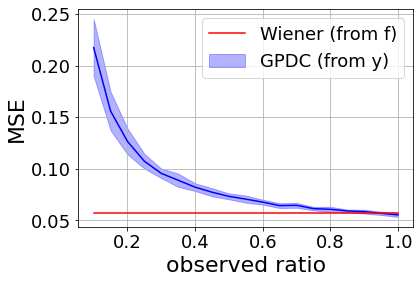

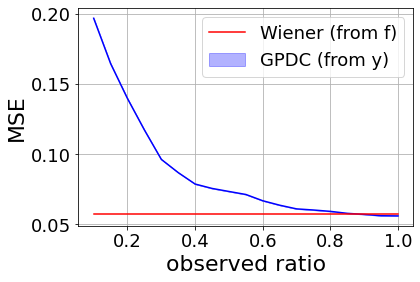

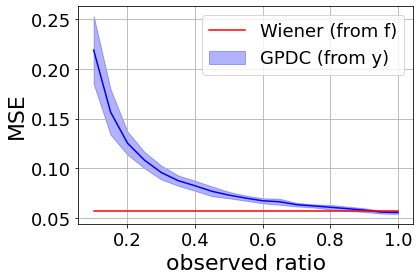

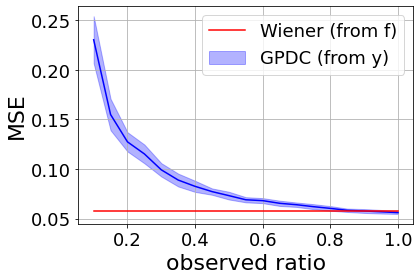

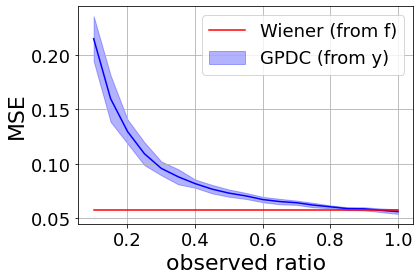

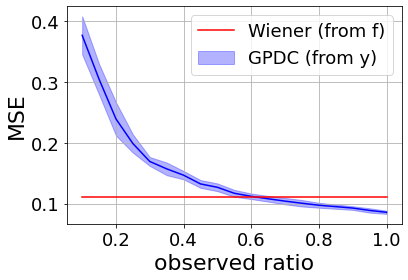

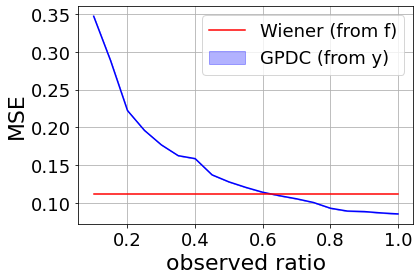

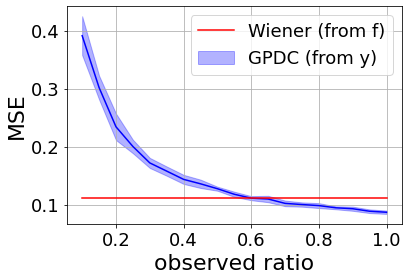

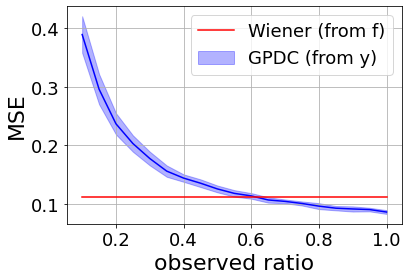

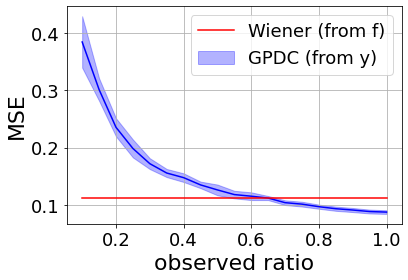

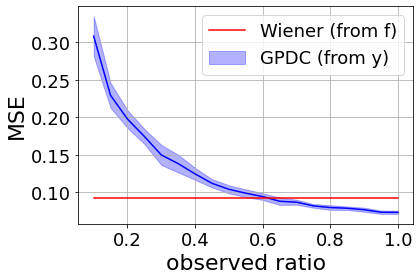

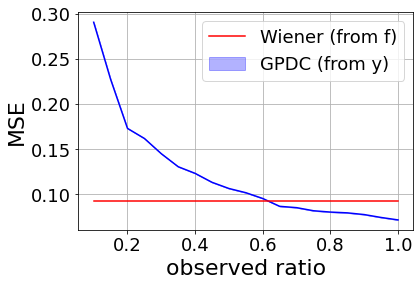

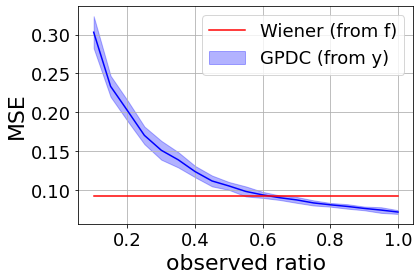

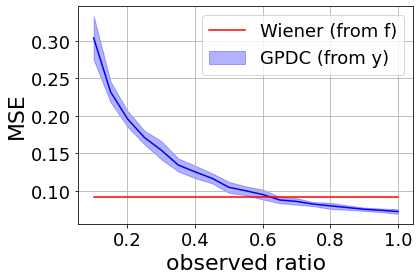

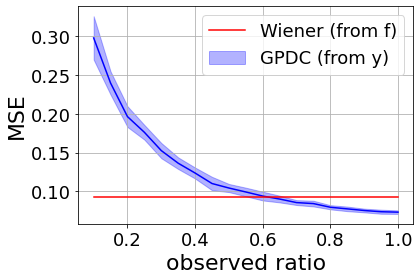

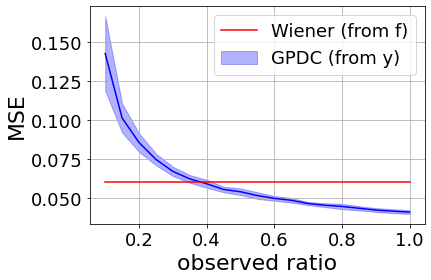

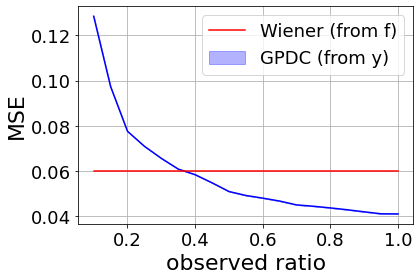

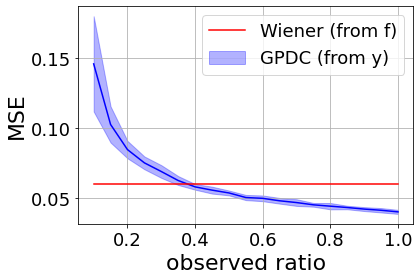

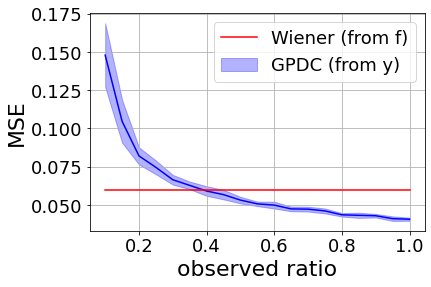

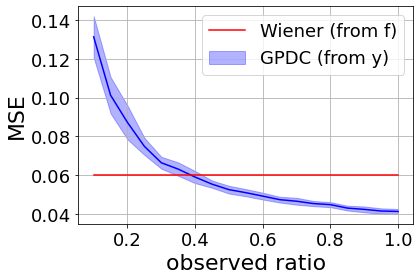

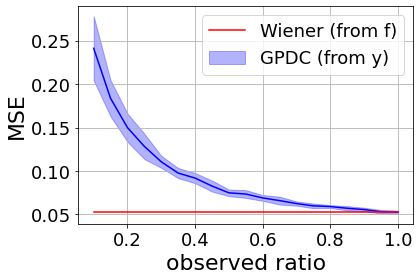

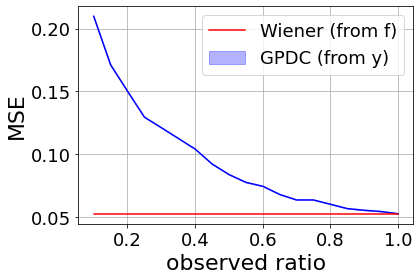

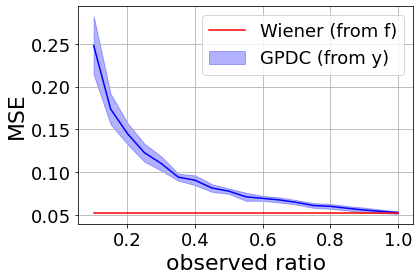

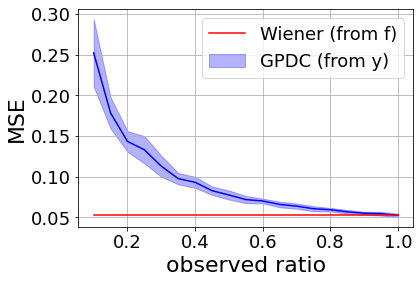

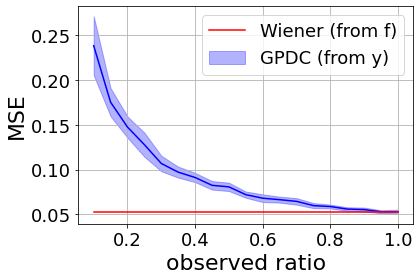

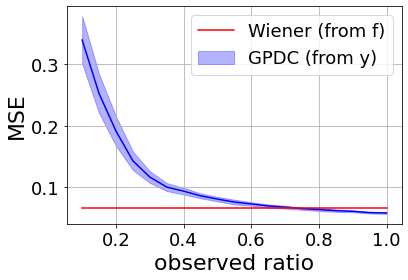

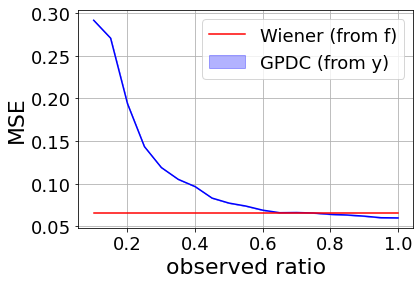

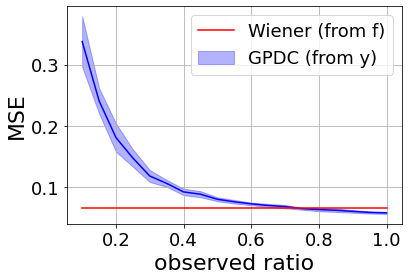

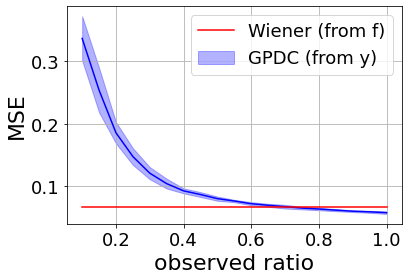

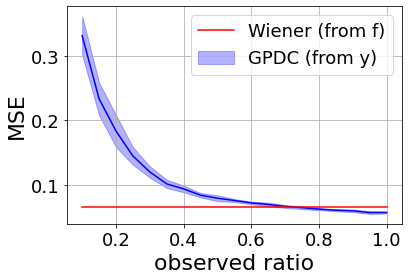

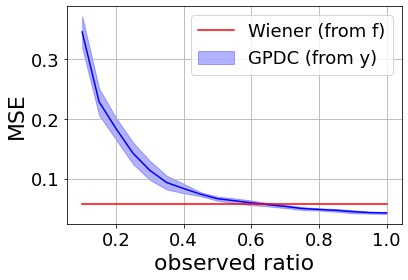

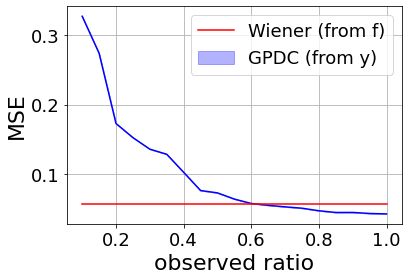

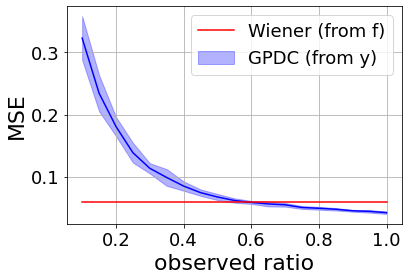

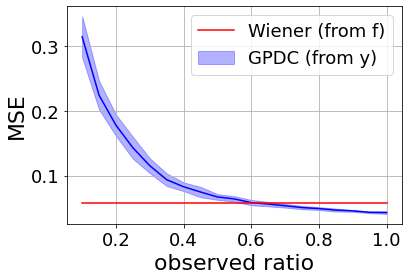

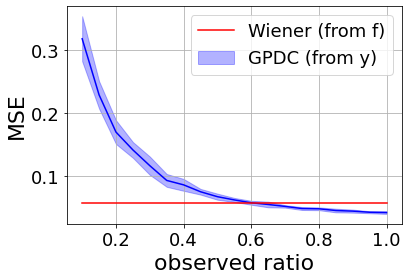

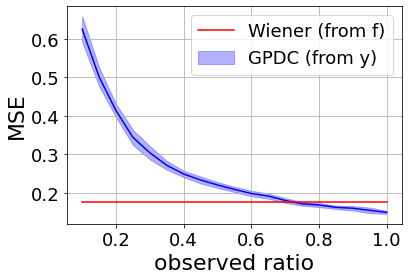

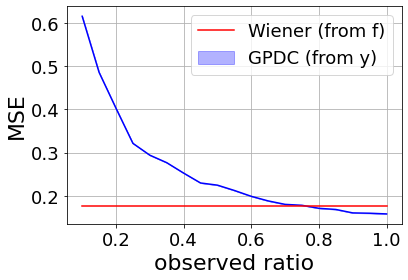

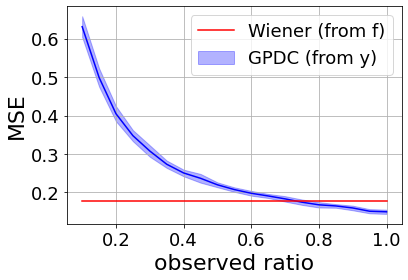

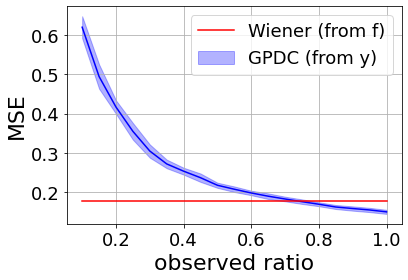

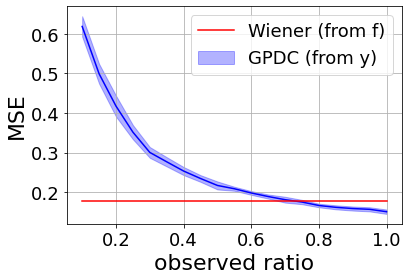

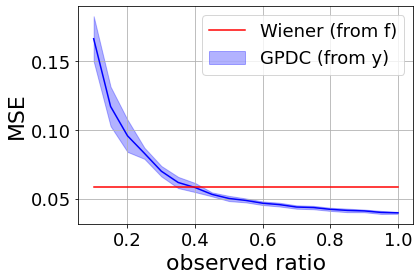

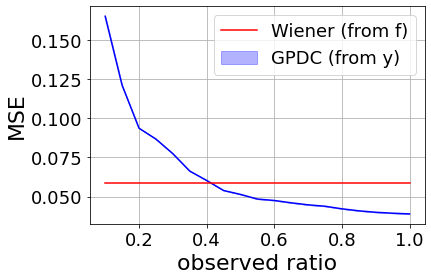

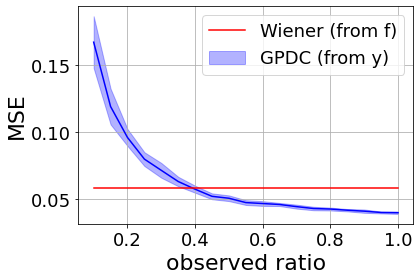

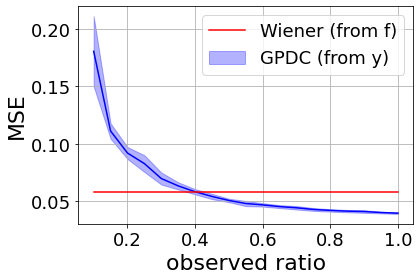

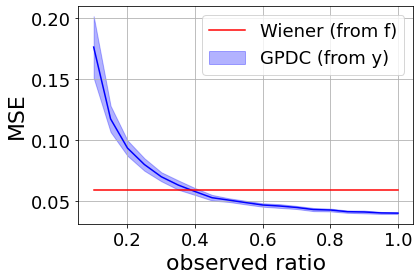

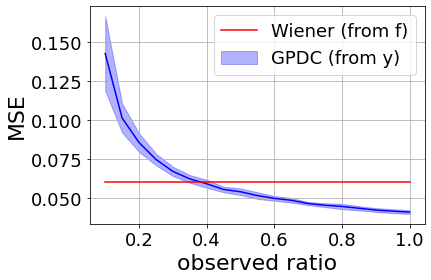

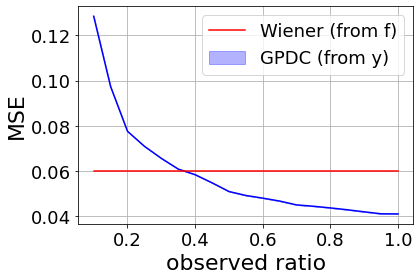

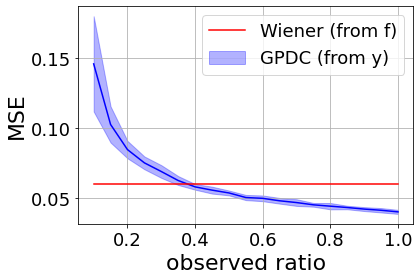

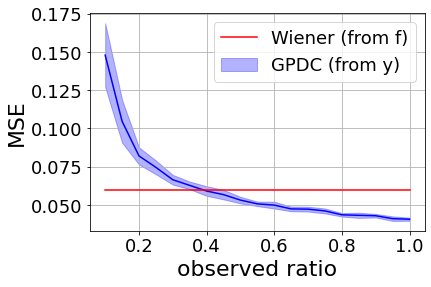

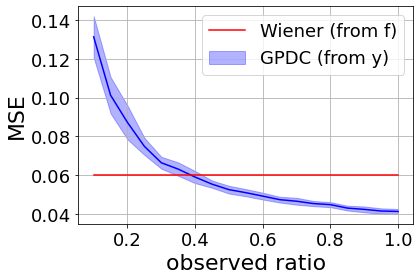

In [20]:
names = ['plane', 'bird', 'rider', 'emu', 'swiss_plane', 'frog', 'horse', 'grid', 'chequered']
filters = ['flat', 'random', 'diag', 'gauss', 'centered']

for n in names:
    for f in filters:
        experiment_performance(n,f)

0.01
0.30677834516589175


"plt.imshow(d, cmap='gray')\nplt.colorbar()\nplt.show()\nplt.imshow(my_gpc.post_mean_x.reshape(dim,dim), cmap='gray')\nprint(wiener_error)\nplt.colorbar()\nplt.show()\nplt.imshow(x, cmap='gray')\nplt.colorbar()\nplt.show()\nprint(np.mean(np.abs(my_gpc.post_mean_x - x.reshape(-1))**2))"

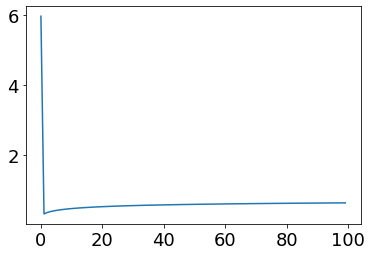

In [75]:
image_name = 'grid'
dim_w = 5
dim = 32
x, dim = get_image(image_name, dim) 

# grey scale
x = x.reshape(-1, 3)
# light grey scale : https://www.tutorialspoint.com/dip/grayscale_to_rgb_conversion.htm
x = np.array([0.3, 0.59, 0.11])@x.T
x -= np.mean(x)
x /= np.std(x)
x = x.reshape(dim, dim)
indices = get_img_indices(x)

# construct filter
h = np.ones((dim_w,dim_w)) * 1e-1
h[0,0] = 1
h[1,1] = 1
h[2,2] = 1
h[3,3] = 1
h[4,4] = 1

h /= np.sum(h)
h = np.flipud(np.fliplr(h))
# create convolved image and normalize
f = signal.convolve2d(x, h, mode='same')
f = f.reshape(-1)
f = f.reshape(dim,dim)

errs=[]
balances = np.arange(0,1., .01)
for b in balances:
    d = restoration.wiener(f, h, balance=b, clip=False )
    wiener_error = np.mean(np.abs(d.reshape(-1) - x.reshape(-1))**2)
    errs.append(wiener_error)

# chequered 0.06
# woven 0.01
# emu 0.08
# plane 0.03
# bird 0.01
# rider 0.02
# swiss_plane 0.01
# frog 0.01
# horse 0.01
# grid 0.01
    
idx = np.argmin(errs)
print(balances[idx])
print(np.min(errs))
plt.plot(errs)
"""plt.imshow(d, cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(my_gpc.post_mean_x.reshape(dim,dim), cmap='gray')
print(wiener_error)
plt.colorbar()
plt.show()
plt.imshow(x, cmap='gray')
plt.colorbar()
plt.show()
print(np.mean(np.abs(my_gpc.post_mean_x - x.reshape(-1))**2))"""